Pump it Up: Data Mining the Water Table from drivendata.com
In this project I used Optuna & XGBoost with multiple boosters to achieve a score of 0.6621.
CURRENT RANK 4841st out of 13922 competitors


In [4]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [5]:
train_values = pd.read_csv('train_values.csv', index_col='id')
train_labels = pd.read_csv('train_labels.csv', index_col='id')

In [6]:
import seaborn as sns

<AxesSubplot:xlabel='index'>

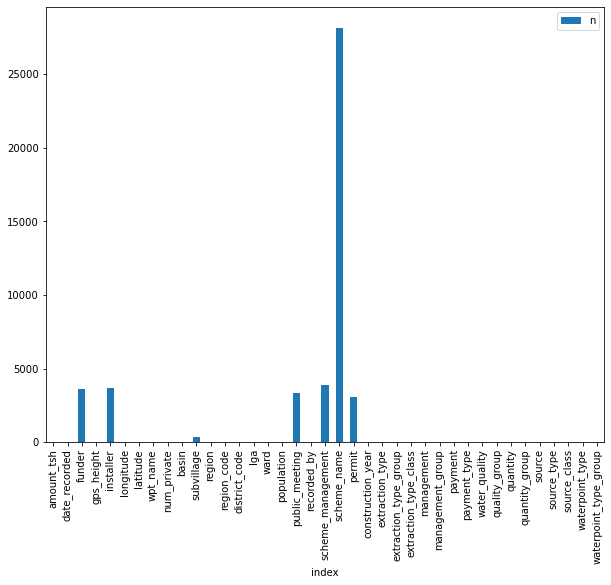

In [7]:
train_values.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=90, figsize=(10, 8))


In [8]:
df = pd.merge(train_values, train_labels, how='outer', left_on = 'id', right_on = 'id')

In [9]:
df.index.nunique()


59400

In [10]:
df.num_private.nunique()

65

In [11]:
for col in ['funder', 'installer', 'wpt_name', 'basin','subvillage','region','lga','ward','recorded_by','scheme_management']:
    df[col] = df[col].astype('category')

In [12]:
df = df.drop(['extraction_type_class', 'extraction_type_group', 'payment', 'quantity_group','source_type','waterpoint_type_group'], axis=1)

In [13]:
df1 = df.pop('status_group')
df['status_group']=df1

In [14]:
for col in ['permit', 'public_meeting', 'extraction_type', 'management','management_group','payment_type','water_quality','quality_group','quantity','source','source_class','waterpoint_type','status_group']:
    df[col] = df[col].astype('category')

In [15]:
df = df.drop(['funder', 'installer', 'wpt_name', 'num_private','subvillage','region','region_code','lga','ward','population'], axis=1)

In [16]:
df = df.drop(['basin', 'recorded_by', 'scheme_management', 'management','management_group','payment_type','quality_group','source_class'], axis=1)

In [17]:
df = df.drop(['district_code'], axis=1)

In [18]:
pd.set_option('display.max_columns', None)
df.head(5)

,amount_tsh,date_recorded,gps_height,longitude,latitude,public_meeting,scheme_name,permit,construction_year,extraction_type,water_quality,quantity,source,waterpoint_type,status_group
id,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,1390,34.938093,-9.856322,True,Roman,False,1999,gravity,soft,enough,spring,communal standpipe,functional
8776,0.0,2013-03-06,1399,34.698766,-2.147466,NaN,NaN,True,2010,gravity,soft,insufficient,rainwater harvesting,communal standpipe,functional
34310,25.0,2013-02-25,686,37.460664,-3.821329,True,Nyumba ya mungu pipe scheme,True,2009,gravity,soft,enough,dam,communal standpipe multiple,functional
67743,0.0,2013-01-28,263,38.486161,-11.155298,True,NaN,True,1986,submersible,soft,dry,machine dbh,communal standpipe multiple,non functional
19728,0.0,2011-07-13,0,31.130847,-1.825359,True,NaN,True,0,gravity,soft,seasonal,rainwater harvesting,communal standpipe,functional


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   amount_tsh         59400 non-null  float64 
 1   date_recorded      59400 non-null  object  
 2   gps_height         59400 non-null  int64   
 3   longitude          59400 non-null  float64 
 4   latitude           59400 non-null  float64 
 5   public_meeting     56066 non-null  category
 6   scheme_name        31234 non-null  object  
 7   permit             56344 non-null  category
 8   construction_year  59400 non-null  int64   
 9   extraction_type    59400 non-null  category
 10  water_quality      59400 non-null  category
 11  quantity           59400 non-null  category
 12  source             59400 non-null  category
 13  waterpoint_type    59400 non-null  category
 14  status_group       59400 non-null  category
dtypes: category(8), float64(3), int64(2), object(2)
m

In [20]:
df.isnull().values.any()

True

In [21]:
df.isnull().sum().sum()

34556

<AxesSubplot:xlabel='index'>

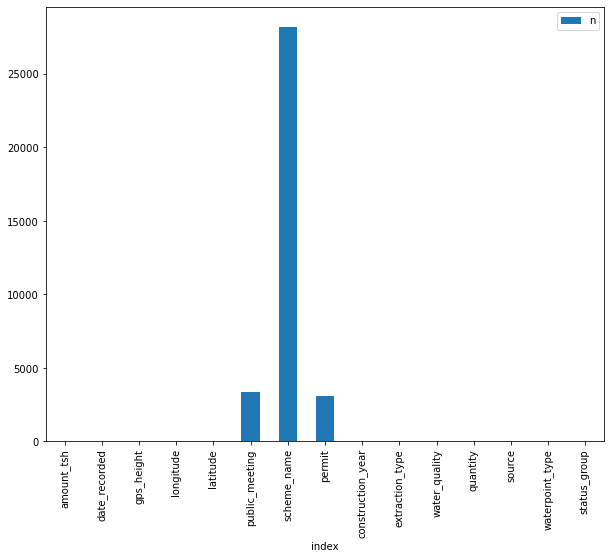

In [22]:
df.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=90, figsize=(10, 8))



In [23]:
for col in df.columns:
    print(df[col].isna().sum())
    


0
0
0
0
0
3334
28166
3056
0
0
0
0
0
0
0


In [24]:
mapping = {"functional":0,"functional needs repair":1, "non functional":2}

In [25]:
df['status_group'] = df['status_group'].map(mapping)


In [26]:
df.dropna(axis=0)

,amount_tsh,date_recorded,gps_height,longitude,latitude,public_meeting,scheme_name,permit,construction_year,extraction_type,water_quality,quantity,source,waterpoint_type,status_group
id,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,1390,34.938093,-9.856322,True,Roman,False,1999,gravity,soft,enough,spring,communal standpipe,0
34310,25.0,2013-02-25,686,37.460664,-3.821329,True,Nyumba ya mungu pipe scheme,True,2009,gravity,soft,enough,dam,communal standpipe multiple,0
9944,20.0,2011-03-13,0,39.172796,-4.765587,True,Zingibali,True,2009,submersible,salty,enough,other,communal standpipe multiple,0
50495,0.0,2013-03-15,1368,37.092574,-3.181783,True,BL Bondeni,True,2009,gravity,soft,enough,spring,communal standpipe,0
53752,0.0,2012-10-20,0,34.364073,-3.629333,True,None,True,0,nira/tanira,soft,enough,shallow well,hand pump,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67885,0.0,2011-03-16,0,38.835001,-4.880204,True,Magati water schem,True,1992,gravity,soft,insufficient,spring,communal standpipe,2
47002,6.0,2013-08-03,1383,37.454759,-3.323599,True,Kirua kahe gravity water supply trust,True,2008,gravity,soft,enough,spring,communal standpipe,2
44885,0.0,2013-08-03,540,38.044070,-4.272218,True,Hingilili,True,1967,gravity,soft,enough,river,communal standpipe,2


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   amount_tsh         59400 non-null  float64 
 1   date_recorded      59400 non-null  object  
 2   gps_height         59400 non-null  int64   
 3   longitude          59400 non-null  float64 
 4   latitude           59400 non-null  float64 
 5   public_meeting     56066 non-null  category
 6   scheme_name        31234 non-null  object  
 7   permit             56344 non-null  category
 8   construction_year  59400 non-null  int64   
 9   extraction_type    59400 non-null  category
 10  water_quality      59400 non-null  category
 11  quantity           59400 non-null  category
 12  source             59400 non-null  category
 13  waterpoint_type    59400 non-null  category
 14  status_group       59400 non-null  category
dtypes: category(8), float64(3), int64(2), object(2)
m

In [28]:
df_2 = pd.get_dummies(df, columns=['public_meeting', 'permit', 'extraction_type', 'water_quality', 'quantity', 'source','waterpoint_type'], drop_first=True)
df_2

,amount_tsh,date_recorded,gps_height,longitude,latitude,scheme_name,construction_year,status_group,public_meeting_True,permit_True,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,1390,34.938093,-9.856322,Roman,1999,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8776,0.0,2013-03-06,1399,34.698766,-2.147466,NaN,2010,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
34310,25.0,2013-02-25,686,37.460664,-3.821329,Nyumba ya mungu pipe scheme,2009,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
67743,0.0,2013-01-28,263,38.486161,-11.155298,NaN,1986,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
19728,0.0,2011-07-13,0,31.130847,-1.825359,NaN,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,2013-05-03,1210,37.169807,-3.253847,Losaa Kia water supply,1999,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
27263,4700.0,2011-05-07,1212,35.249991,-9.070629,Ikondo electrical water sch,1996,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
37057,0.0,2011-04-11,0,34.017087,-8.750434,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [29]:
df[['construction_year']].value_counts()

construction_year
0                    20709
2010                  2645
2008                  2613
2009                  2533
2000                  2091
2007                  1587
2006                  1471
2003                  1286
2011                  1256
2004                  1123
2012                  1084
2002                  1075
1978                  1037
1995                  1014
2005                  1011
1999                   979
1998                   966
1990                   954
1985                   945
1980                   811
1996                   811
1984                   779
1982                   744
1994                   738
1972                   708
1974                   676
1997                   644
1992                   640
1993                   608
2001                   540
1988                   521
1983                   488
1975                   437
1986                   434
1976                   414
1970                   411
1991      

In [30]:
df = df_2.drop(['amount_tsh', 'scheme_name','construction_year','gps_height','date_recorded'], axis=1)

In [31]:
df.head()

,longitude,latitude,status_group,public_meeting_True,permit_True,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,34.938093,-9.856322,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8776,34.698766,-2.147466,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
34310,37.460664,-3.821329,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
67743,38.486161,-11.155298,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
19728,31.130847,-1.825359,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [32]:
df = df.drop(['longitude'], axis=1)


In [33]:
from sklearn.preprocessing import StandardScaler
col_names = ['latitude']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [34]:
df.head()

,latitude,status_group,public_meeting_True,permit_True,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,-9.856322,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8776,-2.147466,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
34310,-3.821329,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
67743,-11.155298,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
19728,-1.825359,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [35]:
df1 = df.pop('status_group')
df['status_group']=df1

In [36]:
df.columns

Index(['latitude', 'public_meeting_True', 'permit_True',
       'extraction_type_cemo', 'extraction_type_climax',
       'extraction_type_gravity', 'extraction_type_india mark ii',
       'extraction_type_india mark iii', 'extraction_type_ksb',
       'extraction_type_mono', 'extraction_type_nira/tanira',
       'extraction_type_other', 'extraction_type_other - mkulima/shinyanga',
       'extraction_type_other - play pump',
       'extraction_type_other - rope pump', 'extraction_type_other - swn 81',
       'extraction_type_submersible', 'extraction_type_swn 80',
       'extraction_type_walimi', 'extraction_type_windmill',
       'water_quality_fluoride', 'water_quality_fluoride abandoned',
       'water_quality_milky', 'water_quality_salty',
       'water_quality_salty abandoned', 'water_quality_soft',
       'water_quality_unknown', 'quantity_enough', 'quantity_insufficient',
       'quantity_seasonal', 'quantity_unknown', 'source_hand dtw',
       'source_lake', 'source_machine dbh'

In [37]:
df.corrwith(df['status_group']).sort_values(ascending=False)

waterpoint_type_other                          0.310295
extraction_type_other                          0.295936
water_quality_unknown                          0.163276
waterpoint_type_communal standpipe multiple    0.114094
source_lake                                    0.086543
extraction_type_mono                           0.084968
source_shallow well                            0.074402
quantity_unknown                               0.073438
source_machine dbh                             0.068227
water_quality_salty                            0.062256
extraction_type_ksb                            0.024149
extraction_type_other - play pump              0.018522
extraction_type_climax                         0.016105
extraction_type_windmill                       0.011427
extraction_type_india mark iii                 0.010729
quantity_insufficient                          0.010173
water_quality_fluoride abandoned               0.008069
extraction_type_other - mkulima/shinyanga      0

In [38]:
final_df = df[['waterpoint_type_other',
'extraction_type_other',
'water_quality_unknown',
'waterpoint_type_communal standpipe multiple',
'source_lake',
'extraction_type_mono',
'waterpoint_type_hand pump',                   
'source_spring',                   
'water_quality_soft',                            
'extraction_type_gravity',
'waterpoint_type_communal standpipe',
'quantity_enough',
'status_group']].copy()
final_df.columns

Index(['waterpoint_type_other', 'extraction_type_other',
       'water_quality_unknown', 'waterpoint_type_communal standpipe multiple',
       'source_lake', 'extraction_type_mono', 'waterpoint_type_hand pump',
       'source_spring', 'water_quality_soft', 'extraction_type_gravity',
       'waterpoint_type_communal standpipe', 'quantity_enough',
       'status_group'],
      dtype='object')

In [39]:
final_df.columns

Index(['waterpoint_type_other', 'extraction_type_other',
       'water_quality_unknown', 'waterpoint_type_communal standpipe multiple',
       'source_lake', 'extraction_type_mono', 'waterpoint_type_hand pump',
       'source_spring', 'water_quality_soft', 'extraction_type_gravity',
       'waterpoint_type_communal standpipe', 'quantity_enough',
       'status_group'],
      dtype='object')

In [40]:
x = final_df.iloc[:, :-1]
y = final_df['status_group']
x.columns


Index(['waterpoint_type_other', 'extraction_type_other',
       'water_quality_unknown', 'waterpoint_type_communal standpipe multiple',
       'source_lake', 'extraction_type_mono', 'waterpoint_type_hand pump',
       'source_spring', 'water_quality_soft', 'extraction_type_gravity',
       'waterpoint_type_communal standpipe', 'quantity_enough'],
      dtype='object')

In [46]:
%%time
import optuna

import sklearn.datasets
from sklearn.model_selection import train_test_split
import sklearn.metrics
import xgboost as xgb


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "num_class": 3,
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1000, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-08-07 12:40:14,781] A new study created in memory with name: no-name-46e5c904-2db8-443c-87b5-ffb8ccd749fa


[12:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:40:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:15,352] Trial 0 finished with value: 0.6523905723905724 and parameters: {'booster': 'dart', 'lambda': 0.0003983193933540608, 'alpha': 4.4186259086405794e-08, 'subsample': 0.21381632729897904, 'colsample_bytree': 0.589294663360934, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.0014893707076201366, 'gamma': 5.234820205644028e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.3429043518340507e-05, 'skip_drop': 7.768911004719857e-08}. Best is trial 0 with value: 0.6523905723905724.


[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:40:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes,

[I 2022-08-07 12:40:15,634] Trial 1 finished with value: 0.6437037037037037 and parameters: {'booster': 'dart', 'lambda': 9.680860429826123e-06, 'alpha': 2.1165590145059873e-05, 'subsample': 0.32693542244795837, 'colsample_bytree': 0.35590446571917633, 'max_depth': 3, 'min_child_weight': 7, 'eta': 7.28533975133258e-05, 'gamma': 0.613224317714394, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.001095347165932879, 'skip_drop': 9.720315650712247e-08}. Best is trial 0 with value: 0.6523905723905724.


[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[12:40:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[12:40:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[12:40:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:40:16,744] Trial 2 finished with value: 0.6648484848484848 and parameters: {'booster': 'dart', 'lambda': 4.287086572547709e-05, 'alpha': 3.910605037502175e-06, 'subsample': 0.6985117288480966, 'colsample_bytree': 0.7558702434857154, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6370943487934745, 'gamma': 1.9082089697721663e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0075794678741984926, 'skip_drop': 0.11359294849389615}. Best is trial 2 with value: 0.6648484848484848.


[12:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:40:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:40:16] src/gbm/gbtree.cc:494: drop 1 trees, weight = 0.824834
[12:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 p

[I 2022-08-07 12:40:17,154] Trial 3 finished with value: 0.647070707070707 and parameters: {'booster': 'gbtree', 'lambda': 0.006690767522440041, 'alpha': 5.520181793275029e-08, 'subsample': 0.6298159317879912, 'colsample_bytree': 0.7769092277883545, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.040658893758512366, 'gamma': 0.00039202657376294397, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.6648484848484848.


[12:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:18,139] Trial 4 finished with value: 0.655016835016835 and parameters: {'booster': 'dart', 'lambda': 0.00010812476201934566, 'alpha': 0.0006615862482212829, 'subsample': 0.6089254009276122, 'colsample_bytree': 0.7056472783838514, 'max_depth': 9, 'min_child_weight': 6, 'eta': 7.013686447958551e-05, 'gamma': 1.9823849382031465e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.1594430916487654e-05, 'skip_drop': 0.001789234260903528}. Best is trial 2 with value: 0.6648484848484848.


[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[12:40:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:40:18] src/tree/updater_prune.cc:74: tre

[I 2022-08-07 12:40:18,591] Trial 5 finished with value: 0.652996632996633 and parameters: {'booster': 'gbtree', 'lambda': 0.0005369108792205389, 'alpha': 0.11009361269046708, 'subsample': 0.7148878482667915, 'colsample_bytree': 0.4834263443561618, 'max_depth': 9, 'min_child_weight': 4, 'eta': 1.5296624035060312e-08, 'gamma': 1.3343100844299842e-05, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.6648484848484848.
[I 2022-08-07 12:40:18,677] Trial 6 finished with value: 0.650976430976431 and parameters: {'booster': 'gblinear', 'lambda': 5.221864697608633e-05, 'alpha': 1.569537728184515e-07, 'subsample': 0.609082136965249, 'colsample_bytree': 0.48748706989596446}. Best is trial 2 with value: 0.6648484848484848.


[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:18,967] Trial 7 finished with value: 0.648080808080808 and parameters: {'booster': 'gbtree', 'lambda': 1.802124499625184e-08, 'alpha': 0.0012796210753272138, 'subsample': 0.3074234674455705, 'colsample_bytree': 0.5620822630022593, 'max_depth': 3, 'min_child_weight': 9, 'eta': 1.3262699007611808e-08, 'gamma': 0.0004270454991921757, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.6648484848484848.


[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_dep

[I 2022-08-07 12:40:19,196] Trial 8 finished with value: 0.6230976430976432 and parameters: {'booster': 'dart', 'lambda': 0.0011262273347018234, 'alpha': 2.8217777587329836e-07, 'subsample': 0.3917842266528247, 'colsample_bytree': 0.22006179925036565, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.01750723565305492, 'gamma': 0.05204328371953505, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.02757719953986952, 'skip_drop': 9.497213482017678e-07}. Best is trial 2 with value: 0.6648484848484848.


[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:19] src/gbm/gbtree.cc:494: drop 1 trees, weight = 0.994198
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:40:19,493] Trial 9 finished with value: 0.6367003367003367 and parameters: {'booster': 'dart', 'lambda': 0.02103368661405769, 'alpha': 0.4566056640208818, 'subsample': 0.6877123664322493, 'colsample_bytree': 0.33160759701371123, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.0413916168246763e-07, 'gamma': 0.8056525823808383, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.01905443331416467, 'skip_drop': 0.006419689108459295}. Best is trial 2 with value: 0.6648484848484848.


[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:40:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:40:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:40:19,586] Trial 10 finished with value: 0.6520538720538721 and parameters: {'booster': 'gblinear', 'lambda': 8.099507607996162e-07, 'alpha': 1.6378477416874275e-05, 'subsample': 0.9590326553134312, 'colsample_bytree': 0.9769151548964743}. Best is trial 2 with value: 0.6648484848484848.


[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:40:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:40:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned n

[I 2022-08-07 12:40:20,489] Trial 11 finished with value: 0.6643771043771044 and parameters: {'booster': 'dart', 'lambda': 3.814478554047988e-06, 'alpha': 0.001243741765442812, 'subsample': 0.8536344521662171, 'colsample_bytree': 0.7781047820092614, 'max_depth': 7, 'min_child_weight': 2, 'eta': 1.7932435019119296e-05, 'gamma': 8.322889697979557e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.425241317477513e-08, 'skip_drop': 0.47037501829275336}. Best is trial 2 with value: 0.6648484848484848.


[12:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[12:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[12:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:40:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[12:40:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned

[I 2022-08-07 12:40:21,470] Trial 12 finished with value: 0.6522558922558923 and parameters: {'booster': 'dart', 'lambda': 7.85662075297044e-07, 'alpha': 0.013492328543548216, 'subsample': 0.8644627206161548, 'colsample_bytree': 0.8553002195423836, 'max_depth': 7, 'min_child_weight': 2, 'eta': 2.41755564888285e-06, 'gamma': 1.6596646726162324e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.6992501971450084e-07, 'skip_drop': 0.9208318497348102}. Best is trial 2 with value: 0.6648484848484848.


[12:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:40:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[12:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:40:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[12:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[12:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned 

[I 2022-08-07 12:40:22,444] Trial 13 finished with value: 0.6633670033670034 and parameters: {'booster': 'dart', 'lambda': 3.5487241674193814e-06, 'alpha': 1.4533233817379543e-06, 'subsample': 0.8408621790123196, 'colsample_bytree': 0.8993696265098015, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.19172962007126057, 'gamma': 3.316140085679255e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.699121967544156e-08, 'skip_drop': 0.4874432946246338}. Best is trial 2 with value: 0.6648484848484848.


[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[12:40:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[12:40:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned n

[I 2022-08-07 12:40:23,080] Trial 14 finished with value: 0.6508417508417509 and parameters: {'booster': 'dart', 'lambda': 0.30033587835769127, 'alpha': 9.504470933797339e-05, 'subsample': 0.480943683524515, 'colsample_bytree': 0.7129701637546473, 'max_depth': 5, 'min_child_weight': 3, 'eta': 6.197417200466137e-06, 'gamma': 6.391070794128763e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.8825982043520164, 'skip_drop': 0.013375985766501486}. Best is trial 2 with value: 0.6648484848484848.


[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:40:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/gbm/gbtree.cc:494: drop 21 trees, weight = 0.999998
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/gbm/gbtree.cc:494: drop 22 trees, weight = 0.999998


[I 2022-08-07 12:40:23,174] Trial 15 finished with value: 0.6539393939393939 and parameters: {'booster': 'gblinear', 'lambda': 3.4836780746924815e-08, 'alpha': 5.325880983730674e-06, 'subsample': 0.7919552667563339, 'colsample_bytree': 0.7702402750224177}. Best is trial 2 with value: 0.6648484848484848.


[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:23,762] Trial 16 finished with value: 0.6676094276094277 and parameters: {'booster': 'dart', 'lambda': 2.9309593530877455e-07, 'alpha': 0.0033841310721156033, 'subsample': 0.9629614676265112, 'colsample_bytree': 0.6872843490424659, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.9102006565760694, 'gamma': 2.2182985369024685e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0849446722718711e-06, 'skip_drop': 8.163346547758392e-05}. Best is trial 16 with value: 0.6676094276094277.


[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:24,308] Trial 17 finished with value: 0.6622222222222223 and parameters: {'booster': 'dart', 'lambda': 1.744306582741412e-07, 'alpha': 0.03498881937509205, 'subsample': 0.9845342678714053, 'colsample_bytree': 0.6572151339006771, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.6498419957993271, 'gamma': 3.254363103036071e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.1812907805199658e-06, 'skip_drop': 1.896549149074905e-05}. Best is trial 16 with value: 0.6676094276094277.
[I 2022-08-07 12:40:24,402] Trial 18 finished with value: 0.6495622895622896 and parameters: {'booster': 'gblinear', 'lambda': 1.1526995612833221e-07, 'alpha': 0.00016464586708430168, 'subsample': 0.46821113285216137, 'colsample_bytree': 0.877387025172038}. Best is trial 16 with value: 0.6676094276094277.


[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:40:25,109] Trial 19 finished with value: 0.6572390572390573 and parameters: {'booster': 'gbtree', 'lambda': 2.477576156851022e-05, 'alpha': 1.1413356981316014e-08, 'subsample': 0.7429803916762526, 'colsample_bytree': 0.9785759644875358, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.0020025329060585533, 'gamma': 3.095456953537897e-07, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.6676094276094277.


[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:25,615] Trial 20 finished with value: 0.6523905723905724 and parameters: {'booster': 'dart', 'lambda': 6.668243545502838e-07, 'alpha': 0.013396679451044963, 'subsample': 0.5133866966072657, 'colsample_bytree': 0.49117574956196225, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.0025628017928037688, 'gamma': 0.0054771304255219234, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0003796727462413032, 'skip_drop': 9.208530002155222e-05}. Best is trial 16 with value: 0.6676094276094277.


[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=5
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:40:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:40:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nod

[I 2022-08-07 12:40:26,504] Trial 21 finished with value: 0.6664646464646464 and parameters: {'booster': 'dart', 'lambda': 5.114309901875783e-06, 'alpha': 0.0013635681283301988, 'subsample': 0.8755406361485277, 'colsample_bytree': 0.7940145834507857, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.6892270195259059, 'gamma': 1.0349777540420618e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.3375586207039432e-08, 'skip_drop': 0.04529847554268177}. Best is trial 16 with value: 0.6676094276094277.


[12:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:40:26] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:40:26] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:27,279] Trial 22 finished with value: 0.6657912457912458 and parameters: {'booster': 'dart', 'lambda': 4.948206096101746e-06, 'alpha': 0.005026173838870353, 'subsample': 0.9036564278926913, 'colsample_bytree': 0.6514750022260224, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9877012221849975, 'gamma': 1.5803160717570094e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.911674284956132e-07, 'skip_drop': 0.025731219301609994}. Best is trial 16 with value: 0.6676094276094277.


[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:40:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:28,013] Trial 23 finished with value: 0.6554882154882155 and parameters: {'booster': 'dart', 'lambda': 2.6754589214503374e-06, 'alpha': 0.004539927704096416, 'subsample': 0.9310424405929523, 'colsample_bytree': 0.6231092100118915, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.07023773041902527, 'gamma': 1.7516211427522113e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.786130285505047e-07, 'skip_drop': 0.0008186726746201027}. Best is trial 16 with value: 0.6676094276094277.


[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:40:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned node

[I 2022-08-07 12:40:28,617] Trial 24 finished with value: 0.6676767676767676 and parameters: {'booster': 'dart', 'lambda': 1.1002522545332248e-07, 'alpha': 0.00017561313701718666, 'subsample': 0.9101725009416138, 'colsample_bytree': 0.6712358225441528, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.9940841702253893, 'gamma': 1.4807687374538695e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.188307944727015e-08, 'skip_drop': 1.2251142441347795e-05}. Best is trial 24 with value: 0.6676767676767676.


[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:40:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:28] src/tree/updater_prune.cc:74

[I 2022-08-07 12:40:29,121] Trial 25 finished with value: 0.657979797979798 and parameters: {'booster': 'dart', 'lambda': 1.40958164658266e-07, 'alpha': 0.00014120803883023667, 'subsample': 0.9850139375799075, 'colsample_bytree': 0.5435196327350262, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.0095381176302272, 'gamma': 1.1544075238298841e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.115893099252441e-08, 'skip_drop': 6.412144524105243e-06}. Best is trial 24 with value: 0.6676767676767676.


[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:29,800] Trial 26 finished with value: 0.6620875420875421 and parameters: {'booster': 'dart', 'lambda': 1.1890186378562192e-08, 'alpha': 0.0005192941709051673, 'subsample': 0.790780753259077, 'colsample_bytree': 0.8204219801833008, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.15246455549518834, 'gamma': 4.66680189134876e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.5167830340935777e-06, 'skip_drop': 0.0002442690443632659}. Best is trial 24 with value: 0.6676767676767676.


[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:40:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:29] src/tree/updater_prune.cc:74

[I 2022-08-07 12:40:30,415] Trial 27 finished with value: 0.6642424242424242 and parameters: {'booster': 'dart', 'lambda': 7.284165340471514e-08, 'alpha': 3.760047299839393e-05, 'subsample': 0.9064622694834135, 'colsample_bytree': 0.689346689910386, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.1355106392930947, 'gamma': 5.785397919318874e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.890254728648932e-08, 'skip_drop': 2.429630181685346e-06}. Best is trial 24 with value: 0.6676767676767676.


[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1


[I 2022-08-07 12:40:30,493] Trial 28 finished with value: 0.5443771043771044 and parameters: {'booster': 'gblinear', 'lambda': 3.825677018908222e-07, 'alpha': 0.08936605777687331, 'subsample': 0.7876043544244703, 'colsample_bytree': 0.9220290643997449}. Best is trial 24 with value: 0.6676767676767676.


[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:31,171] Trial 29 finished with value: 0.6614814814814814 and parameters: {'booster': 'gbtree', 'lambda': 1.5271656960957387e-06, 'alpha': 0.0032690218378762224, 'subsample': 0.8910886568372463, 'colsample_bytree': 0.6063429817007799, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.00039684917506897, 'gamma': 1.1624686748982922e-08, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.6676767676767676.


[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:31,789] Trial 30 finished with value: 0.6502356902356903 and parameters: {'booster': 'dart', 'lambda': 1.628495826951072e-05, 'alpha': 0.747978199870202, 'subsample': 0.9986078540777068, 'colsample_bytree': 0.8291509605539173, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.0119299067417291, 'gamma': 9.410802531834746e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0407788839082727e-08, 'skip_drop': 9.54150993829783e-05}. Best is trial 24 with value: 0.6676767676767676.


[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:40:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:31] src/tree/updater_prune.cc:74

[I 2022-08-07 12:40:32,564] Trial 31 finished with value: 0.6659259259259259 and parameters: {'booster': 'dart', 'lambda': 6.836727756758601e-06, 'alpha': 0.004842598083103462, 'subsample': 0.9276659947178393, 'colsample_bytree': 0.6449647278776409, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9044061775567651, 'gamma': 1.2127309883189789e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.312979067409751e-07, 'skip_drop': 0.038187232085241024}. Best is trial 24 with value: 0.6676767676767676.


[12:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:40:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:40:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:33,372] Trial 32 finished with value: 0.6607407407407407 and parameters: {'booster': 'dart', 'lambda': 0.00011859382213658599, 'alpha': 0.0003774698170078274, 'subsample': 0.9362846991163113, 'colsample_bytree': 0.7300064186283282, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.9597550413759024, 'gamma': 6.288908412610138e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.736635085164728e-08, 'skip_drop': 2.295667097224178e-05}. Best is trial 24 with value: 0.6676767676767676.


[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:40:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:33] src/tree/updater_prune.cc:7

[I 2022-08-07 12:40:33,903] Trial 33 finished with value: 0.6577777777777778 and parameters: {'booster': 'dart', 'lambda': 1.2493228794676286e-05, 'alpha': 0.0018767158692451348, 'subsample': 0.819882615614539, 'colsample_bytree': 0.56348842579351, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.23257590242531026, 'gamma': 1.511526127227796e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.4007623451760457e-07, 'skip_drop': 0.001596490087035482}. Best is trial 24 with value: 0.6676767676767676.


[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:34,689] Trial 34 finished with value: 0.6557575757575758 and parameters: {'booster': 'dart', 'lambda': 2.583499848717466e-07, 'alpha': 0.01831308288660344, 'subsample': 0.9381913204234839, 'colsample_bytree': 0.6623035378185453, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.041741978138563306, 'gamma': 3.174298805327411e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.9311493811281945e-06, 'skip_drop': 0.04058705007298584}. Best is trial 24 with value: 0.6676767676767676.


[12:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:40:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:40:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:35,380] Trial 35 finished with value: 0.6633670033670034 and parameters: {'booster': 'dart', 'lambda': 4.005864018213031e-08, 'alpha': 6.769118278024678e-05, 'subsample': 0.21692448845058293, 'colsample_bytree': 0.8052734535636039, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.2560992579137606, 'gamma': 5.8673184845314465e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.209616502260753e-08, 'skip_drop': 6.152696497710516e-07}. Best is trial 24 with value: 0.6676767676767676.


[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:40:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:40:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:35,800] Trial 36 finished with value: 0.6458585858585859 and parameters: {'booster': 'dart', 'lambda': 8.80449042095223e-06, 'alpha': 0.00021786169483275876, 'subsample': 0.749361200514591, 'colsample_bytree': 0.4108078567068426, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.03343393270488838, 'gamma': 7.978451074453602e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.2518560939169213e-05, 'skip_drop': 0.0003841926129745792}. Best is trial 24 with value: 0.6676767676767676.


[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:40:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:40:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:36,231] Trial 37 finished with value: 0.6527946127946128 and parameters: {'booster': 'dart', 'lambda': 1.4565838820830426e-06, 'alpha': 0.05553965302184011, 'subsample': 0.6751102320459181, 'colsample_bytree': 0.7465488006176331, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.3336942554732835, 'gamma': 2.7270445805189604e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0397607418803867e-08, 'skip_drop': 0.07909006470483}. Best is trial 24 with value: 0.6676767676767676.


[12:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:36] src/tree/updater_prune.cc:74

[I 2022-08-07 12:40:36,964] Trial 38 finished with value: 0.6597306397306397 and parameters: {'booster': 'gbtree', 'lambda': 0.00017224553321891736, 'alpha': 1.2317576002440834e-05, 'subsample': 0.861939454287325, 'colsample_bytree': 0.6097342363483079, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.0004620146024768215, 'gamma': 1.1617180440423894e-06, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.6676767676767676.


[12:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:40:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:40:37] src/gbm/gbtree.cc:494: drop 0 tree

[I 2022-08-07 12:40:37,782] Trial 39 finished with value: 0.6435690235690236 and parameters: {'booster': 'dart', 'lambda': 0.0013126745306319566, 'alpha': 0.007047643863870595, 'subsample': 0.8886426305722137, 'colsample_bytree': 0.687617257626562, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.06521781303044911, 'gamma': 2.800490612503405e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.179696862973579e-07, 'skip_drop': 1.2428485001152211e-08}. Best is trial 24 with value: 0.6676767676767676.


[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:40:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:37] src/tree/updater_prune.cc:7

[I 2022-08-07 12:40:38,182] Trial 40 finished with value: 0.6482828282828282 and parameters: {'booster': 'dart', 'lambda': 4.85410670065808e-05, 'alpha': 0.22113873334083028, 'subsample': 0.5427231001208124, 'colsample_bytree': 0.5466782290417005, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.007789857581468659, 'gamma': 7.981689957503531e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.141917119398148e-08, 'skip_drop': 0.0033977624248086803}. Best is trial 24 with value: 0.6676767676767676.


[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:38] src/tree/updater_prune.cc:74

[I 2022-08-07 12:40:38,956] Trial 41 finished with value: 0.6647138047138047 and parameters: {'booster': 'dart', 'lambda': 8.722699726974456e-06, 'alpha': 0.0009371494829287061, 'subsample': 0.9135123595524427, 'colsample_bytree': 0.6462808868904125, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5987795317523901, 'gamma': 1.3218468500772537e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.54403696502933e-07, 'skip_drop': 0.022363436152001783}. Best is trial 24 with value: 0.6676767676767676.


[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:40:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:39,904] Trial 42 finished with value: 0.658989898989899 and parameters: {'booster': 'dart', 'lambda': 5.401841074714518e-06, 'alpha': 0.003100954084099331, 'subsample': 0.9661676757122087, 'colsample_bytree': 0.7223316279509983, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9927846818094241, 'gamma': 1.62193337284352e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.8775310814866214e-05, 'skip_drop': 0.2157675303036084}. Best is trial 24 with value: 0.6676767676767676.


[12:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:40:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:40] src/tree/updater_prune.cc:74

[I 2022-08-07 12:40:40,693] Trial 43 finished with value: 0.6647811447811448 and parameters: {'booster': 'dart', 'lambda': 3.946947785021293e-07, 'alpha': 0.00723755957893132, 'subsample': 0.8225595926502721, 'colsample_bytree': 0.5846685700877725, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9980638279295432, 'gamma': 4.564952556551749e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.7401788478045845e-07, 'skip_drop': 2.4289779896098935e-05}. Best is trial 24 with value: 0.6676767676767676.


[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:41,487] Trial 44 finished with value: 0.6518518518518519 and parameters: {'booster': 'dart', 'lambda': 1.773043515165641e-06, 'alpha': 0.0005436919973634808, 'subsample': 0.8782571886553107, 'colsample_bytree': 0.6381753464094678, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.10174996307473408, 'gamma': 3.592659651928317e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.976653189830365e-06, 'skip_drop': 0.010641716359054428}. Best is trial 24 with value: 0.6676767676767676.


[12:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:40:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[12:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:40:41] src/tree/updater_prune.cc:74: tre

[I 2022-08-07 12:40:42,075] Trial 45 finished with value: 0.6577777777777778 and parameters: {'booster': 'gbtree', 'lambda': 5.6090985047411975e-08, 'alpha': 0.0019496113356212593, 'subsample': 0.9459013297089742, 'colsample_bytree': 0.5072079226201787, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.3376014962507948, 'gamma': 1.8395812566622782e-07, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 0.6676767676767676.
[I 2022-08-07 12:40:42,165] Trial 46 finished with value: 0.6387878787878788 and parameters: {'booster': 'gblinear', 'lambda': 3.1514083254004375e-05, 'alpha': 0.010859072334068914, 'subsample': 0.6437160120187958, 'colsample_bytree': 0.6842686130420351}. Best is trial 24 with value: 0.6676767676767676.


[12:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:40:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:40:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes

[I 2022-08-07 12:40:43,080] Trial 47 finished with value: 0.6628956228956229 and parameters: {'booster': 'dart', 'lambda': 8.030363044292391e-07, 'alpha': 0.03253550730613444, 'subsample': 0.7330897069239981, 'colsample_bytree': 0.7874337291371821, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.36941994434225894, 'gamma': 0.0008787071029292826, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.792289669098201e-08, 'skip_drop': 0.10052010795727577}. Best is trial 24 with value: 0.6676767676767676.


[12:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 2 pruned nodes, max_depth=7
[12:40:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:40:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:40:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:43] src/tree/updater_prune.cc:

[I 2022-08-07 12:40:44,100] Trial 48 finished with value: 0.6626936026936027 and parameters: {'booster': 'dart', 'lambda': 0.00034327933973741766, 'alpha': 0.19063211944534383, 'subsample': 0.9159455397331286, 'colsample_bytree': 0.7604719824248645, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.09601577529764509, 'gamma': 1.7894661445758037e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.9260750005449877e-07, 'skip_drop': 0.04115694164020272}. Best is trial 24 with value: 0.6676767676767676.


[12:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:40:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[12:40:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1


[I 2022-08-07 12:40:44,343] Trial 49 finished with value: 0.6254545454545455 and parameters: {'booster': 'dart', 'lambda': 2.2303991860670372e-08, 'alpha': 0.0003326923592565023, 'subsample': 0.8371310485225556, 'colsample_bytree': 0.24020007193972942, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.026866979926388816, 'gamma': 2.9859717224119905e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.6687751346434558e-06, 'skip_drop': 8.016400014787311e-06}. Best is trial 24 with value: 0.6676767676767676.


[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_de

[I 2022-08-07 12:40:44,438] Trial 50 finished with value: 0.6609427609427609 and parameters: {'booster': 'gblinear', 'lambda': 5.191741528886966e-06, 'alpha': 0.0009730513472869541, 'subsample': 0.9711064503303378, 'colsample_bytree': 0.4079471896203303}. Best is trial 24 with value: 0.6676767676767676.


[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:40:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:40:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned node

[I 2022-08-07 12:40:45,393] Trial 51 finished with value: 0.6571043771043771 and parameters: {'booster': 'dart', 'lambda': 6.0750693501937456e-05, 'alpha': 6.175470293526871e-07, 'subsample': 0.8714030356927256, 'colsample_bytree': 0.7314533816245572, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.36821600806328764, 'gamma': 7.186272187097029e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.009094933320432572, 'skip_drop': 0.22309569183858843}. Best is trial 24 with value: 0.6676767676767676.


[12:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:40:45] src/gbm/gbtree.cc:494: drop 1 trees, weight = 0.890679
[12:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:40:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:40:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:45] src/tree/update

[I 2022-08-07 12:40:46,617] Trial 52 finished with value: 0.6651851851851852 and parameters: {'booster': 'dart', 'lambda': 1.826885310613878e-05, 'alpha': 6.193684822022468e-06, 'subsample': 0.7792048963859185, 'colsample_bytree': 0.8567199073208773, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.9928954281449202, 'gamma': 8.122000143777152e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.002577514847362253, 'skip_drop': 0.12361311960862094}. Best is trial 24 with value: 0.6676767676767676.


[12:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:40:46] src/gbm/gbtree.cc:494: drop 1 trees, weight = 0.751334
[12:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=9
[12:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=9
[12:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=9
[12:40:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[12:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes,

[I 2022-08-07 12:40:47,981] Trial 53 finished with value: 0.661010101010101 and parameters: {'booster': 'dart', 'lambda': 2.691425930574655e-06, 'alpha': 3.466799043407791e-06, 'subsample': 0.8072337893995398, 'colsample_bytree': 0.9400190997620697, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.4689988754893895, 'gamma': 8.468697681476438e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.8417967260120946e-08, 'skip_drop': 0.005685069144934671}. Best is trial 24 with value: 0.6676767676767676.


[12:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:40:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=9
[12:40:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:40:48] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:48] src/tree/updater_prun

[I 2022-08-07 12:40:49,206] Trial 54 finished with value: 0.6587205387205387 and parameters: {'booster': 'dart', 'lambda': 2.297814259059475e-05, 'alpha': 5.3950480738244044e-05, 'subsample': 0.9085369745741997, 'colsample_bytree': 0.855601050442723, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.1778644465934288, 'gamma': 2.6689964917383128e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0011626560802321898, 'skip_drop': 0.02940923227638788}. Best is trial 24 with value: 0.6676767676767676.


[12:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[12:40:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:40:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:40:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:49] src/tree/updater_prune.

[I 2022-08-07 12:40:50,372] Trial 55 finished with value: 0.6558922558922559 and parameters: {'booster': 'dart', 'lambda': 0.48073582431234607, 'alpha': 2.90797100170009e-05, 'subsample': 0.7766306115572879, 'colsample_bytree': 0.8445439637129086, 'max_depth': 9, 'min_child_weight': 2, 'eta': 8.564703159487893e-07, 'gamma': 1.8509814462425622e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0007884454146226645, 'skip_drop': 0.21959837444318173}. Best is trial 24 with value: 0.6676767676767676.


[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:40:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, max_depth=5
[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=5
[12:40:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 4 pruned nod

[I 2022-08-07 12:40:51,025] Trial 56 finished with value: 0.6578451178451179 and parameters: {'booster': 'dart', 'lambda': 0.08586703740383536, 'alpha': 9.001506128386337e-06, 'subsample': 0.8455004912561943, 'colsample_bytree': 0.7905501329452943, 'max_depth': 5, 'min_child_weight': 3, 'eta': 4.532882305659372e-08, 'gamma': 0.14024715034270813, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.3040172389081112, 'skip_drop': 4.462882711178789e-05}. Best is trial 24 with value: 0.6676767676767676.


[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=5
[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:50] src/gbm/gbtree.cc:494: drop 11 trees, weight = 1
[12:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=5
[12:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 14 pruned nodes, max_depth=5
[12:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=5
[12:40:51] src/gbm/gbtree.cc:494: drop 10 trees, weight = 1
[12:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned 

[I 2022-08-07 12:40:52,082] Trial 57 finished with value: 0.6694949494949495 and parameters: {'booster': 'gbtree', 'lambda': 4.2018528583206424e-07, 'alpha': 0.024798720369609877, 'subsample': 0.9577522518989984, 'colsample_bytree': 0.8917520923233277, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.5668829881596285, 'gamma': 2.373135550828537e-07, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:40:52,760] Trial 58 finished with value: 0.6630976430976431 and parameters: {'booster': 'gbtree', 'lambda': 3.6960720007807044e-07, 'alpha': 0.024848579902972057, 'subsample': 0.9709275989071021, 'colsample_bytree': 0.9450109649555085, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.06514516320495856, 'gamma': 2.416382690502739e-07, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:53,502] Trial 59 finished with value: 0.6661952861952862 and parameters: {'booster': 'gbtree', 'lambda': 9.320705244523362e-08, 'alpha': 0.0062387510329413405, 'subsample': 0.9516087434896633, 'colsample_bytree': 0.6672854705614567, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.4669932596204108, 'gamma': 1.332605729402903e-06, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:54,375] Trial 60 finished with value: 0.6552861952861952 and parameters: {'booster': 'gbtree', 'lambda': 9.596057988123893e-08, 'alpha': 0.05988144318821786, 'subsample': 0.9993454245680042, 'colsample_bytree': 0.8967805329418783, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.00501477516758225, 'gamma': 1.200325436958453e-06, 'grow_policy': 'lossguide'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:40:55,099] Trial 61 finished with value: 0.661952861952862 and parameters: {'booster': 'gbtree', 'lambda': 2.0125664213686547e-07, 'alpha': 0.006468351083018145, 'subsample': 0.9549820821699329, 'colsample_bytree': 0.6672423279420223, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.5202176366918987, 'gamma': 3.6089679711135316e-07, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:55,859] Trial 62 finished with value: 0.6583164983164983 and parameters: {'booster': 'gbtree', 'lambda': 6.07208310596932e-07, 'alpha': 0.002610790078792798, 'subsample': 0.9293380154069885, 'colsample_bytree': 0.7016977279765827, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.14734477829915543, 'gamma': 1.035318440003549e-08, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:56,372] Trial 63 finished with value: 0.6632996632996633 and parameters: {'booster': 'gbtree', 'lambda': 2.527292387539912e-08, 'alpha': 0.0016182515935622987, 'subsample': 0.8926607624531826, 'colsample_bytree': 0.5846923614750522, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.5231664634683756, 'gamma': 4.237485727047821e-08, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:57,058] Trial 64 finished with value: 0.6593939393939394 and parameters: {'booster': 'gbtree', 'lambda': 1.0922900237956558e-08, 'alpha': 0.004896441965890081, 'subsample': 0.9503607626795451, 'colsample_bytree': 0.6403012002766025, 'max_depth': 7, 'min_child_weight': 10, 'eta': 5.4260292018796445e-05, 'gamma': 1.1035347402516607e-07, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:57,446] Trial 65 finished with value: 0.6583838383838384 and parameters: {'booster': 'gbtree', 'lambda': 1.1512716125620019e-07, 'alpha': 0.010994225636459918, 'subsample': 0.8703019400857729, 'colsample_bytree': 0.7528184900754603, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.21038702838302756, 'gamma': 7.960652672673816e-07, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:57,935] Trial 66 finished with value: 0.6593939393939394 and parameters: {'booster': 'gbtree', 'lambda': 1.3467536361978283e-06, 'alpha': 0.00025940290916077834, 'subsample': 0.9973509105705101, 'colsample_bytree': 0.6199656166267286, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.6465445578064275, 'gamma': 2.200564878131124e-07, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:58,836] Trial 67 finished with value: 0.6583838383838384 and parameters: {'booster': 'gbtree', 'lambda': 2.495373090248891e-07, 'alpha': 0.0008652672662781376, 'subsample': 0.9258589000299776, 'colsample_bytree': 0.6744239164607971, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.019965168109158476, 'gamma': 2.083808561636512e-08, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[12:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8


[I 2022-08-07 12:40:58,921] Trial 68 finished with value: 0.6296296296296297 and parameters: {'booster': 'gblinear', 'lambda': 4.489247413570507e-08, 'alpha': 0.02064549738435846, 'subsample': 0.9017743490892156, 'colsample_bytree': 0.5202278947772084}. Best is trial 57 with value: 0.6694949494949495.


[12:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:40:59,508] Trial 69 finished with value: 0.6511111111111111 and parameters: {'booster': 'gbtree', 'lambda': 4.6964886369383055e-07, 'alpha': 0.00010219743082051995, 'subsample': 0.41104438160256435, 'colsample_bytree': 0.7064608091082285, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.05026383163278795, 'gamma': 5.9324337097273026e-08, 'grow_policy': 'depthwise'}. Best is trial 57 with value: 0.6694949494949495.


[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[12:40:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:41:00,805] Trial 70 finished with value: 0.6617508417508418 and parameters: {'booster': 'dart', 'lambda': 1.0227087407750624e-06, 'alpha': 0.0030314791260406806, 'subsample': 0.96562969040977, 'colsample_bytree': 0.997112930869791, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.12580620594562555, 'gamma': 2.0647877148554404e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.083886589166456e-05, 'skip_drop': 0.0003152214392031907}. Best is trial 57 with value: 0.6694949494949495.


[12:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:41:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:41:01] src/gbm/gbtree.cc:494: drop 1 trees, weight = 0.762186
[12:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:41:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes,

[I 2022-08-07 12:41:02,024] Trial 71 finished with value: 0.6587878787878788 and parameters: {'booster': 'dart', 'lambda': 4.58065573112653e-06, 'alpha': 5.552247876767926e-08, 'subsample': 0.8425822377186385, 'colsample_bytree': 0.8792135952627452, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9360493471227221, 'gamma': 6.731556587092588e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.12121874440860256, 'skip_drop': 0.6059006898244281}. Best is trial 57 with value: 0.6694949494949495.


[12:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:41:02] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:41:02] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned n

[I 2022-08-07 12:41:03,130] Trial 72 finished with value: 0.668956228956229 and parameters: {'booster': 'dart', 'lambda': 1.1245690859151523e-05, 'alpha': 0.047807588698603104, 'subsample': 0.7633148716891385, 'colsample_bytree': 0.8086966550268888, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.28048105651548766, 'gamma': 4.5682620189171857e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.201386459645069e-08, 'skip_drop': 0.001861782402153813}. Best is trial 57 with value: 0.6694949494949495.


[12:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:41:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:41:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nod

[I 2022-08-07 12:41:04,082] Trial 73 finished with value: 0.6693602693602694 and parameters: {'booster': 'dart', 'lambda': 1.0409076533957884e-05, 'alpha': 0.060336028875312794, 'subsample': 0.9298440862403967, 'colsample_bytree': 0.7419979035094397, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.470851348381284, 'gamma': 5.492128687769742e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.7661474413017445e-08, 'skip_drop': 0.003345331055944468}. Best is trial 57 with value: 0.6694949494949495.


[12:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[12:41:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:41:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:41:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:04] src/tree/updater_prune.cc

[I 2022-08-07 12:41:05,122] Trial 74 finished with value: 0.6652525252525252 and parameters: {'booster': 'dart', 'lambda': 7.87212473071745e-06, 'alpha': 0.14727192477681655, 'subsample': 0.9383311623989579, 'colsample_bytree': 0.8120725553156799, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.2506210291118939, 'gamma': 3.779259739242514e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.564832667269246e-08, 'skip_drop': 0.0009766808220786698}. Best is trial 57 with value: 0.6694949494949495.


[12:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:41:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:41:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:41:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nod

[I 2022-08-07 12:41:06,013] Trial 75 finished with value: 0.6624242424242425 and parameters: {'booster': 'dart', 'lambda': 1.9113029292389003e-06, 'alpha': 0.28842580302209975, 'subsample': 0.9793025107409024, 'colsample_bytree': 0.7373102589861965, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.3729168660330786, 'gamma': 6.799808433871285e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.5190255081713614e-08, 'skip_drop': 0.003546887850041784}. Best is trial 57 with value: 0.6694949494949495.


[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:41:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[12:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:41:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:06,938] Trial 76 finished with value: 0.667003367003367 and parameters: {'booster': 'dart', 'lambda': 1.1928118824142847e-05, 'alpha': 0.013779594792543686, 'subsample': 0.8874135081528747, 'colsample_bytree': 0.7709067656723103, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.22764788894866544, 'gamma': 7.785527365919992e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.3266790882575034e-07, 'skip_drop': 0.011111005860255482}. Best is trial 57 with value: 0.6694949494949495.


[12:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:41:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned nodes, max_depth=7
[12:41:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:07] src/tree/updater_prune.cc:7

[I 2022-08-07 12:41:07,856] Trial 77 finished with value: 0.6618181818181819 and parameters: {'booster': 'dart', 'lambda': 6.284186080357504e-05, 'alpha': 0.044795995179536266, 'subsample': 0.8602494851288356, 'colsample_bytree': 0.7694050619805138, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.08155319651066198, 'gamma': 0.0015429778653655172, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.534302634230532e-08, 'skip_drop': 0.00018842748082646094}. Best is trial 57 with value: 0.6694949494949495.


[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned node

[I 2022-08-07 12:41:08,776] Trial 78 finished with value: 0.6624915824915825 and parameters: {'booster': 'dart', 'lambda': 7.128921337677795e-08, 'alpha': 0.43458607533554977, 'subsample': 0.5655395072212821, 'colsample_bytree': 0.8314530807592059, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.21084702699543664, 'gamma': 5.861890613361193e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.825998253923604e-07, 'skip_drop': 0.0005747181686092235}. Best is trial 57 with value: 0.6694949494949495.


[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:41:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned node

[I 2022-08-07 12:41:09,664] Trial 79 finished with value: 0.6662626262626262 and parameters: {'booster': 'gbtree', 'lambda': 1.2224480853773137e-05, 'alpha': 0.10040802840639701, 'subsample': 0.7078399678927864, 'colsample_bytree': 0.795083226906236, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.13333183969404092, 'gamma': 0.00020320293017341427, 'grow_policy': 'lossguide'}. Best is trial 57 with value: 0.6694949494949495.


[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7


[I 2022-08-07 12:41:09,742] Trial 80 finished with value: 0.5432323232323232 and parameters: {'booster': 'gblinear', 'lambda': 1.2058448097538128e-05, 'alpha': 0.09061322500931202, 'subsample': 0.6999160596418763, 'colsample_bytree': 0.8006990457838122}. Best is trial 57 with value: 0.6694949494949495.


[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[12:41:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:41:10,590] Trial 81 finished with value: 0.6671380471380471 and parameters: {'booster': 'gbtree', 'lambda': 0.0001026225081861755, 'alpha': 0.06949161811953664, 'subsample': 0.8113511784790913, 'colsample_bytree': 0.77941277303597, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.5215035388011089, 'gamma': 0.00023064074164837138, 'grow_policy': 'lossguide'}. Best is trial 57 with value: 0.6694949494949495.


[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:41:11,455] Trial 82 finished with value: 0.6581144781144781 and parameters: {'booster': 'gbtree', 'lambda': 0.0001371753931712872, 'alpha': 0.0715656029147333, 'subsample': 0.7640501894433486, 'colsample_bytree': 0.7831048564417602, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.144848493486003, 'gamma': 0.0003148652374821243, 'grow_policy': 'lossguide'}. Best is trial 57 with value: 0.6694949494949495.


[12:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[12:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:41:12,306] Trial 83 finished with value: 0.658989898989899 and parameters: {'booster': 'gbtree', 'lambda': 0.0020339378151050733, 'alpha': 0.839331791523069, 'subsample': 0.6531770515938699, 'colsample_bytree': 0.8200352611456597, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.2500032099740986, 'gamma': 8.848749729705916e-05, 'grow_policy': 'lossguide'}. Best is trial 57 with value: 0.6694949494949495.


[12:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[12:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 4 pruned nodes, max_depth=7
[12:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:41:13,244] Trial 84 finished with value: 0.6545454545454545 and parameters: {'booster': 'gbtree', 'lambda': 0.0002764408473314691, 'alpha': 0.030367084102445742, 'subsample': 0.8169891526836961, 'colsample_bytree': 0.8803212218518882, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.09626934754377958, 'gamma': 0.0006182154199318051, 'grow_policy': 'lossguide'}. Best is trial 57 with value: 0.6694949494949495.


[12:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:13] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:41:13] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:14,171] Trial 85 finished with value: 0.658047138047138 and parameters: {'booster': 'dart', 'lambda': 2.7915567344091276e-05, 'alpha': 0.014541417056378207, 'subsample': 0.8000675142527229, 'colsample_bytree': 0.7593529737861573, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.044013535398147896, 'gamma': 0.00030765117814725946, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.0690840152361274e-08, 'skip_drop': 0.010252640385749433}. Best is trial 57 with value: 0.6694949494949495.


[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[12:41:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tre

[I 2022-08-07 12:41:14,751] Trial 86 finished with value: 0.655084175084175 and parameters: {'booster': 'gbtree', 'lambda': 7.310152518929923e-05, 'alpha': 0.12781394735421805, 'subsample': 0.7329848840146361, 'colsample_bytree': 0.716590750245635, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.5978532660639594, 'gamma': 0.0026277095603670815, 'grow_policy': 'lossguide'}. Best is trial 57 with value: 0.6694949494949495.


[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:15,791] Trial 87 finished with value: 0.6621548821548822 and parameters: {'booster': 'dart', 'lambda': 2.99083716466275e-06, 'alpha': 0.040896585645362554, 'subsample': 0.8324401120200563, 'colsample_bytree': 0.9172153007166962, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.0005907746085681109, 'gamma': 0.00014653501492635523, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.6966435900565954e-07, 'skip_drop': 5.458730826922058e-05}. Best is trial 57 with value: 0.6694949494949495.


[12:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=7
[12:41:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:41:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned node

[I 2022-08-07 12:41:16,478] Trial 88 finished with value: 0.6606060606060606 and parameters: {'booster': 'dart', 'lambda': 1.4092739339863788e-05, 'alpha': 0.2869710522435992, 'subsample': 0.8841561040363695, 'colsample_bytree': 0.8446833950631649, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.3245127790477722, 'gamma': 2.3437216777855706e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.7202036390927744e-08, 'skip_drop': 0.0020510009839662395}. Best is trial 57 with value: 0.6694949494949495.


[12:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:41:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:41:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:17,164] Trial 89 finished with value: 0.6612794612794612 and parameters: {'booster': 'dart', 'lambda': 3.1790078789825554e-05, 'alpha': 0.009600315719238839, 'subsample': 0.7064209545236887, 'colsample_bytree': 0.7745565730482298, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.5552689714983154, 'gamma': 0.011562403625010828, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0480047954646198e-07, 'skip_drop': 1.5018523924374964e-06}. Best is trial 57 with value: 0.6694949494949495.


[12:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:41:17] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 4 pruned nodes, max_depth=5
[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 4 pruned nodes, max_depth=5
[12:41:17] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:17,984] Trial 90 finished with value: 0.6705723905723906 and parameters: {'booster': 'gbtree', 'lambda': 0.00022071347255068653, 'alpha': 0.020367163362003005, 'subsample': 0.60585423742686, 'colsample_bytree': 0.7491651703137789, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.19088567814504742, 'gamma': 4.6281977874143055e-05, 'grow_policy': 'lossguide'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:18,769] Trial 91 finished with value: 0.6607407407407407 and parameters: {'booster': 'gbtree', 'lambda': 8.75959475600966e-05, 'alpha': 0.019219502586966017, 'subsample': 0.7672615445277504, 'colsample_bytree': 0.7430575969793534, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.16646407899865082, 'gamma': 0.00015777353623426955, 'grow_policy': 'lossguide'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:19,656] Trial 92 finished with value: 0.6651851851851852 and parameters: {'booster': 'gbtree', 'lambda': 0.0006398956665741912, 'alpha': 0.06805285453870497, 'subsample': 0.5908144360263416, 'colsample_bytree': 0.8070736757082058, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.27792450449181944, 'gamma': 3.553641146820165e-05, 'grow_policy': 'lossguide'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[12:41:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:20,460] Trial 93 finished with value: 0.664983164983165 and parameters: {'booster': 'gbtree', 'lambda': 0.00025196799890104664, 'alpha': 0.11524798107003197, 'subsample': 0.6227230029998192, 'colsample_bytree': 0.7264028354584343, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.7264626177627197, 'gamma': 0.00017135006690812045, 'grow_policy': 'lossguide'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:41:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:41:21,348] Trial 94 finished with value: 0.6575084175084175 and parameters: {'booster': 'gbtree', 'lambda': 4.279855121439928e-05, 'alpha': 0.02696356519802816, 'subsample': 0.6723233704223948, 'colsample_bytree': 0.7847451294934551, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.10447395355178714, 'gamma': 5.812878424905432e-05, 'grow_policy': 'lossguide'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:41:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:41:22,246] Trial 95 finished with value: 0.6614814814814814 and parameters: {'booster': 'gbtree', 'lambda': 0.00016807397172777605, 'alpha': 0.0450134379009445, 'subsample': 0.5001807788720697, 'colsample_bytree': 0.8329626332088608, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.3862513478311177, 'gamma': 1.0044578081855841e-05, 'grow_policy': 'lossguide'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:41:22] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:41:23,175] Trial 96 finished with value: 0.6602020202020202 and parameters: {'booster': 'dart', 'lambda': 0.0006382263844589677, 'alpha': 0.013854120480260844, 'subsample': 0.7520035075163524, 'colsample_bytree': 0.7615128363399144, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.02918174739579591, 'gamma': 4.963937184676942e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.38346209765823e-08, 'skip_drop': 5.1772739489527294e-06}. Best is trial 90 with value: 0.6705723905723906.


[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[12:41:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned node

[I 2022-08-07 12:41:23,796] Trial 97 finished with value: 0.6599326599326599 and parameters: {'booster': 'dart', 'lambda': 3.835535711073805e-05, 'alpha': 0.009347976451283765, 'subsample': 0.8559598795124351, 'colsample_bytree': 0.6918735523041907, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.06093371833968807, 'gamma': 2.708215965488829e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.87303398282391e-07, 'skip_drop': 0.001454157526791717}. Best is trial 90 with value: 0.6705723905723906.
[I 2022-08-07 12:41:23,873] Trial 98 finished with value: 0.5458585858585858 and parameters: {'booster': 'gblinear', 'lambda': 2.131022307835356e-05, 'alpha': 0.08916049482821187, 'subsample': 0.9066552471491364, 'colsample_bytree': 0.8649088971945761}. Best is trial 90 with value: 0.6705723905723906.


[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:41:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:41:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:24,716] Trial 99 finished with value: 0.6657239057239057 and parameters: {'booster': 'gbtree', 'lambda': 0.00403641166937923, 'alpha': 0.42315226064528494, 'subsample': 0.7309175186075744, 'colsample_bytree': 0.7964513166375374, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.6637245863276233, 'gamma': 0.0004980562995989268, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=7
[12:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:41:24] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:41:25,525] Trial 100 finished with value: 0.653063973063973 and parameters: {'booster': 'dart', 'lambda': 1.1430872639789328e-05, 'alpha': 0.1677171453901998, 'subsample': 0.8908437065570483, 'colsample_bytree': 0.7228562449327185, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.2165100086714973, 'gamma': 0.00020009513961646803, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.6557438515264563e-08, 'skip_drop': 0.0001588262586741604}. Best is trial 90 with value: 0.6705723905723906.


[12:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:41:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:41:25] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:41:26,281] Trial 101 finished with value: 0.6586531986531986 and parameters: {'booster': 'gbtree', 'lambda': 1.5423203027743755e-07, 'alpha': 0.0062601995323191065, 'subsample': 0.9460589173960345, 'colsample_bytree': 0.696849350863532, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.43129317779506054, 'gamma': 5.241251599864802e-07, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:41:27,041] Trial 102 finished with value: 0.6624242424242425 and parameters: {'booster': 'gbtree', 'lambda': 7.264046539283947e-06, 'alpha': 0.003603074957452892, 'subsample': 0.9229684443812309, 'colsample_bytree': 0.6703743425945887, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.4600545738522293, 'gamma': 2.495761853191873e-07, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:41:27,792] Trial 103 finished with value: 0.6614814814814814 and parameters: {'booster': 'gbtree', 'lambda': 3.6792598191938584e-06, 'alpha': 0.0019375540115867337, 'subsample': 0.9820146107933692, 'colsample_bytree': 0.7499517262268405, 'max_depth': 7, 'min_child_weight': 3, 'eta': 6.7669249316877944e-06, 'gamma': 1.2705302128683812e-06, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:41:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:41:28,655] Trial 104 finished with value: 0.6567676767676768 and parameters: {'booster': 'gbtree', 'lambda': 6.947567259994459e-08, 'alpha': 0.02166076629462625, 'subsample': 0.8788961624926368, 'colsample_bytree': 0.7106657122258164, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.16621950863277132, 'gamma': 6.28321169885324e-05, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:41:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:29,347] Trial 105 finished with value: 0.6667340067340067 and parameters: {'booster': 'gbtree', 'lambda': 2.9320770931669224e-07, 'alpha': 0.0012537381942272924, 'subsample': 0.9561218752557625, 'colsample_bytree': 0.6258107360421716, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.6835959162662778, 'gamma': 3.198054234017158e-06, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:29,934] Trial 106 finished with value: 0.6591919191919192 and parameters: {'booster': 'dart', 'lambda': 1.1142598708938417e-06, 'alpha': 0.0014345544244890466, 'subsample': 0.8237316776122242, 'colsample_bytree': 0.6260022789069177, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.7411345973409081, 'gamma': 4.301360246633574e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.232082185115508e-07, 'skip_drop': 0.005450820418029457}. Best is trial 90 with value: 0.6705723905723906.


[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:41:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:41:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:41:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:41:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nod

[I 2022-08-07 12:41:30,950] Trial 107 finished with value: 0.6612794612794612 and parameters: {'booster': 'gbtree', 'lambda': 2.7170581887819027e-07, 'alpha': 0.00046730935971877366, 'subsample': 0.9592891209193308, 'colsample_bytree': 0.7723124028790621, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.306624018180836, 'gamma': 1.3367461908976301e-05, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:31,778] Trial 108 finished with value: 0.662962962962963 and parameters: {'booster': 'dart', 'lambda': 2.2072168999399963e-06, 'alpha': 0.0008509220536210073, 'subsample': 0.9188353823145317, 'colsample_bytree': 0.7341707976470245, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.9746478424577433, 'gamma': 1.3894688415161144e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.709591877110584e-08, 'skip_drop': 4.077227793282694e-07}. Best is trial 90 with value: 0.6705723905723906.


[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:41:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:41:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:32,133] Trial 109 finished with value: 0.6585185185185185 and parameters: {'booster': 'gbtree', 'lambda': 6.013914570735448e-07, 'alpha': 0.00015682514602870107, 'subsample': 0.4446800696179883, 'colsample_bytree': 0.5693594936050527, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.0001441319515164009, 'gamma': 0.0010899066602832698, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:41:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:41:32] src/tree/updater_prune.cc:74: tr

[I 2022-08-07 12:41:33,259] Trial 110 finished with value: 0.6608080808080808 and parameters: {'booster': 'dart', 'lambda': 3.2805462793318565e-07, 'alpha': 0.03309234709303049, 'subsample': 0.6834978470396841, 'colsample_bytree': 0.8195461549916213, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.11664044734916557, 'gamma': 0.00010471598265250359, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.034520476169583e-08, 'skip_drop': 0.013805070588908043}. Best is trial 90 with value: 0.6705723905723906.


[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:41:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tre

[I 2022-08-07 12:41:33,932] Trial 111 finished with value: 0.6618181818181819 and parameters: {'booster': 'gbtree', 'lambda': 1.1071280628553099e-07, 'alpha': 0.002631747629250826, 'subsample': 0.9425173080692207, 'colsample_bytree': 0.6599566111935684, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.4863743854569289, 'gamma': 1.5092038586840957e-06, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:34,667] Trial 112 finished with value: 0.6623569023569024 and parameters: {'booster': 'gbtree', 'lambda': 1.9720247935818658e-07, 'alpha': 0.003992619857378003, 'subsample': 0.9852507496834617, 'colsample_bytree': 0.688305041717821, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.2664046862995914, 'gamma': 2.7763511716352915e-06, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:35,253] Trial 113 finished with value: 0.6579124579124579 and parameters: {'booster': 'gbtree', 'lambda': 3.150290693937051e-08, 'alpha': 0.007932506372791932, 'subsample': 0.3106932047382006, 'colsample_bytree': 0.6536413741006124, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.6527429281592738, 'gamma': 9.075007186538784e-07, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[12:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[12:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:36,049] Trial 114 finished with value: 0.6637710437710438 and parameters: {'booster': 'gbtree', 'lambda': 0.00010462815201892845, 'alpha': 0.051802182597679616, 'subsample': 0.9552624352286476, 'colsample_bytree': 0.8004282523820352, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.4512747156677337, 'gamma': 0.00025421215716348706, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:36,719] Trial 115 finished with value: 0.6596632996632996 and parameters: {'booster': 'gbtree', 'lambda': 1.6748852000615353e-05, 'alpha': 0.01697886320660224, 'subsample': 0.902428220180783, 'colsample_bytree': 0.6099227784311669, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.19473038894858768, 'gamma': 3.897244991036029e-07, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:41:36] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:41:37,529] Trial 116 finished with value: 0.6624915824915825 and parameters: {'booster': 'dart', 'lambda': 5.28849865846694e-07, 'alpha': 0.005283011130468939, 'subsample': 0.9307287723739402, 'colsample_bytree': 0.6786989139352391, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.7374618742750374, 'gamma': 2.090539629429485e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.237453409640153e-06, 'skip_drop': 1.129944720456929e-05}. Best is trial 90 with value: 0.6705723905723906.


[12:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:41:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:41:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:41:37] src/tree/updater_prune.cc:74: tre

[I 2022-08-07 12:41:38,205] Trial 117 finished with value: 0.6594612794612794 and parameters: {'booster': 'gbtree', 'lambda': 5.208199685084041e-08, 'alpha': 0.0010972847270112995, 'subsample': 0.5879003176166828, 'colsample_bytree': 0.7528726498112147, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.34128668620563024, 'gamma': 2.9664021033212666e-07, 'grow_policy': 'lossguide'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:38] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:41:38,978] Trial 118 finished with value: 0.6597979797979798 and parameters: {'booster': 'dart', 'lambda': 1.8161457105179753e-08, 'alpha': 0.012612425123978505, 'subsample': 0.800446120239674, 'colsample_bytree': 0.595075145033104, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.07616503224210054, 'gamma': 5.686097022633329e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0064347254301112e-08, 'skip_drop': 3.5220839177091755e-06}. Best is trial 90 with value: 0.6705723905723906.
[I 2022-08-07 12:41:39,057] Trial 119 finished with value: 0.5435690235690236 and parameters: {'booster': 'gblinear', 'lambda': 4.767124739061711e-06, 'alpha': 0.07250598910448579, 'subsample': 0.8587391067193371, 'colsample_bytree': 0.7068904698622963}. Best is trial 90 with value: 0.6705723905723906.


[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:39,588] Trial 120 finished with value: 0.6604713804713804 and parameters: {'booster': 'gbtree', 'lambda': 1.5724865649879425e-07, 'alpha': 0.04360010357688538, 'subsample': 0.22332697687981506, 'colsample_bytree': 0.6386324484013455, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.15243953357611875, 'gamma': 1.70235309494206e-07, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:41:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:41:39] src/tree/updater_prune.cc:74:

[I 2022-08-07 12:41:40,639] Trial 121 finished with value: 0.6632323232323233 and parameters: {'booster': 'dart', 'lambda': 6.654957802469159e-06, 'alpha': 0.0006296114620277069, 'subsample': 0.969590625247797, 'colsample_bytree': 0.7815879119191442, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.992109661558191, 'gamma': 8.751672074165135e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.666552127249625e-07, 'skip_drop': 0.06574994227688608}. Best is trial 90 with value: 0.6705723905723906.


[12:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:41:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:40] src/tree/updater_prune.cc:74

[I 2022-08-07 12:41:41,427] Trial 122 finished with value: 0.6593939393939394 and parameters: {'booster': 'dart', 'lambda': 8.458342205753302e-06, 'alpha': 0.00477006394632847, 'subsample': 0.9161224089311378, 'colsample_bytree': 0.6314399852922784, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7096932045967276, 'gamma': 4.884316454500516e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.2324616724956154e-07, 'skip_drop': 0.018552622279385842}. Best is trial 90 with value: 0.6705723905723906.


[12:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:42,222] Trial 123 finished with value: 0.664983164983165 and parameters: {'booster': 'dart', 'lambda': 0.00041213890285214677, 'alpha': 0.001885098491948957, 'subsample': 0.8732343667435095, 'colsample_bytree': 0.6507128152287692, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.4485988172135695, 'gamma': 2.830544230137721e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.2447607308659295e-07, 'skip_drop': 0.0005903956525267034}. Best is trial 90 with value: 0.6705723905723906.


[12:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:41:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:41:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:41:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned 

[I 2022-08-07 12:41:43,410] Trial 124 finished with value: 0.6616835016835017 and parameters: {'booster': 'dart', 'lambda': 3.0651309723180467e-06, 'alpha': 0.02699252415538555, 'subsample': 0.9336795041201714, 'colsample_bytree': 0.84110382894104, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2720528557342487, 'gamma': 1.0244346504533954e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.32866408713358e-08, 'skip_drop': 0.002461485928480786}. Best is trial 90 with value: 0.6705723905723906.


[12:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:41:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:41:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:41:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nod

[I 2022-08-07 12:41:44,324] Trial 125 finished with value: 0.6587878787878788 and parameters: {'booster': 'dart', 'lambda': 2.0135868190742903e-05, 'alpha': 0.26337109483635796, 'subsample': 0.9940643500099564, 'colsample_bytree': 0.7319912393599719, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.5577270222596548, 'gamma': 1.161789388292743e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.6890251526202207e-08, 'skip_drop': 0.006270588085357724}. Best is trial 90 with value: 0.6705723905723906.


[12:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[12:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[12:41:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:41:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned node

[I 2022-08-07 12:41:45,060] Trial 126 finished with value: 0.6563636363636364 and parameters: {'booster': 'dart', 'lambda': 9.809857082759496e-08, 'alpha': 0.016926319499032096, 'subsample': 0.8949898557839562, 'colsample_bytree': 0.6125970754735833, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.3224991337744302, 'gamma': 2.580667127222021e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.037916485942879e-07, 'skip_drop': 0.04877094524655346}. Best is trial 90 with value: 0.6705723905723906.


[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:41:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:41:45] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:41:45,901] Trial 127 finished with value: 0.6587878787878788 and parameters: {'booster': 'gbtree', 'lambda': 8.774065191687252e-07, 'alpha': 0.00898716789099659, 'subsample': 0.9584751073141863, 'colsample_bytree': 0.682595593101315, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.20432876154748514, 'gamma': 3.9633671398205805e-07, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:41:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:46,588] Trial 128 finished with value: 0.6584511784511784 and parameters: {'booster': 'dart', 'lambda': 1.2393259948269046e-05, 'alpha': 0.002535767218955459, 'subsample': 0.5504286975262193, 'colsample_bytree': 0.7410400291644537, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.7649241336428705, 'gamma': 1.4739968461967175e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.7999193225157302e-08, 'skip_drop': 5.5989456967566145e-05}. Best is trial 90 with value: 0.6705723905723906.


[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:41:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:47,463] Trial 129 finished with value: 0.6624915824915825 and parameters: {'booster': 'dart', 'lambda': 5.442008347869422e-05, 'alpha': 0.10087294200354117, 'subsample': 0.9441311703183556, 'colsample_bytree': 0.7652519032070164, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.12046640882820919, 'gamma': 1.9196584936165035e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.78223177636734e-05, 'skip_drop': 0.009880849112866701}. Best is trial 90 with value: 0.6705723905723906.


[12:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:41:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[12:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned n

[I 2022-08-07 12:41:48,674] Trial 130 finished with value: 0.6605387205387205 and parameters: {'booster': 'gbtree', 'lambda': 0.0002135443803260763, 'alpha': 0.00023970612030260822, 'subsample': 0.8469074666373043, 'colsample_bytree': 0.9631993700440783, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9903678668881911, 'gamma': 6.811241497632118e-07, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[12:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[12:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:41:49,460] Trial 131 finished with value: 0.662962962962963 and parameters: {'booster': 'dart', 'lambda': 5.288802091478394e-06, 'alpha': 0.012604827243524354, 'subsample': 0.9144589383174824, 'colsample_bytree': 0.6655594363738893, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4359640190576058, 'gamma': 9.90021859797013e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.5655582035596743e-06, 'skip_drop': 0.030495925902665044}. Best is trial 90 with value: 0.6705723905723906.


[12:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:41:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned 

[I 2022-08-07 12:41:50,645] Trial 132 finished with value: 0.6643771043771044 and parameters: {'booster': 'dart', 'lambda': 1.6555351820932151e-06, 'alpha': 0.006414959703659107, 'subsample': 0.8896585932996038, 'colsample_bytree': 0.9024012969457108, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5684886515247396, 'gamma': 5.6255312433865367e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.3430919191040553e-07, 'skip_drop': 0.13510327419743398}. Best is trial 90 with value: 0.6705723905723906.


[12:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:41:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[12:41:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nod

[I 2022-08-07 12:41:51,276] Trial 133 finished with value: 0.657979797979798 and parameters: {'booster': 'dart', 'lambda': 7.653941938738723e-06, 'alpha': 0.0040576115984765375, 'subsample': 0.9702627595584458, 'colsample_bytree': 0.5741731880571813, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.30764695085611715, 'gamma': 4.261434920802624e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.186685758234671e-06, 'skip_drop': 0.020866178743474195}. Best is trial 90 with value: 0.6705723905723906.


[12:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[12:41:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:41:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:41:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:51] src/tree/updater_prune.cc:74

[I 2022-08-07 12:41:52,146] Trial 134 finished with value: 0.6606060606060606 and parameters: {'booster': 'dart', 'lambda': 3.07418886732586e-05, 'alpha': 0.0013989131950116862, 'subsample': 0.7187852220485836, 'colsample_bytree': 0.7168298717739929, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.4009289388817104, 'gamma': 0.00010714269257138331, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.5743057742148017e-06, 'skip_drop': 1.5010469787260856e-05}. Best is trial 90 with value: 0.6705723905723906.


[12:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[12:41:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:41:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned node

[I 2022-08-07 12:41:52,932] Trial 135 finished with value: 0.6618855218855219 and parameters: {'booster': 'dart', 'lambda': 3.6740008791334405e-06, 'alpha': 0.03144798603734285, 'subsample': 0.9279062610699842, 'colsample_bytree': 0.6438270148995451, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.7490544024484745, 'gamma': 0.00043109795416281356, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.411873295484479e-07, 'skip_drop': 0.0042821305374999025}. Best is trial 90 with value: 0.6705723905723906.


[12:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:41:53,490] Trial 136 finished with value: 0.6618181818181819 and parameters: {'booster': 'gbtree', 'lambda': 1.1715004469128618e-05, 'alpha': 0.01985588567416287, 'subsample': 0.9073061625950344, 'colsample_bytree': 0.6974483900262921, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.21549184416326303, 'gamma': 1.4016471615638257e-07, 'grow_policy': 'lossguide'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:41:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:41:53] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:41:54,221] Trial 137 finished with value: 0.6531313131313131 and parameters: {'booster': 'dart', 'lambda': 3.6449255654225473e-07, 'alpha': 0.007899650005856997, 'subsample': 0.8796628826212415, 'colsample_bytree': 0.5991801321740984, 'max_depth': 7, 'min_child_weight': 7, 'eta': 1.1374416404491523e-06, 'gamma': 2.001756328422221e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.394013828585179e-08, 'skip_drop': 0.008704185444196813}. Best is trial 90 with value: 0.6705723905723906.


[12:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:41:54] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:41:54] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:41:54] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:41:54] src/tree/updater_prune.cc:74

[I 2022-08-07 12:41:55,200] Trial 138 finished with value: 0.6702356902356902 and parameters: {'booster': 'gbtree', 'lambda': 2.409519425004271e-06, 'alpha': 0.17305238870340933, 'subsample': 0.7811150486865635, 'colsample_bytree': 0.794709319484485, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6470109980260842, 'gamma': 5.052661873065208e-07, 'grow_policy': 'depthwise'}. Best is trial 90 with value: 0.6705723905723906.


[12:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[12:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:41:56,177] Trial 139 finished with value: 0.6712457912457912 and parameters: {'booster': 'gbtree', 'lambda': 2.335658823573666e-06, 'alpha': 0.14384530847868734, 'subsample': 0.7571677305434823, 'colsample_bytree': 0.8157795025658496, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.5302440759887144, 'gamma': 7.482634607032131e-06, 'grow_policy': 'depthwise'}. Best is trial 139 with value: 0.6712457912457912.


[12:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:41:57,136] Trial 140 finished with value: 0.664040404040404 and parameters: {'booster': 'gbtree', 'lambda': 2.1942198560892135e-06, 'alpha': 0.17443075022733515, 'subsample': 0.7830791714513399, 'colsample_bytree': 0.8163844499118694, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.14605309325548188, 'gamma': 8.716264039158323e-06, 'grow_policy': 'depthwise'}. Best is trial 139 with value: 0.6712457912457912.


[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:41:58,125] Trial 141 finished with value: 0.6637710437710438 and parameters: {'booster': 'gbtree', 'lambda': 1.2766263348204774e-06, 'alpha': 0.11411736820531394, 'subsample': 0.7574876371413795, 'colsample_bytree': 0.7966568044198872, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.5047043557267586, 'gamma': 4.300733232366233e-06, 'grow_policy': 'depthwise'}. Best is trial 139 with value: 0.6712457912457912.


[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes

[I 2022-08-07 12:41:59,226] Trial 142 finished with value: 0.6616161616161617 and parameters: {'booster': 'gbtree', 'lambda': 2.2955306254185892e-07, 'alpha': 0.06880258179869579, 'subsample': 0.8110610636806844, 'colsample_bytree': 0.8676210984960513, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.9894616184134828, 'gamma': 2.32178146973217e-06, 'grow_policy': 'depthwise'}. Best is trial 139 with value: 0.6712457912457912.


[12:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[12:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:00,174] Trial 143 finished with value: 0.6607407407407407 and parameters: {'booster': 'gbtree', 'lambda': 6.892541928483521e-07, 'alpha': 0.3294433447830133, 'subsample': 0.7721666923334936, 'colsample_bytree': 0.7749827075142756, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.298388418450091, 'gamma': 1.6883828175451991e-06, 'grow_policy': 'depthwise'}. Best is trial 139 with value: 0.6712457912457912.


[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:42:01,007] Trial 144 finished with value: 0.665993265993266 and parameters: {'booster': 'gbtree', 'lambda': 6.182354443702822e-06, 'alpha': 0.17259868398168904, 'subsample': 0.789918108209605, 'colsample_bytree': 0.8230888528945624, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.636100628485611, 'gamma': 5.233269513928084e-07, 'grow_policy': 'depthwise'}. Best is trial 139 with value: 0.6712457912457912.


[12:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:42:01,841] Trial 145 finished with value: 0.6637037037037037 and parameters: {'booster': 'gbtree', 'lambda': 5.771828073291751e-06, 'alpha': 0.4426579208334361, 'subsample': 0.7340606784251874, 'colsample_bytree': 0.8285411740328665, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.5783785223483437, 'gamma': 8.622787201787634e-07, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 0.6712457912457912.


[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:42:02,633] Trial 146 finished with value: 0.6595286195286195 and parameters: {'booster': 'gbtree', 'lambda': 2.479437620316549e-06, 'alpha': 0.5867786377927057, 'subsample': 0.7509960119134685, 'colsample_bytree': 0.808592850722927, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.003120642830289205, 'gamma': 4.703192285230085e-07, 'grow_policy': 'depthwise'}. Best is trial 139 with value: 0.6712457912457912.


[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:03,556] Trial 147 finished with value: 0.6612794612794612 and parameters: {'booster': 'gbtree', 'lambda': 1.7158200227474514e-05, 'alpha': 0.18906602412324414, 'subsample': 0.7162919476319337, 'colsample_bytree': 0.8486551005601379, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.22876489857425375, 'gamma': 9.725831377808021e-07, 'grow_policy': 'depthwise'}. Best is trial 139 with value: 0.6712457912457912.


[12:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:42:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:04,397] Trial 148 finished with value: 0.6714478114478114 and parameters: {'booster': 'gbtree', 'lambda': 9.425034785386911e-06, 'alpha': 0.05814010846679574, 'subsample': 0.7995297402422545, 'colsample_bytree': 0.7885951134503344, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.40511087785002786, 'gamma': 1.5185042240878243e-05, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:05,231] Trial 149 finished with value: 0.6626262626262627 and parameters: {'booster': 'gbtree', 'lambda': 1.0009739979286275e-05, 'alpha': 0.054428176626670224, 'subsample': 0.8071700441810499, 'colsample_bytree': 0.7880307276858569, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.3588624820863425, 'gamma': 1.3639267290887074e-05, 'grow_policy': 'lossguide'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:06,069] Trial 150 finished with value: 0.657979797979798 and parameters: {'booster': 'gbtree', 'lambda': 3.800471633293013e-06, 'alpha': 0.08675884706622268, 'subsample': 0.7734588201876798, 'colsample_bytree': 0.7570944871397872, 'max_depth': 7, 'min_child_weight': 6, 'eta': 8.629993641545984e-08, 'gamma': 3.455642879102693e-06, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:06,894] Trial 151 finished with value: 0.6604040404040404 and parameters: {'booster': 'gbtree', 'lambda': 2.301587801185552e-05, 'alpha': 0.12634412759369812, 'subsample': 0.7886594048968877, 'colsample_bytree': 0.8108308799838628, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.6007736561892069, 'gamma': 7.313972696688005e-06, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:07,723] Trial 152 finished with value: 0.6606734006734006 and parameters: {'booster': 'gbtree', 'lambda': 7.102083986782443e-08, 'alpha': 0.0399948781048446, 'subsample': 0.823664769179381, 'colsample_bytree': 0.7919323780512517, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.48291356524662826, 'gamma': 2.6667959545580512e-05, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:42:08,563] Trial 153 finished with value: 0.6602020202020202 and parameters: {'booster': 'gbtree', 'lambda': 1.3757545058699447e-07, 'alpha': 0.14384445897747294, 'subsample': 0.7953390249614092, 'colsample_bytree': 0.8322197232782218, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.20687032450114604, 'gamma': 7.387964352524594e-05, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[12:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:42:09,374] Trial 154 finished with value: 0.6656565656565656 and parameters: {'booster': 'gbtree', 'lambda': 5.703801967064502e-06, 'alpha': 0.1984344129823392, 'subsample': 0.837796195923356, 'colsample_bytree': 0.7719237946668865, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.7221938307887873, 'gamma': 5.849189687117385e-06, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:10,302] Trial 155 finished with value: 0.6672727272727272 and parameters: {'booster': 'gbtree', 'lambda': 8.797315055477237e-06, 'alpha': 0.07230931456843705, 'subsample': 0.7470557508051722, 'colsample_bytree': 0.8837973266099732, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.35565677594281997, 'gamma': 1.4869788720373815e-05, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[12:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:42:11,318] Trial 156 finished with value: 0.6646464646464646 and parameters: {'booster': 'gbtree', 'lambda': 9.545218971587845e-06, 'alpha': 0.05565568548820978, 'subsample': 0.6941178152105125, 'colsample_bytree': 0.9295638585849985, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.11575584613809488, 'gamma': 2.0766791114676485e-05, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[12:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:12,256] Trial 157 finished with value: 0.6631649831649832 and parameters: {'booster': 'gbtree', 'lambda': 0.03437339100390489, 'alpha': 0.02472350441575117, 'subsample': 0.7284323320650443, 'colsample_bytree': 0.8870938634778329, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.3541777799337224, 'gamma': 1.691990282739018e-05, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:12,960] Trial 158 finished with value: 0.6583838383838384 and parameters: {'booster': 'gbtree', 'lambda': 8.697329186276068e-05, 'alpha': 0.06657989343193285, 'subsample': 0.6529949278379501, 'colsample_bytree': 0.9112539528139616, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.08244424773372709, 'gamma': 3.587649068868116e-05, 'grow_policy': 'lossguide'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:42:13,901] Trial 159 finished with value: 0.6596632996632996 and parameters: {'booster': 'gbtree', 'lambda': 0.00014483354362018508, 'alpha': 0.03696767909155675, 'subsample': 0.7405166869213597, 'colsample_bytree': 0.8599896679623701, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.2667667446381188, 'gamma': 0.00011990969783731882, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.
[I 2022-08-07 12:42:13,980] Trial 160 finished with value: 0.5503030303030303 and parameters: {'booster': 'gblinear', 'lambda': 4.4605500490766737e-07, 'alpha': 0.10258631525272158, 'subsample': 0.7624783002010588, 'colsample_bytree': 0.7436627093758044}. Best is trial 148 with value: 0.6714478114478114.


[12:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:14,836] Trial 161 finished with value: 0.6595286195286195 and parameters: {'booster': 'gbtree', 'lambda': 1.7366165602470375e-05, 'alpha': 0.2412174062460879, 'subsample': 0.7802484228449025, 'colsample_bytree': 0.8235134103131639, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.4262254939652079, 'gamma': 1.1189081133582987e-05, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:42:15,682] Trial 162 finished with value: 0.6642424242424242 and parameters: {'booster': 'gbtree', 'lambda': 7.420845084543804e-06, 'alpha': 0.08273098229112484, 'subsample': 0.7541619563908648, 'colsample_bytree': 0.7931425817370534, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.6969923023560236, 'gamma': 5.4007082044949346e-05, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:16,545] Trial 163 finished with value: 0.6688888888888889 and parameters: {'booster': 'gbtree', 'lambda': 3.6407986221906496e-06, 'alpha': 0.049113248450705936, 'subsample': 0.8048390617400288, 'colsample_bytree': 0.7800733865358788, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.39693678912322566, 'gamma': 3.3382529216464366e-07, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:17,390] Trial 164 finished with value: 0.6560942760942761 and parameters: {'booster': 'gbtree', 'lambda': 3.223620361386179e-06, 'alpha': 0.04121511137575998, 'subsample': 0.8281170429236733, 'colsample_bytree': 0.7674181106104256, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.16483673684980185, 'gamma': 0.00020406108810252707, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:17,658] Trial 165 finished with value: 0.6554882154882155 and parameters: {'booster': 'gbtree', 'lambda': 1.7016689061498274e-06, 'alpha': 1.7917829436405112e-05, 'subsample': 0.9473185592035244, 'colsample_bytree': 0.30277200317411657, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.9917032963512955, 'gamma': 1.532091163155283e-06, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_de

[I 2022-08-07 12:42:18,504] Trial 166 finished with value: 0.6615488215488216 and parameters: {'booster': 'gbtree', 'lambda': 1.0343573888852039e-06, 'alpha': 0.025510475214374335, 'subsample': 0.8141330356571193, 'colsample_bytree': 0.7560138676274823, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.35157535433565335, 'gamma': 3.506900184583751e-07, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:18,881] Trial 167 finished with value: 0.6593939393939394 and parameters: {'booster': 'gbtree', 'lambda': 1.4120028941067393e-05, 'alpha': 0.05477901305825015, 'subsample': 0.9825412840501749, 'colsample_bytree': 0.7884022144309335, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.2524360382434, 'gamma': 2.8014634246575154e-07, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:19,441] Trial 168 finished with value: 0.6552861952861952 and parameters: {'booster': 'gbtree', 'lambda': 4.7399928331007516e-05, 'alpha': 4.5145052102850757e-05, 'subsample': 0.8605831119093431, 'colsample_bytree': 0.7309755117031808, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.46405888413937857, 'gamma': 7.523064723130511e-06, 'grow_policy': 'lossguide'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:42:20,283] Trial 169 finished with value: 0.6554208754208755 and parameters: {'booster': 'gbtree', 'lambda': 4.31427447913778e-06, 'alpha': 0.11146200973786936, 'subsample': 0.769409214360283, 'colsample_bytree': 0.8007524418754955, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.18518086257950625, 'gamma': 6.530263210363426e-07, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[12:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[12:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[12:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:21,156] Trial 170 finished with value: 0.6634343434343435 and parameters: {'booster': 'gbtree', 'lambda': 2.3553716539732615e-07, 'alpha': 9.333227982897136e-05, 'subsample': 0.8000990659106814, 'colsample_bytree': 0.7778096264583879, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.35944601238064244, 'gamma': 2.894869804510823e-06, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:22,060] Trial 171 finished with value: 0.6597306397306397 and parameters: {'booster': 'gbtree', 'lambda': 2.5550447194007853e-06, 'alpha': 0.17813699918975723, 'subsample': 0.7831471907044912, 'colsample_bytree': 0.8465015841305692, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.6486279112479272, 'gamma': 4.138762364190725e-07, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:22,905] Trial 172 finished with value: 0.655959595959596 and parameters: {'booster': 'gbtree', 'lambda': 1.062907628273811e-05, 'alpha': 0.07415573752310158, 'subsample': 0.750792572860401, 'colsample_bytree': 0.8203578500727812, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.5658939469381867, 'gamma': 5.831336141854043e-07, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:42:23,850] Trial 173 finished with value: 0.6682828282828283 and parameters: {'booster': 'gbtree', 'lambda': 6.463855345517953e-06, 'alpha': 0.01694324616771683, 'subsample': 0.7941566569326517, 'colsample_bytree': 0.8675245897814421, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.7873491128475397, 'gamma': 1.216690239521791e-06, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[12:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:42:24,738] Trial 174 finished with value: 0.6642424242424242 and parameters: {'booster': 'gbtree', 'lambda': 4.052584763256531e-06, 'alpha': 0.01568619959160215, 'subsample': 0.8457573831517841, 'colsample_bytree': 0.8779660631179258, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.8383866303304716, 'gamma': 1.19434276291147e-06, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[12:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[12:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[12:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:25,706] Trial 175 finished with value: 0.6596632996632996 and parameters: {'booster': 'gbtree', 'lambda': 7.559548869728171e-06, 'alpha': 0.033359680283907595, 'subsample': 0.6266176428593278, 'colsample_bytree': 0.9010042983215552, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.0008392744677186209, 'gamma': 4.350320934143305e-05, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[12:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[12:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[12:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[12:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[12:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

[I 2022-08-07 12:42:26,621] Trial 176 finished with value: 0.6609427609427609 and parameters: {'booster': 'gbtree', 'lambda': 2.8990220590349662e-05, 'alpha': 0.01184351412345799, 'subsample': 0.9637087371934502, 'colsample_bytree': 0.8668522855028122, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.2645132382151866, 'gamma': 2.05432642489323e-06, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[12:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:27,250] Trial 177 finished with value: 0.6682828282828283 and parameters: {'booster': 'gbtree', 'lambda': 1.546631629784815e-05, 'alpha': 0.017459653769000244, 'subsample': 0.8010677334981288, 'colsample_bytree': 0.8078657152351202, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.4564087306968189, 'gamma': 3.9876072886104455e-06, 'grow_policy': 'lossguide'}. Best is trial 148 with value: 0.6714478114478114.


[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:27,865] Trial 178 finished with value: 0.6754882154882155 and parameters: {'booster': 'gbtree', 'lambda': 1.3839247718364646e-05, 'alpha': 0.027069756920009756, 'subsample': 0.8172861584527515, 'colsample_bytree': 0.8007770681675754, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.9877276727100017, 'gamma': 3.911293174808833e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.
[I 2022-08-07 12:42:27,951] Trial 179 finished with value: 0.6288888888888889 and parameters: {'booster': 'gblinear', 'lambda': 1.7117706641847005e-05, 'alpha': 0.018781290384684072, 'subsample': 0.8115183465443718, 'colsample_bytree': 0.8361336640845247}. Best is trial 178 with value: 0.6754882154882155.


[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:28,558] Trial 180 finished with value: 0.663973063973064 and parameters: {'booster': 'gbtree', 'lambda': 5.688633317454482e-06, 'alpha': 0.026354231061255194, 'subsample': 0.7986444869408, 'colsample_bytree': 0.7808147093660244, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.716131678506717, 'gamma': 1.4246767082941629e-05, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:42:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:29,179] Trial 181 finished with value: 0.6645117845117845 and parameters: {'booster': 'gbtree', 'lambda': 1.0338192426041486e-05, 'alpha': 0.0463527913701911, 'subsample': 0.82885220442007, 'colsample_bytree': 0.8055322580202048, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.4164555535070097, 'gamma': 3.1618627420900255e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:29,804] Trial 182 finished with value: 0.6622895622895623 and parameters: {'booster': 'gbtree', 'lambda': 1.345340297102254e-05, 'alpha': 0.00041062957245564975, 'subsample': 0.7660110331922244, 'colsample_bytree': 0.808281296229364, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.9978407162397451, 'gamma': 4.478553712021828e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:30,438] Trial 183 finished with value: 0.6587205387205387 and parameters: {'booster': 'gbtree', 'lambda': 2.4255108981055006e-05, 'alpha': 0.03299776279073944, 'subsample': 0.7912481685141362, 'colsample_bytree': 0.7599614561994285, 'max_depth': 5, 'min_child_weight': 5, 'eta': 2.477865684817422e-05, 'gamma': 6.3986179570262485e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:42:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:31,065] Trial 184 finished with value: 0.6634343434343435 and parameters: {'booster': 'gbtree', 'lambda': 3.619742641356503e-05, 'alpha': 0.0575422840394324, 'subsample': 0.8126165763599826, 'colsample_bytree': 0.7858289042253341, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.5189552863402612, 'gamma': 2.004377989965007e-05, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:31,744] Trial 185 finished with value: 0.6593265993265993 and parameters: {'booster': 'gbtree', 'lambda': 9.0420739961699e-06, 'alpha': 0.018072976571095144, 'subsample': 0.7435794906521794, 'colsample_bytree': 0.855187853713154, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.3097478059030984, 'gamma': 0.00027551724803443546, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:32,333] Trial 186 finished with value: 0.6655892255892256 and parameters: {'booster': 'gbtree', 'lambda': 0.00039654793231952315, 'alpha': 0.023917551945370107, 'subsample': 0.7165343163030965, 'colsample_bytree': 0.7439925186836419, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.9996519844094195, 'gamma': 1.0333468454982615e-05, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:42:33,012] Trial 187 finished with value: 0.6620875420875421 and parameters: {'booster': 'dart', 'lambda': 4.128167477373688e-06, 'alpha': 0.08336681970567206, 'subsample': 0.7756008953605031, 'colsample_bytree': 0.7693251949186061, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.4872344058092463, 'gamma': 2.4036443695195234e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00017878291877501765, 'skip_drop': 0.00010775078612739124}. Best is trial 178 with value: 0.6754882154882155.


[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes

[I 2022-08-07 12:42:33,710] Trial 188 finished with value: 0.6622222222222223 and parameters: {'booster': 'gbtree', 'lambda': 1.3049516380626637e-05, 'alpha': 0.010811257248859727, 'subsample': 0.8401291516440068, 'colsample_bytree': 0.8904623846698959, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.15349538504895754, 'gamma': 4.5042905749196e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:42:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:42:34,777] Trial 189 finished with value: 0.6663299663299663 and parameters: {'booster': 'dart', 'lambda': 2.002159534692777e-06, 'alpha': 0.04153501230705241, 'subsample': 0.865263511745979, 'colsample_bytree': 0.7979612770666216, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.00020669420231055077, 'gamma': 0.00013212520651920397, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.46964105663577e-08, 'skip_drop': 2.9512675861699805e-05}. Best is trial 178 with value: 0.6754882154882155.


[12:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:42:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:42:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:42:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:34] src/tree/updater_prune.cc:

[I 2022-08-07 12:42:35,871] Trial 190 finished with value: 0.6636363636363637 and parameters: {'booster': 'dart', 'lambda': 2.1560874467376577e-06, 'alpha': 0.03374671243963197, 'subsample': 0.3780133362018614, 'colsample_bytree': 0.8373779560236652, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.6508437993357985, 'gamma': 8.672166761352134e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.494808465492723e-08, 'skip_drop': 3.286892807430573e-05}. Best is trial 178 with value: 0.6754882154882155.


[12:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:42:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:42:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nod

[I 2022-08-07 12:42:36,940] Trial 191 finished with value: 0.6645791245791246 and parameters: {'booster': 'dart', 'lambda': 1.2450209114540885e-06, 'alpha': 0.047894374779594136, 'subsample': 0.8688760525334269, 'colsample_bytree': 0.8053215400116053, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.3717906296115378, 'gamma': 0.0001264960063541813, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.911988952306495e-08, 'skip_drop': 0.0009531634842200972}. Best is trial 178 with value: 0.6754882154882155.


[12:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:42:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:42:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:42:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:37] src/tree/updater_prune.cc:

[I 2022-08-07 12:42:38,034] Trial 192 finished with value: 0.655016835016835 and parameters: {'booster': 'dart', 'lambda': 2.9710656372999123e-06, 'alpha': 0.059178360252254134, 'subsample': 0.8509831386429471, 'colsample_bytree': 0.7940775080172013, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.0002754438311941556, 'gamma': 8.899338677629756e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.3494737108349229e-08, 'skip_drop': 9.570556979468995e-05}. Best is trial 178 with value: 0.6754882154882155.


[12:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:42:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:42:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:42:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned n

[I 2022-08-07 12:42:39,154] Trial 193 finished with value: 0.6637710437710438 and parameters: {'booster': 'dart', 'lambda': 5.65032477935138e-06, 'alpha': 0.015359564454647982, 'subsample': 0.8213369803532997, 'colsample_bytree': 0.8202443675584712, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.2443751469213127, 'gamma': 0.0006515189690372048, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.423853852889005e-08, 'skip_drop': 0.00048592083258948383}. Best is trial 178 with value: 0.6754882154882155.


[12:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:42:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:42:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned n

[I 2022-08-07 12:42:40,265] Trial 194 finished with value: 0.661010101010101 and parameters: {'booster': 'dart', 'lambda': 7.76870043388878e-06, 'alpha': 0.0007036386909655637, 'subsample': 0.8975428665655862, 'colsample_bytree': 0.7771504137474492, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.013441090288214297, 'gamma': 2.951629186509625e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.1298648361998204e-07, 'skip_drop': 8.998278272794507e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:42:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:42:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned no

[I 2022-08-07 12:42:41,314] Trial 195 finished with value: 0.667003367003367 and parameters: {'booster': 'gbtree', 'lambda': 7.347723839482595e-07, 'alpha': 0.12474412834657628, 'subsample': 0.5172524587672874, 'colsample_bytree': 0.8009330085965309, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.7049155698009972, 'gamma': 0.00023755691922498897, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=8
[12:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:42:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:42:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:42:41] src/gbm/gbtree.cc:494: drop 0 tre

[I 2022-08-07 12:42:42,388] Trial 196 finished with value: 0.6677441077441078 and parameters: {'booster': 'dart', 'lambda': 7.643544716609015e-07, 'alpha': 0.1256576487644834, 'subsample': 0.47169792274489647, 'colsample_bytree': 0.804510100697829, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.6567328810180376, 'gamma': 0.00039766208088987256, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.2240784858348685e-07, 'skip_drop': 3.2197827032095603e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[12:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 2 pruned nodes, max_depth=8
[12:42:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[12:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:42:42] src/tree/updater_prune.cc:74: 

[I 2022-08-07 12:42:43,371] Trial 197 finished with value: 0.667946127946128 and parameters: {'booster': 'gbtree', 'lambda': 7.492506940612783e-07, 'alpha': 0.12648004368907162, 'subsample': 0.4529122529868928, 'colsample_bytree': 0.7647474790016767, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.7566536887649771, 'gamma': 0.00037940418581895486, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[12:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:44,231] Trial 198 finished with value: 0.662962962962963 and parameters: {'booster': 'gbtree', 'lambda': 6.600796390456539e-07, 'alpha': 0.12067654168951089, 'subsample': 0.4497637286754747, 'colsample_bytree': 0.7444381088026747, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.7007416724842571, 'gamma': 0.00042700899877915556, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned nodes, max_depth=8
[12:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:45,228] Trial 199 finished with value: 0.6623569023569024 and parameters: {'booster': 'gbtree', 'lambda': 3.418217293992153e-07, 'alpha': 0.279845431060609, 'subsample': 0.5252131202437686, 'colsample_bytree': 0.7555200381116625, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.5815128776585018, 'gamma': 0.0008145345874454839, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:42:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 2 pruned nodes, 

[I 2022-08-07 12:42:46,224] Trial 200 finished with value: 0.6637037037037037 and parameters: {'booster': 'gbtree', 'lambda': 8.696308865970428e-07, 'alpha': 0.12560803506744236, 'subsample': 0.47252683693991115, 'colsample_bytree': 0.7681995610836958, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.9949303815256164, 'gamma': 0.00030232431051852824, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:42:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:42:47,220] Trial 201 finished with value: 0.661010101010101 and parameters: {'booster': 'gbtree', 'lambda': 4.982813103400875e-07, 'alpha': 0.08185117592773017, 'subsample': 0.4521425170604979, 'colsample_bytree': 0.8180951104985462, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.44969447674172996, 'gamma': 0.00020047772457997223, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[12:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:42:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:42:48,168] Trial 202 finished with value: 0.6651851851851852 and parameters: {'booster': 'gbtree', 'lambda': 8.936565500474845e-07, 'alpha': 0.1769267944965304, 'subsample': 0.4163940063598134, 'colsample_bytree': 0.8087448733641667, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.7413763073229708, 'gamma': 0.0004017104517671112, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=7
[12:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 4 pruned nodes, max_depth=9
[12:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[12:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:42:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:42:49,205] Trial 203 finished with value: 0.6645117845117845 and parameters: {'booster': 'gbtree', 'lambda': 4.769599932325827e-07, 'alpha': 0.0673574256697156, 'subsample': 0.4906540871202598, 'colsample_bytree': 0.7845906411706092, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.5047805520638255, 'gamma': 8.791188846349993e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:42:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:42:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:42:49] src/gbm/gbtree.cc:494: drop 0 tre

[I 2022-08-07 12:42:50,165] Trial 204 finished with value: 0.6566329966329967 and parameters: {'booster': 'dart', 'lambda': 2.995691004864877e-07, 'alpha': 0.11914709709667137, 'subsample': 0.5105453432406488, 'colsample_bytree': 0.7171651668095188, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.33831062807441387, 'gamma': 5.521250175446563e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2629108436478182e-07, 'skip_drop': 5.642127102948191e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:42:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[12:42:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:42:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nod

[I 2022-08-07 12:42:51,158] Trial 205 finished with value: 0.6655892255892256 and parameters: {'booster': 'gbtree', 'lambda': 1.3232843926742037e-06, 'alpha': 0.022962911590285913, 'subsample': 0.4335060941222328, 'colsample_bytree': 0.7757983293526759, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.7344024543597839, 'gamma': 1.475458563116099e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:42:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:42:52,220] Trial 206 finished with value: 0.664040404040404 and parameters: {'booster': 'gbtree', 'lambda': 0.00021276825591693893, 'alpha': 0.09363968406054379, 'subsample': 0.5694951607574094, 'colsample_bytree': 0.7540032546040937, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.9902629046346374, 'gamma': 0.000556895073980305, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:42:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:42:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:42:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned no

[I 2022-08-07 12:42:53,359] Trial 207 finished with value: 0.6692929292929293 and parameters: {'booster': 'dart', 'lambda': 6.433628372160154e-07, 'alpha': 0.21828182590879566, 'subsample': 0.46452968761827523, 'colsample_bytree': 0.8370628924199025, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.46741867184651587, 'gamma': 4.558955151138096e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.0968207671097946e-07, 'skip_drop': 2.6320126929736714e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:42:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:42:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:42:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nod

[I 2022-08-07 12:42:54,386] Trial 208 finished with value: 0.6653198653198653 and parameters: {'booster': 'dart', 'lambda': 6.307418082896588e-07, 'alpha': 0.41646930755290007, 'subsample': 0.42165961118461837, 'colsample_bytree': 0.8534486754878995, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4076386625681557, 'gamma': 4.154875984696481e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.660327188037659e-07, 'skip_drop': 1.8343414177339646e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[12:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:42:54] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:42:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:42:54] src/tree/updater_prune.cc:74: tre

[I 2022-08-07 12:42:55,362] Trial 209 finished with value: 0.6692255892255893 and parameters: {'booster': 'gbtree', 'lambda': 1.957226721075015e-07, 'alpha': 0.26417521903917146, 'subsample': 0.3945878981689503, 'colsample_bytree': 0.8817559074944844, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2879892731215132, 'gamma': 1.8862338591313828e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[12:42:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:56,407] Trial 210 finished with value: 0.6671380471380471 and parameters: {'booster': 'gbtree', 'lambda': 1.8359732856374516e-07, 'alpha': 0.2892528907452016, 'subsample': 0.46987673031613214, 'colsample_bytree': 0.8694631389732153, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.22017953256407005, 'gamma': 1.2272693368583752e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[12:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[12:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:42:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:57,389] Trial 211 finished with value: 0.6645791245791246 and parameters: {'booster': 'gbtree', 'lambda': 2.2972778149117736e-07, 'alpha': 0.2969194117636412, 'subsample': 0.4058750592508254, 'colsample_bytree': 0.8775559462472831, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.24141047287102094, 'gamma': 1.6674281364973196e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[12:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[12:42:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:42:58,466] Trial 212 finished with value: 0.6624915824915825 and parameters: {'booster': 'gbtree', 'lambda': 2.1720924489530327e-07, 'alpha': 0.22250451665434456, 'subsample': 0.47568035938525605, 'colsample_bytree': 0.9142755067608526, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3513394396636015, 'gamma': 8.427407504433779e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[12:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[12:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:42:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:42:59,368] Trial 213 finished with value: 0.6572390572390573 and parameters: {'booster': 'gbtree', 'lambda': 1.5781802017437392e-07, 'alpha': 0.41598913556029066, 'subsample': 0.37926002197116754, 'colsample_bytree': 0.8703779211784535, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.20304765355197738, 'gamma': 1.1688672495796175e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:42:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:43:00,433] Trial 214 finished with value: 0.6685521885521886 and parameters: {'booster': 'gbtree', 'lambda': 4.422872984709659e-07, 'alpha': 0.1539732183739278, 'subsample': 0.4435284873915556, 'colsample_bytree': 0.8921269832832608, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5170307486056009, 'gamma': 6.189550602079129e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:43:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned node

[I 2022-08-07 12:43:01,445] Trial 215 finished with value: 0.6649158249158249 and parameters: {'booster': 'gbtree', 'lambda': 1.2007439008150652e-07, 'alpha': 2.9716489827325493e-06, 'subsample': 0.3367260430211909, 'colsample_bytree': 0.8930973085055157, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.28632401125488977, 'gamma': 4.796757523547612e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[12:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:43:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:43:02,438] Trial 216 finished with value: 0.6655218855218855 and parameters: {'booster': 'gbtree', 'lambda': 1.6247207134528165e-07, 'alpha': 0.677736211468575, 'subsample': 0.46152173931427976, 'colsample_bytree': 0.9041262661132891, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5333780391840304, 'gamma': 6.699749297239208e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:02] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:02] src/gbm/gbtree.cc:494: drop 0 

[I 2022-08-07 12:43:03,700] Trial 217 finished with value: 0.6698316498316498 and parameters: {'booster': 'dart', 'lambda': 3.973103314546514e-07, 'alpha': 0.31697389865068715, 'subsample': 0.4907662826558092, 'colsample_bytree': 0.9477315266401102, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.45166609645549816, 'gamma': 1.7442360506636042e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1897631244155703e-06, 'skip_drop': 1.0075251383553274e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:43:04] src/tree/updater_prune.cc:74:

[I 2022-08-07 12:43:04,887] Trial 218 finished with value: 0.6655218855218855 and parameters: {'booster': 'gbtree', 'lambda': 3.919390119341894e-07, 'alpha': 0.3352797051580007, 'subsample': 0.489047717758761, 'colsample_bytree': 0.9408627292874119, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.490200390168418, 'gamma': 2.2188553314411436e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:43:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[12:43:05] src/tree/updater_prune.cc:74: t

[I 2022-08-07 12:43:06,032] Trial 219 finished with value: 0.6671380471380471 and parameters: {'booster': 'dart', 'lambda': 4.4188473774112547e-07, 'alpha': 0.5573471869820438, 'subsample': 0.42933160496454814, 'colsample_bytree': 0.9589678246199452, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.34431826093752094, 'gamma': 1.6007675012754675e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.194503018732528e-06, 'skip_drop': 2.2942216817546973e-08}. Best is trial 178 with value: 0.6754882154882155.
[I 2022-08-07 12:43:06,113] Trial 220 finished with value: 0.5382491582491582 and parameters: {'booster': 'gblinear', 'lambda': 3.060073715132851e-07, 'alpha': 0.2606577120802617, 'subsample': 0.4614781171360379, 'colsample_bytree': 0.9275846487561444}. Best is trial 178 with value: 0.6754882154882155.


[12:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[12:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:43:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nod

[I 2022-08-07 12:43:07,220] Trial 221 finished with value: 0.6646464646464646 and parameters: {'booster': 'dart', 'lambda': 6.072032370907097e-07, 'alpha': 0.7000435194261431, 'subsample': 0.43363207537808546, 'colsample_bytree': 0.9608664973110925, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.36450155927613975, 'gamma': 1.3727273132977968e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.880599564616818e-06, 'skip_drop': 2.5273184944262737e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:43:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:43:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned node

[I 2022-08-07 12:43:08,393] Trial 222 finished with value: 0.6645117845117845 and parameters: {'booster': 'dart', 'lambda': 4.4566623987111897e-07, 'alpha': 0.5663484963669303, 'subsample': 0.44543811958915897, 'colsample_bytree': 0.9422226960230378, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5122331204392557, 'gamma': 2.560375361896362e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.661699462784222e-06, 'skip_drop': 1.1859946340370019e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:43:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned node

[I 2022-08-07 12:43:09,426] Trial 223 finished with value: 0.6544107744107744 and parameters: {'booster': 'dart', 'lambda': 3.7841291394138325e-07, 'alpha': 0.19131345120979057, 'subsample': 0.3869438257669094, 'colsample_bytree': 0.8395484753072718, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2698928415740549, 'gamma': 1.1489733356485988e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.4781768466215577e-05, 'skip_drop': 1.2175990352700209e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[12:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:43:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned n

[I 2022-08-07 12:43:10,560] Trial 224 finished with value: 0.6686868686868687 and parameters: {'booster': 'dart', 'lambda': 1.9629906132878612e-07, 'alpha': 0.15307848647872305, 'subsample': 0.3646931925591571, 'colsample_bytree': 0.9566011353020394, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3625486324272486, 'gamma': 7.334970026012519e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.17847533529147e-06, 'skip_drop': 3.287375568428534e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:43:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:43:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned node

[I 2022-08-07 12:43:11,547] Trial 225 finished with value: 0.6698316498316498 and parameters: {'booster': 'dart', 'lambda': 1.7527159770412213e-07, 'alpha': 0.15343218928583363, 'subsample': 0.33499157840309557, 'colsample_bytree': 0.8904936685007789, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5865121573421502, 'gamma': 6.336964675190051e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2396463696941752e-06, 'skip_drop': 3.361282234106482e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:43:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:43:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:11] src/tree/updater_prune.cc

[I 2022-08-07 12:43:12,574] Trial 226 finished with value: 0.659057239057239 and parameters: {'booster': 'dart', 'lambda': 1.0026102257356473e-07, 'alpha': 0.15787176019011362, 'subsample': 0.34426894800317165, 'colsample_bytree': 0.8875051186836669, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6998746829575587, 'gamma': 7.256858704937667e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4805481002412602e-06, 'skip_drop': 4.7513802227213303e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:43:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned no

[I 2022-08-07 12:43:13,702] Trial 227 finished with value: 0.6707070707070707 and parameters: {'booster': 'dart', 'lambda': 2.464706645704748e-07, 'alpha': 0.15381437804118187, 'subsample': 0.35800277766472166, 'colsample_bytree': 0.9775408938687097, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5078448512895297, 'gamma': 5.054024639831055e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.3147566650881567e-06, 'skip_drop': 2.48520658927157e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:43:13] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:43:13] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:43:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned node

[I 2022-08-07 12:43:14,677] Trial 228 finished with value: 0.6655892255892256 and parameters: {'booster': 'dart', 'lambda': 2.1422025030872856e-07, 'alpha': 0.9700734771619431, 'subsample': 0.355197022746645, 'colsample_bytree': 0.9808072384382336, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4565235581176473, 'gamma': 5.442716256606863e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1213257962769382e-06, 'skip_drop': 2.2914589267343358e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:43:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[12:43:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:14] src/tree/updater_prune.c

[I 2022-08-07 12:43:15,710] Trial 229 finished with value: 0.664040404040404 and parameters: {'booster': 'dart', 'lambda': 3.004008751654603e-07, 'alpha': 0.21325921078325194, 'subsample': 0.303728341919354, 'colsample_bytree': 0.9985108201218819, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7397881966271702, 'gamma': 3.6408484284620625e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.302816038451874e-07, 'skip_drop': 1.381976381239504e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:43:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:43:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:43:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nod

[I 2022-08-07 12:43:16,784] Trial 230 finished with value: 0.6682154882154883 and parameters: {'booster': 'dart', 'lambda': 1.5758732826941174e-07, 'alpha': 0.15467466089287038, 'subsample': 0.3168291916573409, 'colsample_bytree': 0.9301179893254747, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5376364421743051, 'gamma': 7.623960452165965e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.2995813779115574e-06, 'skip_drop': 6.222488471374407e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:43:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:16] src/tree/updater_prune.c

[I 2022-08-07 12:43:17,831] Trial 231 finished with value: 0.6671380471380471 and parameters: {'booster': 'dart', 'lambda': 1.2423950992700855e-07, 'alpha': 0.1485113964937725, 'subsample': 0.31341132374264413, 'colsample_bytree': 0.9221984243291091, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5522797087743659, 'gamma': 7.762453254804147e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.8917785279622745e-06, 'skip_drop': 7.224852729243735e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:43:17] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:17] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:17] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:18] src/tree/updater_prune.cc:7

[I 2022-08-07 12:43:18,848] Trial 232 finished with value: 0.6683501683501684 and parameters: {'booster': 'dart', 'lambda': 7.990900419305515e-08, 'alpha': 0.1472943482815941, 'subsample': 0.29431284826299187, 'colsample_bytree': 0.987587867429534, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3888926848991979, 'gamma': 5.134588385144314e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.997140103575452e-06, 'skip_drop': 3.114218632441006e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:43:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned n

[I 2022-08-07 12:43:20,007] Trial 233 finished with value: 0.6678787878787878 and parameters: {'booster': 'dart', 'lambda': 4.082081177892218e-08, 'alpha': 0.14840471449758005, 'subsample': 0.36946740450468507, 'colsample_bytree': 0.9851914078162943, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7804564192175852, 'gamma': 5.104213582707178e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.713385272841733e-06, 'skip_drop': 2.943629984242193e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:43:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nod

[I 2022-08-07 12:43:21,053] Trial 234 finished with value: 0.6637037037037037 and parameters: {'booster': 'dart', 'lambda': 6.105282307514795e-08, 'alpha': 0.21380806571186375, 'subsample': 0.32283300919115954, 'colsample_bytree': 0.9782147261812011, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5299170826047417, 'gamma': 5.646623997273875e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.395667864594509e-06, 'skip_drop': 2.9856316157710893e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:43:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:43:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned n

[I 2022-08-07 12:43:22,062] Trial 235 finished with value: 0.6602020202020202 and parameters: {'booster': 'dart', 'lambda': 3.1116586918532375e-08, 'alpha': 0.15518613483914714, 'subsample': 0.2735845984682797, 'colsample_bytree': 0.9786060552374971, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9942229120023165, 'gamma': 3.537607668874874e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.8470669359654033e-06, 'skip_drop': 9.089118701011227e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:43:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:43:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[12:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:43:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:22] src/tree/updater_prune.c

[I 2022-08-07 12:43:23,213] Trial 236 finished with value: 0.6641750841750842 and parameters: {'booster': 'dart', 'lambda': 4.305226678208656e-08, 'alpha': 0.35140554692965975, 'subsample': 0.39672459305137037, 'colsample_bytree': 0.95101475949565, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.42027036585447636, 'gamma': 8.022075372714127e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.013160343851451e-07, 'skip_drop': 1.1244034794962508e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[12:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned n

[I 2022-08-07 12:43:24,320] Trial 237 finished with value: 0.6643771043771044 and parameters: {'booster': 'dart', 'lambda': 8.520539433730029e-08, 'alpha': 0.13345329417647467, 'subsample': 0.3392252851934315, 'colsample_bytree': 0.9654311925393113, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6600057149290064, 'gamma': 4.7650351170676444e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.7318244887422167e-06, 'skip_drop': 1.4702635059026974e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned n

[I 2022-08-07 12:43:25,406] Trial 238 finished with value: 0.668956228956229 and parameters: {'booster': 'dart', 'lambda': 1.0495524290873176e-07, 'alpha': 0.24523394652321928, 'subsample': 0.358536038555659, 'colsample_bytree': 0.9906115416015704, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3019768498123373, 'gamma': 2.553631523279734e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.3903530613745303e-06, 'skip_drop': 4.6970497211068076e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[12:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:43:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 16 pruned nodes, max_depth=9
[12:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 16 pruned nodes, max_depth=7
[12:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 10 pruned nodes, max_depth=9
[12:43:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 26 pruned nodes, max_depth=9
[12:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 18 prune

[I 2022-08-07 12:43:26,505] Trial 239 finished with value: 0.6572390572390573 and parameters: {'booster': 'dart', 'lambda': 7.246655250440718e-08, 'alpha': 0.2578208955335031, 'subsample': 0.36441410859305473, 'colsample_bytree': 0.9933980806217761, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.296655346500111, 'gamma': 0.45285218348546236, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.927101119313977e-05, 'skip_drop': 4.79183262039527e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 44 pruned nodes, max_depth=7
[12:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 16 pruned nodes, max_depth=9
[12:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 50 pruned nodes, max_depth=9
[12:43:26] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:43:26] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned n

[I 2022-08-07 12:43:27,488] Trial 240 finished with value: 0.659057239057239 and parameters: {'booster': 'dart', 'lambda': 1.208501275720199e-07, 'alpha': 0.20621910776946, 'subsample': 0.29156318034105067, 'colsample_bytree': 0.9764542078838393, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.347202296849845, 'gamma': 2.4452584554119534e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.1681297345090068e-06, 'skip_drop': 7.841305521385874e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:43:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned no

[I 2022-08-07 12:43:28,721] Trial 241 finished with value: 0.662962962962963 and parameters: {'booster': 'dart', 'lambda': 1.5220390419464346e-07, 'alpha': 1.5939042473641225e-07, 'subsample': 0.3672532397406917, 'colsample_bytree': 0.9920014180116372, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5756098538083211, 'gamma': 5.62144451139079e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2581645666622134e-06, 'skip_drop': 2.5470971203234845e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:43:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:43:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:43:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned

[I 2022-08-07 12:43:29,780] Trial 242 finished with value: 0.6593939393939394 and parameters: {'booster': 'dart', 'lambda': 1.897557080614976e-07, 'alpha': 1.284214334792834e-08, 'subsample': 0.27468444644635415, 'colsample_bytree': 0.9517529904041051, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7574930982183978, 'gamma': 3.300121280096167e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3605445508191859e-05, 'skip_drop': 3.359615161166417e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:43:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:43:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:29] src/tree/updater_prune.c

[I 2022-08-07 12:43:30,920] Trial 243 finished with value: 0.6655218855218855 and parameters: {'booster': 'dart', 'lambda': 8.16877633724012e-08, 'alpha': 0.11044481609959393, 'subsample': 0.357215644504804, 'colsample_bytree': 0.9719380912106677, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4102974493584797, 'gamma': 8.988382995546588e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.449852667192318e-06, 'skip_drop': 5.938001023761381e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:43:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:43:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nod

[I 2022-08-07 12:43:32,016] Trial 244 finished with value: 0.6608080808080808 and parameters: {'booster': 'dart', 'lambda': 4.073511539029728e-08, 'alpha': 0.15791424964551953, 'subsample': 0.3467928640738251, 'colsample_bytree': 0.9341182372755152, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5277680002693579, 'gamma': 4.422397267653192e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.673923678900735e-07, 'skip_drop': 3.273594952015052e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:43:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:43:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:43:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned n

[I 2022-08-07 12:43:33,162] Trial 245 finished with value: 0.6645117845117845 and parameters: {'booster': 'dart', 'lambda': 5.522069080595507e-08, 'alpha': 7.410126367739472e-07, 'subsample': 0.3293833609100748, 'colsample_bytree': 0.9803976030887831, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9848243210552073, 'gamma': 2.3075830397470865e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.5738467137455003e-06, 'skip_drop': 8.037551680000644e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:43:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned no

[I 2022-08-07 12:43:34,097] Trial 246 finished with value: 0.66996632996633 and parameters: {'booster': 'dart', 'lambda': 2.4491768606855103e-07, 'alpha': 0.36212929748495487, 'subsample': 0.28212931264320246, 'colsample_bytree': 0.94900529881761, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2785673774951243, 'gamma': 6.318316458975905e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1678266757048635e-06, 'skip_drop': 1.6831531106608432e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:43:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:34] src/tree/updater_prune.cc

[I 2022-08-07 12:43:35,007] Trial 247 finished with value: 0.6618181818181819 and parameters: {'booster': 'dart', 'lambda': 2.888134325584934e-07, 'alpha': 0.31908566786347814, 'subsample': 0.2697619877263838, 'colsample_bytree': 0.9559361863066163, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.1766071348207349, 'gamma': 6.857766024714974e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.7234705296786324e-06, 'skip_drop': 1.6494771485352355e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:43:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nod

[I 2022-08-07 12:43:35,944] Trial 248 finished with value: 0.6706397306397306 and parameters: {'booster': 'dart', 'lambda': 2.1504951533736046e-07, 'alpha': 0.45688728727508227, 'subsample': 0.29113628972130623, 'colsample_bytree': 0.918430163080129, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2675554853622332, 'gamma': 3.1521377917591066e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0765585746823736e-06, 'skip_drop': 1.3393406474703385e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned node

[I 2022-08-07 12:43:36,799] Trial 249 finished with value: 0.6661279461279461 and parameters: {'booster': 'dart', 'lambda': 2.0195780456935442e-07, 'alpha': 0.42215224307723903, 'subsample': 0.2506598633241023, 'colsample_bytree': 0.923854657675302, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.24962886720857835, 'gamma': 2.9641006621494564e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0694096017242999e-06, 'skip_drop': 1.4374834083241785e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:43:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:43:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:36] src/tree/updater_prune.cc:74

[I 2022-08-07 12:43:37,676] Trial 250 finished with value: 0.6655892255892256 and parameters: {'booster': 'dart', 'lambda': 1.5493376442060379e-07, 'alpha': 0.4650657600454596, 'subsample': 0.318462325192372, 'colsample_bytree': 0.9107835934376591, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.17163599182396597, 'gamma': 4.4411616986678587e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.951803256783984e-06, 'skip_drop': 4.543273000960468e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[12:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:43:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:37] src/tree/updater_prune.cc

[I 2022-08-07 12:43:38,659] Trial 251 finished with value: 0.6597306397306397 and parameters: {'booster': 'dart', 'lambda': 2.741699310790895e-07, 'alpha': 0.24411179195061744, 'subsample': 0.2928418573191648, 'colsample_bytree': 0.9352756443138563, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2933278897079217, 'gamma': 1.9734543248992712e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.527224346691251e-06, 'skip_drop': 9.219092267009126e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:43:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:43:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:43:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[12:43:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:38] src/tree/updater_prune.cc

[I 2022-08-07 12:43:39,647] Trial 252 finished with value: 0.6649158249158249 and parameters: {'booster': 'dart', 'lambda': 1.3230196948738777e-07, 'alpha': 0.3214206803817639, 'subsample': 0.29119143037397033, 'colsample_bytree': 0.9994266221222815, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3609402645485273, 'gamma': 9.908342415586895e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.513055896739728e-07, 'skip_drop': 2.009774909996966e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:43:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:39] src/tree/updater_prune.cc

[I 2022-08-07 12:43:40,760] Trial 253 finished with value: 0.668956228956229 and parameters: {'booster': 'dart', 'lambda': 2.3528513244928473e-07, 'alpha': 0.19715142599827457, 'subsample': 0.3707641712697193, 'colsample_bytree': 0.9453793301418295, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.21240868910547353, 'gamma': 3.2139755888075025e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.514940583808655e-06, 'skip_drop': 5.980182183765805e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[12:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:43:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[12:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nod

[I 2022-08-07 12:43:41,911] Trial 254 finished with value: 0.6691582491582492 and parameters: {'booster': 'dart', 'lambda': 2.503583466002246e-07, 'alpha': 0.21265949651194205, 'subsample': 0.39117057181105774, 'colsample_bytree': 0.9464526906248425, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.21456081378017788, 'gamma': 3.603159473930384e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.008158738092919e-07, 'skip_drop': 5.388986650566266e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:43:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[12:43:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:43:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nod

[I 2022-08-07 12:43:43,003] Trial 255 finished with value: 0.6657912457912458 and parameters: {'booster': 'dart', 'lambda': 1.8293870069098975e-07, 'alpha': 0.38402514570752744, 'subsample': 0.40117223358702736, 'colsample_bytree': 0.9480290005356076, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1311025823808145, 'gamma': 3.142757713033965e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.0437855544108296e-07, 'skip_drop': 5.862359016581498e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:43:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[12:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:43:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:43:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:43] src/tree/updater_prune.cc:74

[I 2022-08-07 12:43:44,035] Trial 256 finished with value: 0.6678114478114479 and parameters: {'booster': 'dart', 'lambda': 2.6253614809647125e-07, 'alpha': 0.19396110595653004, 'subsample': 0.3869217650131916, 'colsample_bytree': 0.9166503762212713, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.19798463838784308, 'gamma': 2.1949553625516116e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.300094402761011e-07, 'skip_drop': 2.9219944899050665e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:43:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned node

[I 2022-08-07 12:43:44,912] Trial 257 finished with value: 0.6613468013468013 and parameters: {'booster': 'dart', 'lambda': 1.0602443644134784e-07, 'alpha': 0.2393909303065971, 'subsample': 0.24983281813104882, 'colsample_bytree': 0.9652983535948716, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.11364437991471628, 'gamma': 1.6543170186305457e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.663822920821108e-06, 'skip_drop': 4.448822457580329e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:43:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:43:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes

[I 2022-08-07 12:43:45,920] Trial 258 finished with value: 0.6647138047138047 and parameters: {'booster': 'dart', 'lambda': 3.3134909536361654e-07, 'alpha': 0.49329922055973546, 'subsample': 0.35133169873399583, 'colsample_bytree': 0.9443430626321989, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.22011547447702315, 'gamma': 6.559295672914686e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.3227007224509856e-06, 'skip_drop': 1.3695679590113098e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:43:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[12:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes

[I 2022-08-07 12:43:46,866] Trial 259 finished with value: 0.6623569023569024 and parameters: {'booster': 'dart', 'lambda': 2.2255289847951466e-07, 'alpha': 0.08692316029676542, 'subsample': 0.30385867086836116, 'colsample_bytree': 0.905386973215429, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1454084109192112, 'gamma': 3.4390623332150793e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.874205956278956e-07, 'skip_drop': 9.465066420421237e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:43:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:47] src/tree/updater_prune.cc

[I 2022-08-07 12:43:47,869] Trial 260 finished with value: 0.6637710437710438 and parameters: {'booster': 'dart', 'lambda': 3.8865786591471413e-07, 'alpha': 0.2970295971596061, 'subsample': 0.3243379771966562, 'colsample_bytree': 0.9560352946926027, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.27779188127106547, 'gamma': 4.375990137918583e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.6936252867251386e-07, 'skip_drop': 8.01313933752334e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned node

[I 2022-08-07 12:43:49,007] Trial 261 finished with value: 0.6644444444444444 and parameters: {'booster': 'dart', 'lambda': 1.70783129225708e-07, 'alpha': 0.18278135149858657, 'subsample': 0.3698883148577677, 'colsample_bytree': 0.9304957756120178, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2013033942267774, 'gamma': 1.8772792260603922e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.287288088978589e-06, 'skip_drop': 2.0181722210059663e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:43:48] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:43:48] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned node

[I 2022-08-07 12:43:49,842] Trial 262 finished with value: 0.6605387205387205 and parameters: {'booster': 'dart', 'lambda': 2.3367120001889753e-07, 'alpha': 0.765594247785345, 'subsample': 0.33341777046262133, 'colsample_bytree': 0.9035809538033998, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.29504853265948777, 'gamma': 1.0030544049629811e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.929430688083382e-06, 'skip_drop': 3.526834863603106e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:43:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:43:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[12:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:43:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:49] src/tree/updater_prune.cc:74

[I 2022-08-07 12:43:50,317] Trial 263 finished with value: 0.6393939393939394 and parameters: {'booster': 'dart', 'lambda': 0.9810873436445758, 'alpha': 0.24059982552810016, 'subsample': 0.39354529974519414, 'colsample_bytree': 0.44754018193728695, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.1581838626681722e-08, 'gamma': 3.054123509403334e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.227790502325623e-07, 'skip_drop': 2.194902052478315e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:43:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:43:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:43:51,439] Trial 264 finished with value: 0.6612121212121213 and parameters: {'booster': 'dart', 'lambda': 1.2092075187901797e-07, 'alpha': 0.09552835412254077, 'subsample': 0.3593039481963823, 'colsample_bytree': 0.9238289815849275, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.4163412067139537, 'gamma': 7.973349794085471e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.520622071367584e-07, 'skip_drop': 2.1748721793833054e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:43:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned no

[I 2022-08-07 12:43:52,322] Trial 265 finished with value: 0.6691582491582492 and parameters: {'booster': 'dart', 'lambda': 4.63524368412243e-07, 'alpha': 0.3652850302277551, 'subsample': 0.2578083285356533, 'colsample_bytree': 0.9680391299819173, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2674277374923043, 'gamma': 5.478775849552513e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.848380779111696e-06, 'skip_drop': 6.56680064817155e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1


[I 2022-08-07 12:43:52,399] Trial 266 finished with value: 0.5473400673400673 and parameters: {'booster': 'gblinear', 'lambda': 5.119500421923142e-07, 'alpha': 0.5063599455609716, 'subsample': 0.26460365014780673, 'colsample_bytree': 0.9763098577848643}. Best is trial 178 with value: 0.6754882154882155.


[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nod

[I 2022-08-07 12:43:53,323] Trial 267 finished with value: 0.6620875420875421 and parameters: {'booster': 'dart', 'lambda': 3.265429876787108e-07, 'alpha': 0.31617010467867246, 'subsample': 0.2905522854675748, 'colsample_bytree': 0.9600692066104761, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.1541342678241777, 'gamma': 5.403785393154692e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0393954595923631e-05, 'skip_drop': 6.714582966383653e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:43:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:43:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes

[I 2022-08-07 12:43:54,039] Trial 268 finished with value: 0.6521212121212121 and parameters: {'booster': 'dart', 'lambda': 5.474519124058777e-07, 'alpha': 0.37952907496595417, 'subsample': 0.21403035545585314, 'colsample_bytree': 0.893111992190064, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.09677520743987228, 'gamma': 2.0041512464664069e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.627894310698791e-06, 'skip_drop': 1.249018543942235e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:43:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:43:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes

[I 2022-08-07 12:43:55,256] Trial 269 finished with value: 0.6663299663299663 and parameters: {'booster': 'dart', 'lambda': 4.0327732562676487e-07, 'alpha': 0.04880757496351727, 'subsample': 0.3875728049047981, 'colsample_bytree': 0.9440671346263977, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2535254357610806, 'gamma': 3.6099259040346897e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.40985420090132e-05, 'skip_drop': 5.125521858126283e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:43:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:43:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes

[I 2022-08-07 12:43:56,022] Trial 270 finished with value: 0.6562289562289563 and parameters: {'booster': 'dart', 'lambda': 2.509001614219094e-07, 'alpha': 0.5921353845221793, 'subsample': 0.24621079058319376, 'colsample_bytree': 0.8578135696373549, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3600558349693047, 'gamma': 3.501670350118066e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.074618164299681e-06, 'skip_drop': 2.1891992882592464e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[12:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:43:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:43:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes

[I 2022-08-07 12:43:56,875] Trial 271 finished with value: 0.6606060606060606 and parameters: {'booster': 'dart', 'lambda': 4.143776027129751e-07, 'alpha': 0.22808363437774085, 'subsample': 0.23393790157255057, 'colsample_bytree': 0.9742886849588983, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.19728824374389617, 'gamma': 1.4393460836767382e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.3383748339995816e-06, 'skip_drop': 3.8835161924019854e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:43:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:43:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[12:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:43:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:57] src/tree/updater_prune.cc:

[I 2022-08-07 12:43:57,943] Trial 272 finished with value: 0.6675420875420875 and parameters: {'booster': 'dart', 'lambda': 1.2193689715820384e-06, 'alpha': 0.36030976838230605, 'subsample': 0.3796950673217782, 'colsample_bytree': 0.9661567713408528, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.289427073006388, 'gamma': 2.6070661148089687e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.991003578920103e-07, 'skip_drop': 1.9320680025880883e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:43:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:43:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:43:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:58] src/tree/updater_prune.cc:7

[I 2022-08-07 12:43:58,854] Trial 273 finished with value: 0.6646464646464646 and parameters: {'booster': 'dart', 'lambda': 9.044753756601283e-08, 'alpha': 0.09383598122475768, 'subsample': 0.28268403688378163, 'colsample_bytree': 0.8859118768465221, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.41124850839845994, 'gamma': 5.513736270938903e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.188591288997204e-05, 'skip_drop': 5.073907557458082e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:43:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:43:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nod

[I 2022-08-07 12:44:00,044] Trial 274 finished with value: 0.6657239057239057 and parameters: {'booster': 'dart', 'lambda': 2.3829213933090915e-07, 'alpha': 0.20794714143358847, 'subsample': 0.41604050415656146, 'colsample_bytree': 0.9491504479200924, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.226370391677901, 'gamma': 1.5490274942846083e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4343998390865462e-06, 'skip_drop': 1.135667347713684e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:43:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:44:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned 

[I 2022-08-07 12:44:01,309] Trial 275 finished with value: 0.6606734006734006 and parameters: {'booster': 'dart', 'lambda': 5.339804734429206e-07, 'alpha': 0.03265914577738256, 'subsample': 0.8000661673521298, 'colsample_bytree': 0.8737093290927687, 'max_depth': 9, 'min_child_weight': 3, 'eta': 6.086115684533054e-05, 'gamma': 4.6364501787127723e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.977060928372895e-06, 'skip_drop': 1.1165866770781358e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:01] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:44:01] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned 

[I 2022-08-07 12:44:02,670] Trial 276 finished with value: 0.6614814814814814 and parameters: {'booster': 'dart', 'lambda': 3.2059057677362854e-06, 'alpha': 0.056684724862250103, 'subsample': 0.7878749359216265, 'colsample_bytree': 0.9917379453629475, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.40220674508370546, 'gamma': 1.0006072870187104e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.17365957848531e-07, 'skip_drop': 3.793817163330433e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:02] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:44:02] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned no

[I 2022-08-07 12:44:03,454] Trial 277 finished with value: 0.6631649831649832 and parameters: {'booster': 'gbtree', 'lambda': 4.872602270749676e-06, 'alpha': 0.15874387841614865, 'subsample': 0.25661103052048856, 'colsample_bytree': 0.8360108406566545, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.14072135144603592, 'gamma': 2.6424874132428584e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:44:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[12:44:03] src/tree/updater_prune.cc:74: tr

[I 2022-08-07 12:44:04,441] Trial 278 finished with value: 0.6568350168350169 and parameters: {'booster': 'dart', 'lambda': 3.089726136048791e-07, 'alpha': 0.4845464482637299, 'subsample': 0.3503899970315463, 'colsample_bytree': 0.9170001240731583, 'max_depth': 9, 'min_child_weight': 3, 'eta': 4.994385901841484e-06, 'gamma': 3.786878853164303e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.331535961295729e-06, 'skip_drop': 7.207047619429291e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:44:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[12:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:44:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned node

[I 2022-08-07 12:44:05,372] Trial 279 finished with value: 0.6627609427609428 and parameters: {'booster': 'gbtree', 'lambda': 1.7433663249647613e-07, 'alpha': 0.8469233723894778, 'subsample': 0.37719920512503907, 'colsample_bytree': 0.9440900220116286, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.29790382322465525, 'gamma': 6.193176082508225e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9


[I 2022-08-07 12:44:05,449] Trial 280 finished with value: 0.5402020202020202 and parameters: {'booster': 'gblinear', 'lambda': 1.7239627386038403e-06, 'alpha': 0.26661153971601015, 'subsample': 0.36387244143495806, 'colsample_bytree': 0.9703065341859312}. Best is trial 178 with value: 0.6754882154882155.


[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 2 pruned nodes, max_depth=9
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 2 pruned nodes, max_depth=8
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:44:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=9
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:44:05] src/gbm/gbtree.cc:494: drop 1 trees, weight = 0.979455
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 8 prun

[I 2022-08-07 12:44:06,479] Trial 281 finished with value: 0.6626936026936027 and parameters: {'booster': 'dart', 'lambda': 1.002038977483736e-06, 'alpha': 0.10236268031786624, 'subsample': 0.340750238057234, 'colsample_bytree': 0.8986477323155282, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.06292786844685705, 'gamma': 0.02852549846753846, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.03593175417972508, 'skip_drop': 1.6128422149720539e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 2 pruned nodes, max_depth=9
[12:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, max_depth=9
[12:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 6 pruned nodes, max_depth=9
[12:44:06] src/gbm/gbtree.cc:494: drop 2 trees, weight = 0.979455
[12:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:44:06] src/tree/updater_prune.c

[I 2022-08-07 12:44:07,546] Trial 282 finished with value: 0.66006734006734 and parameters: {'booster': 'gbtree', 'lambda': 0.0008450521018476873, 'alpha': 0.06588677414880716, 'subsample': 0.4040157430019374, 'colsample_bytree': 0.8520573665834438, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4671783664288597, 'gamma': 2.64414667230671e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:44:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 prune

[I 2022-08-07 12:44:08,914] Trial 283 finished with value: 0.6649158249158249 and parameters: {'booster': 'dart', 'lambda': 6.494816465957522e-06, 'alpha': 0.026728429958829205, 'subsample': 0.6116908545432842, 'colsample_bytree': 0.958906806195781, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.00535606960549111, 'gamma': 1.3521018569415812e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.8475485013350775e-07, 'skip_drop': 2.7073251938654165e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:44:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:09] src/tree/updater_prune.cc:74: 

[I 2022-08-07 12:44:09,931] Trial 284 finished with value: 0.6598653198653198 and parameters: {'booster': 'gbtree', 'lambda': 1.200082631716565e-07, 'alpha': 0.16360012261387427, 'subsample': 0.786559135714651, 'colsample_bytree': 0.8274124648819448, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.18610881804319984, 'gamma': 7.277996679010118e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:44:10,426] Trial 285 finished with value: 0.6569023569023569 and parameters: {'booster': 'dart', 'lambda': 5.991796183653243e-07, 'alpha': 0.31262730690130236, 'subsample': 0.7750879212473732, 'colsample_bytree': 0.9367930636704291, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.4479402849588715, 'gamma': 1.1470176856016714e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.8880173968259304e-07, 'skip_drop': 5.160650496279583e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:44:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:44:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:10] src/tree/updater_prune.cc

[I 2022-08-07 12:44:11,389] Trial 286 finished with value: 0.6621548821548822 and parameters: {'booster': 'dart', 'lambda': 1.8092023134147093e-05, 'alpha': 0.04006827950283194, 'subsample': 0.23350326188005469, 'colsample_bytree': 0.9882663012979146, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.2784897114039784, 'gamma': 4.488973396198497e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.341631269065265e-06, 'skip_drop': 0.002755044226377432}. Best is trial 178 with value: 0.6754882154882155.


[12:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:44:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned node

[I 2022-08-07 12:44:12,238] Trial 287 finished with value: 0.6608754208754208 and parameters: {'booster': 'gbtree', 'lambda': 3.33224881048606e-07, 'alpha': 0.13529783758346942, 'subsample': 0.3038094219991306, 'colsample_bytree': 0.9124040084062273, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.09110970094998118, 'gamma': 4.226365257512339e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:44:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:12] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:44:13,444] Trial 288 finished with value: 0.6652525252525252 and parameters: {'booster': 'dart', 'lambda': 1.0282079266160578e-05, 'alpha': 0.22795818064689446, 'subsample': 0.5354887737237344, 'colsample_bytree': 0.8646898728924675, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5177685741763887, 'gamma': 1.0983744818453243e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.8510367137613392e-05, 'skip_drop': 1.8341442152892676e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:13] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:13] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned n

[I 2022-08-07 12:44:14,590] Trial 289 finished with value: 0.6663973063973064 and parameters: {'booster': 'gbtree', 'lambda': 2.1035735520851108e-07, 'alpha': 0.02097934890954338, 'subsample': 0.8050576488212074, 'colsample_bytree': 0.8797054507313592, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.338757658863771, 'gamma': 2.449264678284667e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned node

[I 2022-08-07 12:44:15,754] Trial 290 finished with value: 0.6584511784511784 and parameters: {'booster': 'dart', 'lambda': 9.405180939212622e-08, 'alpha': 0.07882441842154714, 'subsample': 0.37232772311083356, 'colsample_bytree': 0.9668762184673858, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.19244591805702468, 'gamma': 1.852840914640905e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0443671631404481e-06, 'skip_drop': 0.0012375343770186784}. Best is trial 178 with value: 0.6754882154882155.


[12:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:44:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned no

[I 2022-08-07 12:44:16,457] Trial 291 finished with value: 0.6637037037037037 and parameters: {'booster': 'gbtree', 'lambda': 1.6156365349543906e-07, 'alpha': 0.4410214554292216, 'subsample': 0.2644402609108194, 'colsample_bytree': 0.8171698855093195, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.47806283993093807, 'gamma': 6.161700886668068e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:44:17,673] Trial 292 finished with value: 0.6666666666666666 and parameters: {'booster': 'dart', 'lambda': 2.7905926488871866e-07, 'alpha': 0.1247432438736176, 'subsample': 0.4076239798019204, 'colsample_bytree': 0.9334137030419493, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.624804925849854, 'gamma': 3.8981056638974004e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0002521290338897312, 'skip_drop': 1.0303792366025121e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes

[I 2022-08-07 12:44:18,851] Trial 293 finished with value: 0.6609427609427609 and parameters: {'booster': 'gbtree', 'lambda': 4.4750082672024856e-07, 'alpha': 0.21942185255081664, 'subsample': 0.7635917985373726, 'colsample_bytree': 0.9976214558812411, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.26818630572671737, 'gamma': 1.758143537952848e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:44:19,731] Trial 294 finished with value: 0.667003367003367 and parameters: {'booster': 'dart', 'lambda': 4.692965210429005e-06, 'alpha': 0.6135792932174068, 'subsample': 0.3378520583339804, 'colsample_bytree': 0.8458608294502562, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.3608070489121234, 'gamma': 6.8459609442579545e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.619700277225359e-05, 'skip_drop': 8.11648779886644e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:44:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[12:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:44:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:44:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes

[I 2022-08-07 12:44:20,592] Trial 295 finished with value: 0.6596632996632996 and parameters: {'booster': 'gbtree', 'lambda': 0.0003067638957672529, 'alpha': 0.04790646719322574, 'subsample': 0.2832308187262969, 'colsample_bytree': 0.898508070911603, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1510493940919886, 'gamma': 8.701457037119363e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[12:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:44:21,856] Trial 296 finished with value: 0.6627609427609428 and parameters: {'booster': 'dart', 'lambda': 1.492707555506648e-05, 'alpha': 0.3514627077828391, 'subsample': 0.6731566633914816, 'colsample_bytree': 0.9525713789520218, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6290216040216747, 'gamma': 2.868153598175674e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.875191850632343e-06, 'skip_drop': 2.63686729244022e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:44:22] src/tree/updater_prune.cc:74

[I 2022-08-07 12:44:22,974] Trial 297 finished with value: 0.6658585858585858 and parameters: {'booster': 'gbtree', 'lambda': 7.227674666140487e-08, 'alpha': 0.09373846618992217, 'subsample': 0.3927721825008406, 'colsample_bytree': 0.9831231535293573, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2504260972005583, 'gamma': 5.371999628918634e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:44:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:44:23] src/tree/updater_prune.cc:74:

[I 2022-08-07 12:44:24,240] Trial 298 finished with value: 0.661010101010101 and parameters: {'booster': 'dart', 'lambda': 7.754231552359632e-06, 'alpha': 0.17411249627401446, 'subsample': 0.819691201135541, 'colsample_bytree': 0.9232140723260241, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.3771333416846363, 'gamma': 2.3109753037148427e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.552728873145542e-07, 'skip_drop': 1.2931396066663013e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:44:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:44:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:44:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes

[I 2022-08-07 12:44:25,277] Trial 299 finished with value: 0.6658585858585858 and parameters: {'booster': 'dart', 'lambda': 7.99102133136428e-07, 'alpha': 0.017258433779408573, 'subsample': 0.4258061634275386, 'colsample_bytree': 0.8141679696707292, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.11853119410653153, 'gamma': 3.6492867826858853e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.741426578289598e-06, 'skip_drop': 1.6850067745126513e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:25] src/tree/updater_prune.cc:74:

[I 2022-08-07 12:44:26,551] Trial 300 finished with value: 0.6731313131313131 and parameters: {'booster': 'gbtree', 'lambda': 2.1488449783472936e-06, 'alpha': 0.03399926015946397, 'subsample': 0.5057664093288506, 'colsample_bytree': 0.9686624908198026, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.5704241859701797, 'gamma': 1.1801208115061557e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nod

[I 2022-08-07 12:44:27,801] Trial 301 finished with value: 0.6678114478114479 and parameters: {'booster': 'gbtree', 'lambda': 2.5196846963780145e-06, 'alpha': 0.03037681531423316, 'subsample': 0.4849693217365099, 'colsample_bytree': 0.9667936037759921, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.7534418144378137, 'gamma': 1.1316517941405979e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:44:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned 

[I 2022-08-07 12:44:28,954] Trial 302 finished with value: 0.666060606060606 and parameters: {'booster': 'dart', 'lambda': 1.9080597732218007e-06, 'alpha': 0.05174570106441518, 'subsample': 0.35966462377864244, 'colsample_bytree': 0.9450885239937795, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.44786049710302417, 'gamma': 3.3016949700781374e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.5982259053446453e-07, 'skip_drop': 4.069101090451998e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned n

[I 2022-08-07 12:44:30,213] Trial 303 finished with value: 0.6704377104377104 and parameters: {'booster': 'dart', 'lambda': 1.4114540179585797e-06, 'alpha': 0.28155266337521784, 'subsample': 0.49880129124355915, 'colsample_bytree': 0.980113250466067, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.23738738914868562, 'gamma': 6.352777511294744e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.424353574798588e-06, 'skip_drop': 6.303937504707789e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:44:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned 

[I 2022-08-07 12:44:31,453] Trial 304 finished with value: 0.6653872053872054 and parameters: {'booster': 'dart', 'lambda': 1.2395620248445796e-06, 'alpha': 0.284056118308261, 'subsample': 0.4897039570389784, 'colsample_bytree': 0.9765955305912916, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2318846194540977, 'gamma': 6.640842946745629e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.859696495562605e-06, 'skip_drop': 5.9134352189778875e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[12:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:44:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned 

[I 2022-08-07 12:44:32,677] Trial 305 finished with value: 0.667003367003367 and parameters: {'booster': 'dart', 'lambda': 1.4367686301609935e-06, 'alpha': 0.4611259805002414, 'subsample': 0.5023231956745523, 'colsample_bytree': 0.9564721671152044, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.17044538069849421, 'gamma': 4.2183129169764263e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.46028358930316e-06, 'skip_drop': 3.5899932269242826e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:44:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:44:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned 

[I 2022-08-07 12:44:33,978] Trial 306 finished with value: 0.6620202020202021 and parameters: {'booster': 'dart', 'lambda': 1.0238214900946787e-06, 'alpha': 0.22017670810596957, 'subsample': 0.5135903769648025, 'colsample_bytree': 0.9872585177476082, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3068957156579486, 'gamma': 7.952484885374419e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3880544103054936e-06, 'skip_drop': 1.651122590869117e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:44:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:44:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned 

[I 2022-08-07 12:44:35,336] Trial 307 finished with value: 0.6661952861952862 and parameters: {'booster': 'dart', 'lambda': 2.271029676806342e-06, 'alpha': 0.10981843486935887, 'subsample': 0.5565525228705028, 'colsample_bytree': 0.9696255861871469, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.10911833490045719, 'gamma': 2.3457768252993823e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.5879294598616786e-06, 'skip_drop': 6.807173710450797e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:44:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned 

[I 2022-08-07 12:44:36,617] Trial 308 finished with value: 0.6564983164983165 and parameters: {'booster': 'dart', 'lambda': 1.6912229367917841e-06, 'alpha': 0.1598799669175483, 'subsample': 0.49158346254512586, 'colsample_bytree': 0.9392312980129274, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0016928369350816257, 'gamma': 5.052156272702712e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.113322564340614e-05, 'skip_drop': 9.94818707836176e-07}. Best is trial 178 with value: 0.6754882154882155.
[I 2022-08-07 12:44:36,697] Trial 309 finished with value: 0.541077441077441 and parameters: {'booster': 'gblinear', 'lambda': 3.466991662603362e-06, 'alpha': 0.6207965911724618, 'subsample': 0.5409307465289453, 'colsample_bytree': 0.9857332932626522}. Best is trial 178 with value: 0.6754882154882155.


[12:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[12:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned 

[I 2022-08-07 12:44:37,933] Trial 310 finished with value: 0.6639057239057239 and parameters: {'booster': 'dart', 'lambda': 7.358555062907949e-07, 'alpha': 0.37669783389599454, 'subsample': 0.519336471967464, 'colsample_bytree': 0.9598631165811151, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.20272193822822168, 'gamma': 1.3102932025214982e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.7385973837690293e-06, 'skip_drop': 4.926386745707733e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:44:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:44:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned 

[I 2022-08-07 12:44:39,221] Trial 311 finished with value: 0.668080808080808 and parameters: {'booster': 'dart', 'lambda': 5.485772454552378e-07, 'alpha': 0.07405529978442967, 'subsample': 0.43766078479854087, 'colsample_bytree': 0.9243957750776526, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.33496499345299696, 'gamma': 3.131127629913346e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.5337477524169656e-07, 'skip_drop': 2.1820459200005065e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:44:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:44:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[12:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned n

[I 2022-08-07 12:44:40,391] Trial 312 finished with value: 0.668080808080808 and parameters: {'booster': 'dart', 'lambda': 4.0680148405833294e-07, 'alpha': 0.9162750797438395, 'subsample': 0.5804009255493293, 'colsample_bytree': 0.9523520661862286, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.5717882199584615, 'gamma': 6.736949137865784e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.915517433035737e-06, 'skip_drop': 1.0466068427167158e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:44:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:44:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:40] src/tree/updater_prune.cc:

[I 2022-08-07 12:44:41,380] Trial 313 finished with value: 0.6596632996632996 and parameters: {'booster': 'dart', 'lambda': 2.308255095555766e-07, 'alpha': 0.29316272193898246, 'subsample': 0.3014927046559245, 'colsample_bytree': 0.9965510682645777, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2541857476052952, 'gamma': 1.5849012278376186e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.11805057336555e-07, 'skip_drop': 3.050494502600647e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:41] src/tree/updater_prune.cc:74: tre

[I 2022-08-07 12:44:41,651] Trial 314 finished with value: 0.6398653198653199 and parameters: {'booster': 'dart', 'lambda': 1.3332888087616766e-07, 'alpha': 0.1297063970200782, 'subsample': 0.5004069242470927, 'colsample_bytree': 0.2316947913815252, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.16497214935727594, 'gamma': 9.75566350547218e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.2856512945386733e-06, 'skip_drop': 2.996867001179968e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_de

[I 2022-08-07 12:44:42,892] Trial 315 finished with value: 0.6643771043771044 and parameters: {'booster': 'dart', 'lambda': 3.342294527714279e-07, 'alpha': 0.27325337763294094, 'subsample': 0.47727437642275927, 'colsample_bytree': 0.9736979330866381, 'max_depth': 9, 'min_child_weight': 3, 'eta': 4.520088869345642e-08, 'gamma': 1.8465140876082125e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.708206593871952e-06, 'skip_drop': 7.346667773405955e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:44:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[12:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned 

[I 2022-08-07 12:44:44,123] Trial 316 finished with value: 0.6643097643097643 and parameters: {'booster': 'dart', 'lambda': 8.538303573900424e-07, 'alpha': 0.20380806043032754, 'subsample': 0.45493147389245236, 'colsample_bytree': 0.9343273119346175, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3900402552527562, 'gamma': 5.075755949490337e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.306879275888319e-08, 'skip_drop': 3.5488776653348895e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:44:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:44] src/gbm/gbtree.cc:494: drop 2 trees, weight = 0.840341
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 prun

[I 2022-08-07 12:44:45,055] Trial 317 finished with value: 0.6555555555555556 and parameters: {'booster': 'dart', 'lambda': 1.6777820215739459e-06, 'alpha': 0.06437863292266023, 'subsample': 0.320450869213797, 'colsample_bytree': 0.9135062010692351, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.5699811676621603, 'gamma': 3.714066435173913e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.8557144778681408, 'skip_drop': 7.704207531186605e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:44] src/gbm/gbtree.cc:494: drop 16 trees, weight = 0.840341
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:44] src/gbm/gbtree.cc:494: drop 21 trees, weight = 0.840341
[12:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:44:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:45] src/gbm/gbtree.cc:494: drop 22 trees, weight = 0.840341
[12:44:45] sr

[I 2022-08-07 12:44:46,201] Trial 318 finished with value: 0.6603367003367003 and parameters: {'booster': 'dart', 'lambda': 2.844257552197668e-06, 'alpha': 0.11076914272214836, 'subsample': 0.3518565222774186, 'colsample_bytree': 0.9690871603237763, 'max_depth': 9, 'min_child_weight': 3, 'eta': 4.4107608382582505e-07, 'gamma': 6.542027737344048e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.414923094233344e-07, 'skip_drop': 1.5467926548157932e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:44:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[12:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:44:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned n

[I 2022-08-07 12:44:47,257] Trial 319 finished with value: 0.6605387205387205 and parameters: {'booster': 'gbtree', 'lambda': 1.9505149487293133e-07, 'alpha': 0.1624671352438376, 'subsample': 0.3837296711767786, 'colsample_bytree': 0.9491060861937071, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.3261696201965688, 'gamma': 2.7260478575615704e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:44:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:44:47] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:44:48,009] Trial 320 finished with value: 0.6618181818181819 and parameters: {'booster': 'dart', 'lambda': 5.066364890095129e-07, 'alpha': 0.440759130227998, 'subsample': 0.2826882958698363, 'colsample_bytree': 0.7878648325285416, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.22785700106101014, 'gamma': 8.757788655727423e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.2786055619925156e-06, 'skip_drop': 5.0783612774038065e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:44:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:44:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes

[I 2022-08-07 12:44:49,036] Trial 321 finished with value: 0.6583164983164983 and parameters: {'booster': 'gbtree', 'lambda': 2.7516598579592683e-07, 'alpha': 0.09049530787347962, 'subsample': 0.33055682094807903, 'colsample_bytree': 0.985956681005837, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4771247214886557, 'gamma': 4.391316668446289e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:44:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[12:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:49] src/gbm/gbtree.cc:494: drop 0 

[I 2022-08-07 12:44:50,140] Trial 322 finished with value: 0.6608080808080808 and parameters: {'booster': 'dart', 'lambda': 1.1658691938339809e-06, 'alpha': 0.21731210976069176, 'subsample': 0.3757380350209636, 'colsample_bytree': 0.9979060753904138, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.12298488592305735, 'gamma': 1.444194838689568e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.2763223902623834e-08, 'skip_drop': 3.660243004268486e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[12:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:44:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:44:50] src/tree/updater_prune.cc:74: 

[I 2022-08-07 12:44:51,308] Trial 323 finished with value: 0.6655892255892256 and parameters: {'booster': 'gbtree', 'lambda': 1.7483107977690405e-07, 'alpha': 0.04124558455381724, 'subsample': 0.5277878578586865, 'colsample_bytree': 0.8928087318942884, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7805296736353692, 'gamma': 1.7966677406353908e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[12:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:44:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:44:51] src/tree/updater_prune.cc:74:

[I 2022-08-07 12:44:52,427] Trial 324 finished with value: 0.6591919191919192 and parameters: {'booster': 'dart', 'lambda': 8.96135015153509e-08, 'alpha': 0.3686716294297028, 'subsample': 0.41508208262505053, 'colsample_bytree': 0.9625051595213121, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0009347122456583504, 'gamma': 5.744031342048076e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.2914623162761625e-07, 'skip_drop': 2.0751565734617947e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1


[I 2022-08-07 12:44:52,505] Trial 325 finished with value: 0.5476094276094277 and parameters: {'booster': 'gblinear', 'lambda': 6.774212115907713e-07, 'alpha': 0.15003671493987614, 'subsample': 0.4668656826337022, 'colsample_bytree': 0.9296302982043675}. Best is trial 178 with value: 0.6754882154882155.


[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned no

[I 2022-08-07 12:44:53,749] Trial 326 finished with value: 0.662962962962963 and parameters: {'booster': 'dart', 'lambda': 3.314613587238732e-07, 'alpha': 0.06753131997142903, 'subsample': 0.5036813353848941, 'colsample_bytree': 0.9149307763810886, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.36305663922893017, 'gamma': 3.1824206614660113e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.294188471543859e-06, 'skip_drop': 5.725065151373354e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:44:54,570] Trial 327 finished with value: 0.6592592592592592 and parameters: {'booster': 'gbtree', 'lambda': 2.4484091597034367e-06, 'alpha': 0.2810387482480868, 'subsample': 0.23744934674412999, 'colsample_bytree': 0.9433473609321479, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5475787536913878, 'gamma': 9.018608277661986e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:44:54] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[12:44:54] src/tree/updater_prune.cc:74: tre

[I 2022-08-07 12:44:55,479] Trial 328 finished with value: 0.6598653198653198 and parameters: {'booster': 'dart', 'lambda': 1.2074542330400612e-07, 'alpha': 0.21552114264783873, 'subsample': 0.26082082089584957, 'colsample_bytree': 0.9794986052415496, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.07410945519770815, 'gamma': 1.9350611710846256e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.558454234766941e-06, 'skip_drop': 0.00442291507687218}. Best is trial 178 with value: 0.6754882154882155.


[12:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:44:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[12:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:44:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned node

[I 2022-08-07 12:44:56,376] Trial 329 finished with value: 0.6582491582491582 and parameters: {'booster': 'gbtree', 'lambda': 4.3070190722378065e-07, 'alpha': 0.6205141178836919, 'subsample': 0.35525996460128484, 'colsample_bytree': 0.9603394715831867, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.24354241438064017, 'gamma': 2.804487180052362e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[12:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[12:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:44:57,505] Trial 330 finished with value: 0.6627609427609428 and parameters: {'booster': 'dart', 'lambda': 6.037997880319494e-08, 'alpha': 0.03527097364459949, 'subsample': 0.39601917261541386, 'colsample_bytree': 0.9004688794415289, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9909484779879225, 'gamma': 4.7043490666720485e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.208517543235292e-07, 'skip_drop': 1.4975980511835517e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:44:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:44:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nod

[I 2022-08-07 12:44:58,281] Trial 331 finished with value: 0.6572390572390573 and parameters: {'booster': 'gbtree', 'lambda': 0.00014623659740247777, 'alpha': 0.1051911552634142, 'subsample': 0.31061733475262965, 'colsample_bytree': 0.7973455860481483, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.16387584966139243, 'gamma': 2.2798632947351065e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/tree/updater_prune.cc:74: tree 

[I 2022-08-07 12:44:58,733] Trial 332 finished with value: 0.6612121212121213 and parameters: {'booster': 'dart', 'lambda': 2.0515478050958792e-07, 'alpha': 0.15127516148558878, 'subsample': 0.6017108798047637, 'colsample_bytree': 0.3647860520989453, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4106997171986176, 'gamma': 6.813645898551847e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.7546266534439583e-06, 'skip_drop': 1.0455702486056174e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes

[I 2022-08-07 12:44:59,946] Trial 333 finished with value: 0.6607407407407407 and parameters: {'booster': 'dart', 'lambda': 1.5135161988830027e-07, 'alpha': 0.33914548985080706, 'subsample': 0.44092108300370964, 'colsample_bytree': 0.9989704528530002, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6194965822292506, 'gamma': 1.035494382800931e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.893082839983684e-08, 'skip_drop': 4.05600738399282e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:45:00,745] Trial 334 finished with value: 0.6628956228956229 and parameters: {'booster': 'gbtree', 'lambda': 1.0202066979744414e-06, 'alpha': 0.05628577231400802, 'subsample': 0.2719700706619927, 'colsample_bytree': 0.8275167285046846, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2817596810913334, 'gamma': 1.1831960623759124e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[12:45:00] src/tree/updater_prune.cc:74: 

[I 2022-08-07 12:45:01,838] Trial 335 finished with value: 0.6573737373737374 and parameters: {'booster': 'dart', 'lambda': 2.7182268626556067e-07, 'alpha': 0.19639554430390402, 'subsample': 0.3671601052247754, 'colsample_bytree': 0.9414470138739762, 'max_depth': 9, 'min_child_weight': 5, 'eta': 1.9575488633714794e-05, 'gamma': 3.975800767305612e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4390658768144068e-07, 'skip_drop': 0.0019381022152060176}. Best is trial 178 with value: 0.6754882154882155.


[12:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[12:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:01] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:45:02] src/tree/updater_prune.cc:74: 

[I 2022-08-07 12:45:02,884] Trial 336 finished with value: 0.6663973063973064 and parameters: {'booster': 'gbtree', 'lambda': 0.0005053629780219443, 'alpha': 0.08351002630055654, 'subsample': 0.34451373413253217, 'colsample_bytree': 0.9764672418618087, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.46645895525363573, 'gamma': 3.001038036655149e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[12:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:45:02] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:45:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned node

[I 2022-08-07 12:45:03,533] Trial 337 finished with value: 0.6613468013468013 and parameters: {'booster': 'dart', 'lambda': 1.4350176901061074e-06, 'alpha': 0.40638331993479737, 'subsample': 0.20355419642083994, 'colsample_bytree': 0.7877465455371399, 'max_depth': 9, 'min_child_weight': 4, 'eta': 3.4392961668326174e-05, 'gamma': 5.235297442282771e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.974805330427062e-07, 'skip_drop': 1.1700196601472168e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:45:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:45:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned node

[I 2022-08-07 12:45:04,579] Trial 338 finished with value: 0.6606060606060606 and parameters: {'booster': 'dart', 'lambda': 0.10180589178663649, 'alpha': 0.6429773909114044, 'subsample': 0.4023302385702166, 'colsample_bytree': 0.9535014378724518, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.19855449632039154, 'gamma': 1.1825095026119072e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.59554984956842e-06, 'skip_drop': 2.3440595282020966e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[12:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:45:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[12:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:45:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nod

[I 2022-08-07 12:45:05,581] Trial 339 finished with value: 0.661952861952862 and parameters: {'booster': 'gbtree', 'lambda': 5.856263666897563e-07, 'alpha': 0.11557492112318386, 'subsample': 0.37930888915338945, 'colsample_bytree': 0.8862725105502108, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6745336521757301, 'gamma': 9.412801896781192e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:05] src/gbm/gbtree.cc:494: drop 0 tre

[I 2022-08-07 12:45:06,081] Trial 340 finished with value: 0.6471380471380471 and parameters: {'booster': 'dart', 'lambda': 3.6024747665774126e-06, 'alpha': 0.28581582161537233, 'subsample': 0.7577680030833467, 'colsample_bytree': 0.9250308993432368, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.04288993351459172, 'gamma': 2.1094472664786882e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.6759661255078617e-05, 'skip_drop': 7.560695065205725e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:07,208] Trial 341 finished with value: 0.6707744107744108 and parameters: {'booster': 'gbtree', 'lambda': 3.4867138812787865e-07, 'alpha': 0.03941565388387856, 'subsample': 0.48026901520381515, 'colsample_bytree': 0.9101114837854896, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.28777605769786346, 'gamma': 7.356563355987118e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:08,355] Trial 342 finished with value: 0.6636363636363637 and parameters: {'booster': 'gbtree', 'lambda': 3.7220274334594653e-07, 'alpha': 0.025683582943554006, 'subsample': 0.47536298696354085, 'colsample_bytree': 0.9070893384670171, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1254035342014308, 'gamma': 1.514386128618716e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:45:08,985] Trial 343 finished with value: 0.6577104377104377 and parameters: {'booster': 'gbtree', 'lambda': 5.04244226970284e-07, 'alpha': 0.04693175350236757, 'subsample': 0.4853847931047752, 'colsample_bytree': 0.5431201501521108, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.27984985973727217, 'gamma': 7.537534904268761e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:45:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:45:10,140] Trial 344 finished with value: 0.6604040404040404 and parameters: {'booster': 'gbtree', 'lambda': 2.526338493105442e-07, 'alpha': 0.03119193172657279, 'subsample': 0.5074199325268959, 'colsample_bytree': 0.8755626826206574, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.17578196112339253, 'gamma': 2.2983578285881884e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[12:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:11,302] Trial 345 finished with value: 0.6624242424242425 and parameters: {'booster': 'gbtree', 'lambda': 7.755178813622892e-07, 'alpha': 0.03964676058336036, 'subsample': 0.6509259149528042, 'colsample_bytree': 0.9008343492110717, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.32196881659736454, 'gamma': 1.1156031153163597e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:45:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:12,519] Trial 346 finished with value: 0.6564983164983165 and parameters: {'booster': 'gbtree', 'lambda': 3.6943680798986474e-07, 'alpha': 0.06981333966450086, 'subsample': 0.4817601439982101, 'colsample_bytree': 0.9175510112004034, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.5602965332905779, 'gamma': 3.573211173149067e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:45:13,412] Trial 347 finished with value: 0.6569023569023569 and parameters: {'booster': 'gbtree', 'lambda': 2.029610092072346e-07, 'alpha': 0.5025253374260746, 'subsample': 0.4615659569405123, 'colsample_bytree': 0.8157743502377296, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.22979376871448506, 'gamma': 7.924683095147068e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:45:14,523] Trial 348 finished with value: 0.6647811447811448 and parameters: {'booster': 'gbtree', 'lambda': 1.8851029015273278e-06, 'alpha': 0.028749359983672458, 'subsample': 0.457289272029091, 'colsample_bytree': 0.8383866003501784, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.3836505712662692, 'gamma': 6.410011157345229e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:45:15,609] Trial 349 finished with value: 0.6633670033670034 and parameters: {'booster': 'gbtree', 'lambda': 4.5854358950976023e-07, 'alpha': 0.9734375094975097, 'subsample': 0.6319345426083341, 'colsample_bytree': 0.9273037546913596, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.9984950251588572, 'gamma': 3.176185331382167e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:45:16,724] Trial 350 finished with value: 0.6628282828282829 and parameters: {'booster': 'gbtree', 'lambda': 2.763244023215323e-07, 'alpha': 0.051825781938125634, 'subsample': 0.5015649065142699, 'colsample_bytree': 0.8857143039154565, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.6546219359427452, 'gamma': 1.3148737079437273e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9


[I 2022-08-07 12:45:16,802] Trial 351 finished with value: 0.5423569023569024 and parameters: {'booster': 'gblinear', 'lambda': 8.79205210083203e-07, 'alpha': 0.2293046469864205, 'subsample': 0.42367812742708505, 'colsample_bytree': 0.8589578660833496}. Best is trial 178 with value: 0.6754882154882155.


[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:17,824] Trial 352 finished with value: 0.661077441077441 and parameters: {'booster': 'gbtree', 'lambda': 4.193759919466043e-06, 'alpha': 0.08504783133851486, 'subsample': 0.33540796230433045, 'colsample_bytree': 0.9422728372943914, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.2903933832181661, 'gamma': 5.620881491659112e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:45:18,873] Trial 353 finished with value: 0.6604040404040404 and parameters: {'booster': 'gbtree', 'lambda': 0.01109261039681906, 'alpha': 0.0229913752741787, 'subsample': 0.7318473455177736, 'colsample_bytree': 0.7763218336853789, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.10606140716478295, 'gamma': 1.6474417057087435e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:45:19,879] Trial 354 finished with value: 0.667070707070707 and parameters: {'booster': 'gbtree', 'lambda': 1.4790761922387176e-07, 'alpha': 0.34501924282455043, 'subsample': 0.44619745609229555, 'colsample_bytree': 0.9106351151435499, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.44053491757911767, 'gamma': 9.012329035126626e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:45:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:45:20] src/gbm/gbtree.cc:494: drop 0 tre

[I 2022-08-07 12:45:20,781] Trial 355 finished with value: 0.662962962962963 and parameters: {'booster': 'dart', 'lambda': 2.3373757182687145e-06, 'alpha': 0.18244173610789008, 'subsample': 0.3662008888331193, 'colsample_bytree': 0.8047134638586151, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.1777923949813517, 'gamma': 4.7657967256796304e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.11437940366468e-08, 'skip_drop': 1.5163196842258697e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:45:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:45:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned no

[I 2022-08-07 12:45:21,974] Trial 356 finished with value: 0.6673400673400673 and parameters: {'booster': 'gbtree', 'lambda': 3.5348032141263614e-07, 'alpha': 0.03996769943033076, 'subsample': 0.7792623818142268, 'colsample_bytree': 0.9646413725402476, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.7342840692763216, 'gamma': 6.650292607586414e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:45:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[12:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:45:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned 

[I 2022-08-07 12:45:23,199] Trial 357 finished with value: 0.6652525252525252 and parameters: {'booster': 'dart', 'lambda': 6.308570342777797e-07, 'alpha': 0.10741109055319892, 'subsample': 0.409925547089268, 'colsample_bytree': 0.942211839486066, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5072590935618754, 'gamma': 3.2855147448755172e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.087877205414241e-05, 'skip_drop': 2.339042685527575e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:45:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:45:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:24,296] Trial 358 finished with value: 0.6603367003367003 and parameters: {'booster': 'dart', 'lambda': 2.2904055353998275e-07, 'alpha': 0.06340948335500068, 'subsample': 0.5309515710624355, 'colsample_bytree': 0.7628241107158606, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.2828059557324927, 'gamma': 2.6851569108926865e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.8897677010325953e-07, 'skip_drop': 0.00024414971175351597}. Best is trial 178 with value: 0.6754882154882155.


[12:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:45:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:45:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned no

[I 2022-08-07 12:45:25,270] Trial 359 finished with value: 0.6638383838383838 and parameters: {'booster': 'gbtree', 'lambda': 1.1841599179230637e-06, 'alpha': 0.2659760775134754, 'subsample': 0.8303078884459943, 'colsample_bytree': 0.7893419541010038, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.37623526975165145, 'gamma': 1.2408364129647112e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[12:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:45:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:25] src/gbm/gbtree.cc:494: drop 0 t

[I 2022-08-07 12:45:26,435] Trial 360 finished with value: 0.6642424242424242 and parameters: {'booster': 'dart', 'lambda': 0.000197410747852494, 'alpha': 0.14840917690177222, 'subsample': 0.46841971789454195, 'colsample_bytree': 0.8942729406281154, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.15223442791346414, 'gamma': 1.9868153244888195e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.004574007947055303, 'skip_drop': 1.0452884268957068e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:45:26] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:45:26] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned node

[I 2022-08-07 12:45:27,354] Trial 361 finished with value: 0.6593265993265993 and parameters: {'booster': 'gbtree', 'lambda': 5.14623800248134e-07, 'alpha': 0.6298780297859847, 'subsample': 0.38934323153133743, 'colsample_bytree': 0.9337172883289412, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.22403337699057682, 'gamma': 1.6061971650814128e-07, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:45:28,498] Trial 362 finished with value: 0.6673400673400673 and parameters: {'booster': 'dart', 'lambda': 1.288936294917406e-07, 'alpha': 0.4278871306390649, 'subsample': 0.4966936782192545, 'colsample_bytree': 0.8737586274175887, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.7383447794993585, 'gamma': 4.311184483115653e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.110091321110864e-06, 'skip_drop': 0.007374653056689775}. Best is trial 178 with value: 0.6754882154882155.


[12:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:45:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:45:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nod

[I 2022-08-07 12:45:29,501] Trial 363 finished with value: 0.6674747474747474 and parameters: {'booster': 'gbtree', 'lambda': 2.5830379888973375e-05, 'alpha': 0.1943260203396085, 'subsample': 0.7635840391163151, 'colsample_bytree': 0.8257711012017709, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4560841714131714, 'gamma': 7.657603364037594e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:45:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:29] src/gbm/gbtree.cc:494: drop 0 t

[I 2022-08-07 12:45:30,554] Trial 364 finished with value: 0.668956228956229 and parameters: {'booster': 'dart', 'lambda': 0.0018808327979428906, 'alpha': 0.26355757926994283, 'subsample': 0.3580795430450587, 'colsample_bytree': 0.956150488545714, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.31605727306574427, 'gamma': 2.2116494637244385e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.1192337708207606e-08, 'skip_drop': 5.151489738743864e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:45:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[12:45:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:45:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:30] src/tree/updater_prune.cc:74

[I 2022-08-07 12:45:31,542] Trial 365 finished with value: 0.6632996632996633 and parameters: {'booster': 'dart', 'lambda': 0.008629401870270914, 'alpha': 0.33619929661481607, 'subsample': 0.3504544811097178, 'colsample_bytree': 0.9571745284279032, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.07977738694251364, 'gamma': 2.1700572727556692e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0196693140946855e-08, 'skip_drop': 3.2647589735080093e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:45:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:45:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:45:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:31] src/tree/updater_prune.c

[I 2022-08-07 12:45:32,741] Trial 366 finished with value: 0.6661279461279461 and parameters: {'booster': 'dart', 'lambda': 5.627914073178851e-05, 'alpha': 2.9263656918813035e-05, 'subsample': 0.3606256887082095, 'colsample_bytree': 0.9703268909794568, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.21363101223529252, 'gamma': 8.041511437378103e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.304924056267529e-08, 'skip_drop': 5.466110879207369e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:45:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:45:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned no

[I 2022-08-07 12:45:33,689] Trial 367 finished with value: 0.6598653198653198 and parameters: {'booster': 'dart', 'lambda': 0.013265764041877993, 'alpha': 0.5220043851588123, 'subsample': 0.3253731389358265, 'colsample_bytree': 0.9485409786408767, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.30860625800899993, 'gamma': 1.572290816647722e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.92844749330292e-08, 'skip_drop': 1.036577316442438e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:45:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[12:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:45:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[12:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:45:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:33] src/tree/updater_prune.cc:7

[I 2022-08-07 12:45:34,722] Trial 368 finished with value: 0.6671380471380471 and parameters: {'booster': 'dart', 'lambda': 4.1568563508257294e-06, 'alpha': 0.25390241612055525, 'subsample': 0.34833793702428933, 'colsample_bytree': 0.9713849897779205, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.17373456533337686, 'gamma': 2.767292927175813e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.3232203556191107e-06, 'skip_drop': 4.026614267518243e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:45:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:45:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nod

[I 2022-08-07 12:45:35,925] Trial 369 finished with value: 0.6564983164983165 and parameters: {'booster': 'dart', 'lambda': 1.766570002098503e-07, 'alpha': 0.012346198049693625, 'subsample': 0.3765268363182175, 'colsample_bytree': 0.9252481775927215, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.3276488268462546, 'gamma': 4.038907160485186e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9316799445834415e-08, 'skip_drop': 1.5398107695718767e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:45:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned 

[I 2022-08-07 12:45:37,310] Trial 370 finished with value: 0.6596632996632996 and parameters: {'booster': 'dart', 'lambda': 0.001149677066950636, 'alpha': 0.02408389364747509, 'subsample': 0.5504171805888619, 'colsample_bytree': 0.9514264733672916, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.11153272790973638, 'gamma': 3.649026523202689e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.844911326598526e-08, 'skip_drop': 6.240586095257766e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:45:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:45:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:37] src/tree/updater_prune.c

[I 2022-08-07 12:45:38,551] Trial 371 finished with value: 0.6628956228956229 and parameters: {'booster': 'dart', 'lambda': 2.994561621261944e-06, 'alpha': 0.38327761994179776, 'subsample': 0.6986362449419181, 'colsample_bytree': 0.9809071402056369, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.23785949855007096, 'gamma': 2.421051434466094e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.416151348993138e-07, 'skip_drop': 9.440693096862002e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:45:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:45:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:39,547] Trial 372 finished with value: 0.6628282828282829 and parameters: {'booster': 'dart', 'lambda': 1.600552633411184e-06, 'alpha': 0.04175001442472168, 'subsample': 0.5718771512165773, 'colsample_bytree': 0.7456614229483929, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.5199149409656848, 'gamma': 2.2413910769435765e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.4341794448684705e-08, 'skip_drop': 0.0007139808215624251}. Best is trial 178 with value: 0.6754882154882155.


[12:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:45:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:45:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:39] src/tree/updater_prune.cc:

[I 2022-08-07 12:45:40,570] Trial 373 finished with value: 0.6643097643097643 and parameters: {'booster': 'dart', 'lambda': 0.0021279190234808182, 'alpha': 0.08749394479965425, 'subsample': 0.9989101255264169, 'colsample_bytree': 0.7938087939280036, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.9868527897861893, 'gamma': 1.062299548031204e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.862333996360665e-07, 'skip_drop': 1.9339341361169057e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:45:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[12:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:45:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nod

[I 2022-08-07 12:45:41,660] Trial 374 finished with value: 0.6596632996632996 and parameters: {'booster': 'dart', 'lambda': 0.0018826487852967348, 'alpha': 0.21713009221406837, 'subsample': 0.36468690222413014, 'colsample_bytree': 0.935024911455286, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.35632460369495106, 'gamma': 4.255850585665323e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.767659536255544e-08, 'skip_drop': 0.9778103232470655}. Best is trial 178 with value: 0.6754882154882155.


[12:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:45:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:41] src/tree/updater_prune.cc

[I 2022-08-07 12:45:42,714] Trial 375 finished with value: 0.6630976430976431 and parameters: {'booster': 'dart', 'lambda': 9.76117669636226e-06, 'alpha': 0.12492118381171888, 'subsample': 0.32916835908470804, 'colsample_bytree': 0.9633030603755852, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.13249075990952716, 'gamma': 5.397187694164336e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1962783305383454e-06, 'skip_drop': 5.4774244913294425e-08}. Best is trial 178 with value: 0.6754882154882155.
[I 2022-08-07 12:45:42,794] Trial 376 finished with value: 0.538047138047138 and parameters: {'booster': 'gblinear', 'lambda': 2.4997738059427227e-07, 'alpha': 0.05908468564727805, 'subsample': 0.8064778161814542, 'colsample_bytree': 0.774572444010505}. Best is trial 178 with value: 0.6754882154882155.


[12:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:45:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:45:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:45:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:45:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:42] src/tree/updater_prune.cc:7

[I 2022-08-07 12:45:43,719] Trial 377 finished with value: 0.6651851851851852 and parameters: {'booster': 'dart', 'lambda': 0.003411027408461706, 'alpha': 0.31097232302730926, 'subsample': 0.38910607271569103, 'colsample_bytree': 0.8150766468904669, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.6342566450364354, 'gamma': 1.0981687981413599e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0008718647032941336, 'skip_drop': 4.648174192810254e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[12:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:45:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[12:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:45:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:45:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:44,908] Trial 378 finished with value: 0.668080808080808 and parameters: {'booster': 'dart', 'lambda': 0.06456454258122386, 'alpha': 0.7235390721654131, 'subsample': 0.5181408001795031, 'colsample_bytree': 0.9563223402178258, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.24241063845883273, 'gamma': 1.0460744730115235e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.576296676079484e-07, 'skip_drop': 2.5710779151486956e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:45:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[12:45:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:45:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:45:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nod

[I 2022-08-07 12:45:46,215] Trial 379 finished with value: 0.6567676767676768 and parameters: {'booster': 'dart', 'lambda': 1.0442782677220013e-07, 'alpha': 0.161151234847738, 'subsample': 0.7918643462462099, 'colsample_bytree': 0.9802930029385678, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.43679641337374675, 'gamma': 2.950986860243227e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1037297055087214e-07, 'skip_drop': 2.876630745558094e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:45:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:45:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:45:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:45:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:46] src/tree/updater_prune.cc:

[I 2022-08-07 12:45:47,132] Trial 380 finished with value: 0.6611447811447811 and parameters: {'booster': 'dart', 'lambda': 5.897351306814208e-06, 'alpha': 0.03536219191737294, 'subsample': 0.2498635641571524, 'colsample_bytree': 0.9124991571196516, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3225383085136771, 'gamma': 1.8091443994046722e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.565312640081162e-07, 'skip_drop': 1.8095077703434132e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:45:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:47,609] Trial 381 finished with value: 0.6544107744107744 and parameters: {'booster': 'dart', 'lambda': 1.706723459542874e-07, 'alpha': 0.48092222815605884, 'subsample': 0.3427192440575463, 'colsample_bytree': 0.46469776516769723, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7039645257635446, 'gamma': 5.143707414045006e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.5353887456353567e-06, 'skip_drop': 1.148926146322077e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:45:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:47] src/tree/updater_prune.cc:74

[I 2022-08-07 12:45:48,614] Trial 382 finished with value: 0.6628956228956229 and parameters: {'booster': 'dart', 'lambda': 2.760398956213188e-07, 'alpha': 0.24495324873532248, 'subsample': 0.37344263966067426, 'colsample_bytree': 0.8370619674207604, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.16636837391257647, 'gamma': 3.6355468341085824e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.9784487610021194e-06, 'skip_drop': 1.6139876870445574e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:45:48] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:45:48] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:45:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned 

[I 2022-08-07 12:45:49,914] Trial 383 finished with value: 0.6649158249158249 and parameters: {'booster': 'dart', 'lambda': 2.5175315680254705e-06, 'alpha': 0.11195955910080148, 'subsample': 0.9692560314843408, 'colsample_bytree': 0.9359888558685537, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.44097314365846824, 'gamma': 1.7766697281271546e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.29675950110803e-06, 'skip_drop': 1.3233061354755483e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:50,966] Trial 384 finished with value: 0.6658585858585858 and parameters: {'booster': 'gbtree', 'lambda': 3.598691959620566e-05, 'alpha': 0.020171778526864945, 'subsample': 0.7741445099118307, 'colsample_bytree': 0.8026360160854771, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.018346578019291623, 'gamma': 7.223706243873335e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:45:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[12:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:45:51] src/gbm/gbtree.cc:494: drop 0 

[I 2022-08-07 12:45:52,061] Trial 385 finished with value: 0.6682154882154883 and parameters: {'booster': 'dart', 'lambda': 0.0036008240980961955, 'alpha': 0.07625642841740049, 'subsample': 0.31938644115706366, 'colsample_bytree': 0.9649389055288689, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2520048482865537, 'gamma': 0.0033606319339772464, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.322900266924548e-07, 'skip_drop': 7.992511888210301e-07}. Best is trial 178 with value: 0.6754882154882155.


[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 2 pruned nodes, max_depth=9
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:45:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:52] src/tree/updater_prune.cc:74: tre

[I 2022-08-07 12:45:53,005] Trial 386 finished with value: 0.6685521885521886 and parameters: {'booster': 'gbtree', 'lambda': 3.7187530628514494e-07, 'alpha': 0.3117209768771769, 'subsample': 0.30465615462484047, 'colsample_bytree': 0.9226001859057709, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5620985357421646, 'gamma': 5.255313326602344e-07, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:45:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:45:53] src/tree/updater_prune.cc:74: tr

[I 2022-08-07 12:45:53,915] Trial 387 finished with value: 0.6567003367003367 and parameters: {'booster': 'dart', 'lambda': 1.8850310294871033e-05, 'alpha': 0.17109944453988096, 'subsample': 0.940927399816392, 'colsample_bytree': 0.7341903909830039, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.3611186186120007, 'gamma': 1.1704869462198238e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.70792328933072e-06, 'skip_drop': 4.194189052666235e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:45:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[12:45:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned node

[I 2022-08-07 12:45:54,197] Trial 388 finished with value: 0.6591245791245791 and parameters: {'booster': 'gbtree', 'lambda': 7.977981252438599e-07, 'alpha': 0.054787836428101616, 'subsample': 0.3588831260693838, 'colsample_bytree': 0.25717050793538887, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9834122658322116, 'gamma': 2.0515594677946852e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:54] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[12:45:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:45:54] src/gbm/gbtree.cc:494: drop 0 

[I 2022-08-07 12:45:55,409] Trial 389 finished with value: 0.6682828282828283 and parameters: {'booster': 'dart', 'lambda': 8.211693338722425e-05, 'alpha': 0.4652017708854404, 'subsample': 0.7554672425687228, 'colsample_bytree': 0.9853073379913437, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.1993600870631558, 'gamma': 7.593821076794677e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.2478161027821744e-07, 'skip_drop': 0.014267315534359703}. Best is trial 178 with value: 0.6754882154882155.


[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:45:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned node

[I 2022-08-07 12:45:56,078] Trial 390 finished with value: 0.6633670033670034 and parameters: {'booster': 'dart', 'lambda': 0.025053611321883443, 'alpha': 0.032072238906789445, 'subsample': 0.2755802336778803, 'colsample_bytree': 0.9471885754341267, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.5671049870099056, 'gamma': 3.113061837038015e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.3431178633899202e-08, 'skip_drop': 0.0013219584463078624}. Best is trial 178 with value: 0.6754882154882155.


[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:45:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:45:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:45:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:56,499] Trial 391 finished with value: 0.656969696969697 and parameters: {'booster': 'gbtree', 'lambda': 1.575535706521049e-06, 'alpha': 0.18867160079673176, 'subsample': 0.3988596655350346, 'colsample_bytree': 0.7819800769083649, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.2979070112919135, 'gamma': 3.7401976802128774e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:45:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:45:57,675] Trial 392 finished with value: 0.6611447811447811 and parameters: {'booster': 'dart', 'lambda': 1.3422280123952397e-07, 'alpha': 0.27275252689034035, 'subsample': 0.7403101026424096, 'colsample_bytree': 0.8579342680232316, 'max_depth': 9, 'min_child_weight': 3, 'eta': 9.128125567916054e-05, 'gamma': 4.471300122798078e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.6026398591514262e-06, 'skip_drop': 3.8130370893997016e-06}. Best is trial 178 with value: 0.6754882154882155.


[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:45:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:45:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1


[I 2022-08-07 12:45:57,758] Trial 393 finished with value: 0.5361616161616162 and parameters: {'booster': 'gblinear', 'lambda': 0.005370644223967031, 'alpha': 0.11718254514617284, 'subsample': 0.3453678611745611, 'colsample_bytree': 0.9738860413916907}. Best is trial 178 with value: 0.6754882154882155.


[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes

[I 2022-08-07 12:45:58,867] Trial 394 finished with value: 0.6647811447811448 and parameters: {'booster': 'gbtree', 'lambda': 2.2411760821301497e-07, 'alpha': 0.08474164735109127, 'subsample': 0.38696649669879635, 'colsample_bytree': 0.94759611310344, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1261121738288811, 'gamma': 9.448927214563766e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:45:59,942] Trial 395 finished with value: 0.6593939393939394 and parameters: {'booster': 'dart', 'lambda': 3.313217804799381e-07, 'alpha': 0.38781705795353355, 'subsample': 0.48713160704902697, 'colsample_bytree': 0.9077864461977062, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.4316142517408085e-06, 'gamma': 1.4409311973591324e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.766929831815901e-07, 'skip_drop': 6.919383203037507e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[12:45:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:45:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:46:00] src/tree/updater_prune.cc:74: tr

[I 2022-08-07 12:46:00,981] Trial 396 finished with value: 0.6694276094276095 and parameters: {'booster': 'gbtree', 'lambda': 4.944997644370579e-06, 'alpha': 0.043368814201253145, 'subsample': 0.818108829532706, 'colsample_bytree': 0.8054362655793239, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4178950582178867, 'gamma': 1.7041460516244615e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes

[I 2022-08-07 12:46:01,985] Trial 397 finished with value: 0.6594612794612794 and parameters: {'booster': 'gbtree', 'lambda': 6.026814730367023e-06, 'alpha': 0.043131519898543975, 'subsample': 0.8305506177897112, 'colsample_bytree': 0.8101150899023324, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6430913917510152, 'gamma': 1.7898161656649483e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:46:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:03,023] Trial 398 finished with value: 0.666060606060606 and parameters: {'booster': 'gbtree', 'lambda': 3.88277080778192e-06, 'alpha': 0.025705160778957764, 'subsample': 0.7833033845742904, 'colsample_bytree': 0.7923328792675243, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.43122113367232107, 'gamma': 3.15149742332807e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:04,022] Trial 399 finished with value: 0.6651178451178451 and parameters: {'booster': 'gbtree', 'lambda': 7.855952705905404e-06, 'alpha': 0.014156691189136454, 'subsample': 0.7984442802430413, 'colsample_bytree': 0.760110081607087, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.7584951721186514, 'gamma': 2.365208805159434e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:05,041] Trial 400 finished with value: 0.6566329966329967 and parameters: {'booster': 'gbtree', 'lambda': 1.0149552956800322e-05, 'alpha': 0.0505417594067119, 'subsample': 0.8281209102858491, 'colsample_bytree': 0.8324739761162038, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2108880575173399, 'gamma': 1.75436480341389e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:46:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:06,089] Trial 401 finished with value: 0.6698989898989899 and parameters: {'booster': 'gbtree', 'lambda': 2.861720352550975e-06, 'alpha': 0.028376027238747645, 'subsample': 0.8402608526853854, 'colsample_bytree': 0.8246403001458206, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.31719726600719556, 'gamma': 7.445662828976195e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:46:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned node

[I 2022-08-07 12:46:07,252] Trial 402 finished with value: 0.6630303030303031 and parameters: {'booster': 'gbtree', 'lambda': 2.8334685929115545e-06, 'alpha': 0.024399476746444364, 'subsample': 0.8138537309221351, 'colsample_bytree': 0.8490948898082271, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.07637469673374007, 'gamma': 6.145093764236398e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[12:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes

[I 2022-08-07 12:46:08,327] Trial 403 finished with value: 0.6585858585858586 and parameters: {'booster': 'gbtree', 'lambda': 2.0636684569488948e-06, 'alpha': 0.032692235924044154, 'subsample': 0.5104538022402716, 'colsample_bytree': 0.8180439534067631, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2672678126753735, 'gamma': 9.349066495707303e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:46:09,098] Trial 404 finished with value: 0.6654545454545454 and parameters: {'booster': 'gbtree', 'lambda': 4.639391258860638e-06, 'alpha': 0.008686120131294637, 'subsample': 0.22507902701561758, 'colsample_bytree': 0.8295717490691029, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.15691140405447115, 'gamma': 1.584486471489736e-05, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned node

[I 2022-08-07 12:46:10,247] Trial 405 finished with value: 0.6656565656565656 and parameters: {'booster': 'gbtree', 'lambda': 1.3688962261829048e-05, 'alpha': 0.012540759511969823, 'subsample': 0.8474167899746946, 'colsample_bytree': 0.847729885657742, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.47658949719095006, 'gamma': 4.822369749056949e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nod

[I 2022-08-07 12:46:11,286] Trial 406 finished with value: 0.6606060606060606 and parameters: {'booster': 'gbtree', 'lambda': 0.0008612096384942035, 'alpha': 6.243892039123904e-06, 'subsample': 0.8417506251091426, 'colsample_bytree': 0.8220973385068044, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.28284506261870546, 'gamma': 1.31110340604597e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:12,349] Trial 407 finished with value: 0.6604040404040404 and parameters: {'booster': 'gbtree', 'lambda': 6.544875911380714e-06, 'alpha': 0.017036775903594238, 'subsample': 0.664626222682499, 'colsample_bytree': 0.8048249248416867, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.002984031462223616, 'gamma': 9.080784719276844e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[12:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:46:13,382] Trial 408 finished with value: 0.667946127946128 and parameters: {'booster': 'gbtree', 'lambda': 1.0701149672153568e-06, 'alpha': 0.5703803623361058, 'subsample': 0.8117812708080828, 'colsample_bytree': 0.8363540695653238, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.9947941198143547, 'gamma': 2.7127694590672607e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[12:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[12:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:46:14,598] Trial 409 finished with value: 0.6643097643097643 and parameters: {'booster': 'gbtree', 'lambda': 2.505575063937767e-06, 'alpha': 0.018919086844401606, 'subsample': 0.5381743355119937, 'colsample_bytree': 0.8663366126335522, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.18842434551340131, 'gamma': 1.2002369144569413e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:15,641] Trial 410 finished with value: 0.6602020202020202 and parameters: {'booster': 'gbtree', 'lambda': 4.229473603809364e-06, 'alpha': 0.040850035210433684, 'subsample': 0.8214655067773154, 'colsample_bytree': 0.8090365600497491, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.36281136806475733, 'gamma': 5.9465383111184054e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:46:15] src/tree/updater_prune.cc:74: 

[I 2022-08-07 12:46:16,746] Trial 411 finished with value: 0.6668013468013468 and parameters: {'booster': 'dart', 'lambda': 6.695538621289388e-07, 'alpha': 0.2588977386142846, 'subsample': 0.9818656946709134, 'colsample_bytree': 0.8845851827149923, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.552854925222512, 'gamma': 3.2975931499124303e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.418458042072647e-08, 'skip_drop': 1.86577361028616e-05}. Best is trial 178 with value: 0.6754882154882155.


[12:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[12:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[12:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:17] src/tree/updater_prune.cc:74:

[I 2022-08-07 12:46:17,999] Trial 412 finished with value: 0.664040404040404 and parameters: {'booster': 'gbtree', 'lambda': 1.401474982983542e-06, 'alpha': 0.028584358020928295, 'subsample': 0.844110437006218, 'colsample_bytree': 0.9995036007727728, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.09175179852274545, 'gamma': 7.515096742776436e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:46:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned node

[I 2022-08-07 12:46:19,064] Trial 413 finished with value: 0.66 and parameters: {'booster': 'dart', 'lambda': 3.0571669634883296e-06, 'alpha': 0.7649175895893515, 'subsample': 0.8663608059684967, 'colsample_bytree': 0.847082464979328, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.23262683359551511, 'gamma': 5.143184767567084e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.5675810486393304e-07, 'skip_drop': 1.5196968058137853e-08}. Best is trial 178 with value: 0.6754882154882155.


[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:46:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:46:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nod

[I 2022-08-07 12:46:19,866] Trial 414 finished with value: 0.6697643097643098 and parameters: {'booster': 'gbtree', 'lambda': 4.871432291549834e-07, 'alpha': 0.057424268632283414, 'subsample': 0.2912045249811021, 'colsample_bytree': 0.8214986941574581, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6862668005447425, 'gamma': 1.3950281169193546e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=9
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:46:20,689] Trial 415 finished with value: 0.6624915824915825 and parameters: {'booster': 'gbtree', 'lambda': 5.415819288233329e-07, 'alpha': 0.061471643838878924, 'subsample': 0.2944989275201853, 'colsample_bytree': 0.823539786501379, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7831991349165695, 'gamma': 1.7677828632182874e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:46:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:46:21,447] Trial 416 finished with value: 0.6616161616161617 and parameters: {'booster': 'gbtree', 'lambda': 7.55985566913799e-07, 'alpha': 0.03850951440685332, 'subsample': 0.26237910856079566, 'colsample_bytree': 0.7967298445483796, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6586462643122125, 'gamma': 1.3179446901468732e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[12:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:46:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:46:22,270] Trial 417 finished with value: 0.6656565656565656 and parameters: {'booster': 'gbtree', 'lambda': 1.1056854909392185e-05, 'alpha': 0.06749371658391079, 'subsample': 0.3030090627735023, 'colsample_bytree': 0.8276477523035964, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4681429895149769, 'gamma': 2.4071061753571963e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:46:23,045] Trial 418 finished with value: 0.6637037037037037 and parameters: {'booster': 'gbtree', 'lambda': 3.5288226113985913e-07, 'alpha': 3.950036484845277e-08, 'subsample': 0.26174246243574456, 'colsample_bytree': 0.8112580281558212, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.7817801736168746, 'gamma': 2.0281011587545737e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:46:23,903] Trial 419 finished with value: 0.664983164983165 and parameters: {'booster': 'gbtree', 'lambda': 4.909056984527437e-07, 'alpha': 0.024104219756271996, 'subsample': 0.2849189982752906, 'colsample_bytree': 0.8486542377979777, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.530673577337902, 'gamma': 1.023798258839011e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:46:24,726] Trial 420 finished with value: 0.664040404040404 and parameters: {'booster': 'gbtree', 'lambda': 1.932123504894466e-06, 'alpha': 0.04823616770236375, 'subsample': 0.288849267244732, 'colsample_bytree': 0.7965278798615516, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.39949823632855314, 'gamma': 1.3295968569125583e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:46:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:46:25,366] Trial 421 finished with value: 0.6606060606060606 and parameters: {'booster': 'gbtree', 'lambda': 9.987973273762959e-07, 'alpha': 0.3629422816844555, 'subsample': 0.319176192838331, 'colsample_bytree': 0.9267702361521948, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.328045750954717, 'gamma': 2.6482899353566684e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:46:26,226] Trial 422 finished with value: 0.6719191919191919 and parameters: {'booster': 'gbtree', 'lambda': 0.00034425016134002423, 'alpha': 0.08328584013911033, 'subsample': 0.27053835446744595, 'colsample_bytree': 0.8705736454748425, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7283631531120278, 'gamma': 6.193451285083737e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:27,153] Trial 423 finished with value: 0.666060606060606 and parameters: {'booster': 'gbtree', 'lambda': 0.00033854159241764536, 'alpha': 0.09181397654829233, 'subsample': 0.31686133589591564, 'colsample_bytree': 0.8598155552381544, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9371814775199154, 'gamma': 8.935116003229879e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:46:27,981] Trial 424 finished with value: 0.6613468013468013 and parameters: {'booster': 'gbtree', 'lambda': 0.00026698687127772866, 'alpha': 0.06789607558258015, 'subsample': 0.24549333071827778, 'colsample_bytree': 0.8731952754431289, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6764541090835555, 'gamma': 5.87730867521895e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:46:28,835] Trial 425 finished with value: 0.6665319865319865 and parameters: {'booster': 'gbtree', 'lambda': 0.00017327445842072104, 'alpha': 0.09903614853438927, 'subsample': 0.2765992156153191, 'colsample_bytree': 0.9014384767436304, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7328254564306472, 'gamma': 4.013994154744692e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:46:29,659] Trial 426 finished with value: 0.6599326599326599 and parameters: {'booster': 'gbtree', 'lambda': 0.00011600513332142401, 'alpha': 0.13051835772576256, 'subsample': 0.263090737923682, 'colsample_bytree': 0.883064968819433, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4942174908125147, 'gamma': 1.5113888158837559e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:46:30,482] Trial 427 finished with value: 0.6628956228956229 and parameters: {'booster': 'gbtree', 'lambda': 4.2434346566412716e-07, 'alpha': 0.07351782628021601, 'subsample': 0.2350839553347963, 'colsample_bytree': 0.8708772168322031, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5878460727101409, 'gamma': 7.349588509791475e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[12:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[12:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:31,358] Trial 428 finished with value: 0.6570370370370371 and parameters: {'booster': 'gbtree', 'lambda': 0.0005204387778915266, 'alpha': 0.037410656321950564, 'subsample': 0.27718859513544314, 'colsample_bytree': 0.8386719714869928, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.8706244182563672, 'gamma': 5.526616847857749e-07, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes

[I 2022-08-07 12:46:32,318] Trial 429 finished with value: 0.6696296296296296 and parameters: {'booster': 'gbtree', 'lambda': 0.0009344297673188535, 'alpha': 1.535228638572793e-06, 'subsample': 0.3067096386267956, 'colsample_bytree': 0.85810068866998, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.39897521958052123, 'gamma': 1.0109714429751307e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes

[I 2022-08-07 12:46:33,234] Trial 430 finished with value: 0.6651178451178451 and parameters: {'booster': 'gbtree', 'lambda': 0.0014043414058498422, 'alpha': 8.542840436257841e-06, 'subsample': 0.3018789991856251, 'colsample_bytree': 0.8585660025972889, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9854340080814622, 'gamma': 1.3382477898293765e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:34,098] Trial 431 finished with value: 0.6693602693602694 and parameters: {'booster': 'gbtree', 'lambda': 0.0005626474069768881, 'alpha': 0.1223373003858696, 'subsample': 0.2879044925784088, 'colsample_bytree': 0.8609666706253964, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5030565193962352, 'gamma': 2.167022761755572e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:46:34,978] Trial 432 finished with value: 0.6603367003367003 and parameters: {'booster': 'gbtree', 'lambda': 0.0004973888294142954, 'alpha': 0.09563121619609921, 'subsample': 0.2896662143587604, 'colsample_bytree': 0.8667269992160473, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5941708072401172, 'gamma': 2.41495670004764e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[12:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:46:35,932] Trial 433 finished with value: 0.6627609427609428 and parameters: {'booster': 'gbtree', 'lambda': 0.0004207880287327164, 'alpha': 1.3399755892437092e-05, 'subsample': 0.3088844735354951, 'colsample_bytree': 0.846645891898687, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.47693801770534927, 'gamma': 1.9000133236912148e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:46:36,499] Trial 434 finished with value: 0.6618181818181819 and parameters: {'booster': 'gbtree', 'lambda': 0.0007774569543147197, 'alpha': 0.06490261041518783, 'subsample': 0.27142435798733594, 'colsample_bytree': 0.8861124993012441, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.6838458175016964, 'gamma': 4.183026148513626e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:46:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:46:37,390] Trial 435 finished with value: 0.661010101010101 and parameters: {'booster': 'gbtree', 'lambda': 0.0006824040820417087, 'alpha': 9.173949864105995e-07, 'subsample': 0.2524608805853267, 'colsample_bytree': 0.8418110841110713, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.40161884218380994, 'gamma': 2.3789125499661634e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:46:38,259] Trial 436 finished with value: 0.6571043771043771 and parameters: {'booster': 'gbtree', 'lambda': 0.0003570560478564822, 'alpha': 0.0526433233885168, 'subsample': 0.28515898742163315, 'colsample_bytree': 0.8621522210893963, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9684260899289939, 'gamma': 1.053001868303147e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:46:39,224] Trial 437 finished with value: 0.6604713804713804 and parameters: {'booster': 'gbtree', 'lambda': 0.0006797640551106883, 'alpha': 4.214866979414913e-06, 'subsample': 0.30075233452730754, 'colsample_bytree': 0.8754182076008962, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0067010436491959065, 'gamma': 1.5367514927464692e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:40,076] Trial 438 finished with value: 0.6665319865319865 and parameters: {'booster': 'gbtree', 'lambda': 0.00045540423163783095, 'alpha': 0.1379080769814165, 'subsample': 0.2784202884270432, 'colsample_bytree': 0.8957755343815071, 'max_depth': 9, 'min_child_weight': 3, 'eta': 1.2173107124903856e-05, 'gamma': 3.6301084320158673e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nod

[I 2022-08-07 12:46:41,011] Trial 439 finished with value: 0.6657912457912458 and parameters: {'booster': 'gbtree', 'lambda': 0.00046214733462007106, 'alpha': 7.424121328690082e-05, 'subsample': 0.29436556244589157, 'colsample_bytree': 0.8467886052604557, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5678621445652405, 'gamma': 6.997268743464469e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=8
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 14 pruned nodes, max_depth=8
[12:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 20 pruned node

[I 2022-08-07 12:46:42,026] Trial 440 finished with value: 0.664983164983165 and parameters: {'booster': 'gbtree', 'lambda': 0.0002599028368365416, 'alpha': 2.2774702142142754e-07, 'subsample': 0.9277637465764765, 'colsample_bytree': 0.8300173689974283, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.40881937464719387, 'gamma': 0.08879358721182765, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 18 pruned nodes, max_depth=8
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 44 pruned nodes, max_depth=9
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned node

[I 2022-08-07 12:46:42,919] Trial 441 finished with value: 0.6643771043771044 and parameters: {'booster': 'gbtree', 'lambda': 0.0011957239413888747, 'alpha': 7.521230684464308e-08, 'subsample': 0.26691247156898307, 'colsample_bytree': 0.8726261630662558, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6500227999211887, 'gamma': 9.258597011969835e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[12:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nod

[I 2022-08-07 12:46:44,025] Trial 442 finished with value: 0.6653198653198653 and parameters: {'booster': 'gbtree', 'lambda': 1.3365045022706053e-06, 'alpha': 1.0488234576040291e-08, 'subsample': 0.9579426127807797, 'colsample_bytree': 0.8890426701829842, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4102622793407, 'gamma': 2.597769286387531e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nod

[I 2022-08-07 12:46:44,949] Trial 443 finished with value: 0.6623569023569024 and parameters: {'booster': 'gbtree', 'lambda': 0.00026559354147073625, 'alpha': 0.00012885916215066417, 'subsample': 0.30156667734511233, 'colsample_bytree': 0.8592112119308222, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7138016601214954, 'gamma': 1.5196415675921046e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:45,321] Trial 444 finished with value: 0.6577104377104377 and parameters: {'booster': 'gbtree', 'lambda': 0.0009098863787535475, 'alpha': 0.02667916620114759, 'subsample': 0.2508706697779003, 'colsample_bytree': 0.8414801681295024, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.3109344993660105, 'gamma': 9.027201921026331e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:46:46,346] Trial 445 finished with value: 0.6645791245791246 and parameters: {'booster': 'gbtree', 'lambda': 0.000638464086481681, 'alpha': 0.12105045559735399, 'subsample': 0.4825591435918426, 'colsample_bytree': 0.8217378649280996, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.49395333863559027, 'gamma': 2.1494775399186105e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[12:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned node

[I 2022-08-07 12:46:47,292] Trial 446 finished with value: 0.6632323232323233 and parameters: {'booster': 'gbtree', 'lambda': 0.0003088184695658575, 'alpha': 0.017535403834292116, 'subsample': 0.3157233035119521, 'colsample_bytree': 0.8571497943078183, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.39202077884831055, 'gamma': 1.213365723411386e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 30 pruned nodes, max_depth=9
[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 22 pruned nodes, max_depth=6
[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 18 pruned nodes, max_depth=9
[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 50 pruned nodes, max_depth=7
[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 32 pruned nodes, max_depth=5
[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 56 pruned nod

[I 2022-08-07 12:46:48,143] Trial 447 finished with value: 0.6627609427609428 and parameters: {'booster': 'gbtree', 'lambda': 5.886106644352749e-07, 'alpha': 0.0810816490729031, 'subsample': 0.2804933001166002, 'colsample_bytree': 0.8981720888662346, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7347051324110981, 'gamma': 0.8686565238860017, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.
[I 2022-08-07 12:46:48,244] Trial 448 finished with value: 0.6581144781144781 and parameters: {'booster': 'gblinear', 'lambda': 0.00021100140409364022, 'alpha': 1.8484141485796787e-06, 'subsample': 0.3124540564831531, 'colsample_bytree': 0.8796927516349894}. Best is trial 178 with value: 0.6754882154882155.


[12:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 68 pruned nodes, max_depth=9
[12:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 38 pruned nodes, max_depth=6
[12:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 58 pruned nodes, max_depth=9
[12:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes

[I 2022-08-07 12:46:49,340] Trial 449 finished with value: 0.6641750841750842 and parameters: {'booster': 'gbtree', 'lambda': 1.034299454538369e-06, 'alpha': 0.03348344359698568, 'subsample': 0.5255036936071794, 'colsample_bytree': 0.8271734037541228, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5219604292987555, 'gamma': 1.4550456573355982e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:46:49,909] Trial 450 finished with value: 0.6630303030303031 and parameters: {'booster': 'gbtree', 'lambda': 0.0015031536458400415, 'alpha': 0.04938159662264774, 'subsample': 0.29043231933392555, 'colsample_bytree': 0.8111161607852296, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.26440830431496865, 'gamma': 6.936339421672984e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:46:51,134] Trial 451 finished with value: 0.665993265993266 and parameters: {'booster': 'gbtree', 'lambda': 3.5387996546611983e-06, 'alpha': 2.7189739049981303e-08, 'subsample': 0.5909515218642334, 'colsample_bytree': 0.9086509286276291, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.3301778053554781, 'gamma': 6.143413131714743e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 2 pruned nodes, max_depth=9
[12:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[12:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:46:52,246] Trial 452 finished with value: 0.6645791245791246 and parameters: {'booster': 'gbtree', 'lambda': 1.8793171825514343e-06, 'alpha': 0.16775730706860195, 'subsample': 0.49262739854461973, 'colsample_bytree': 0.8536625634921498, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.9829764533412495, 'gamma': 3.0468073750966363e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:46:53,377] Trial 453 finished with value: 0.6678114478114479 and parameters: {'booster': 'gbtree', 'lambda': 6.914245852589988e-07, 'alpha': 0.09807537375427051, 'subsample': 0.8804410903397337, 'colsample_bytree': 0.8348884147613438, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5331213808860079, 'gamma': 8.643704887475666e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[12:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:54,270] Trial 454 finished with value: 0.6647138047138047 and parameters: {'booster': 'gbtree', 'lambda': 0.00013663230766488644, 'alpha': 0.033825701423536594, 'subsample': 0.2698473034739319, 'colsample_bytree': 0.8776977230217781, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.20494793123999003, 'gamma': 1.408788058124005e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:46:55,316] Trial 455 finished with value: 0.6664646464646464 and parameters: {'booster': 'gbtree', 'lambda': 3.2470987361868156e-07, 'alpha': 0.05106146331296221, 'subsample': 0.8170751787446859, 'colsample_bytree': 0.7838941277329441, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3734151921220668, 'gamma': 5.168738348847813e-07, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:46:55,944] Trial 456 finished with value: 0.6604713804713804 and parameters: {'booster': 'gbtree', 'lambda': 2.4333984640613724e-06, 'alpha': 0.07110167799821954, 'subsample': 0.4702134220506311, 'colsample_bytree': 0.5066083985904603, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.15331027928207683, 'gamma': 6.982285834491469e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:46:56,890] Trial 457 finished with value: 0.6664646464646464 and parameters: {'booster': 'gbtree', 'lambda': 4.334115423126281e-07, 'alpha': 3.843017500477481e-07, 'subsample': 0.5076061625585572, 'colsample_bytree': 0.7129845283038078, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6836944303524024, 'gamma': 3.0336406138195895e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 2 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[12:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[12:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[12:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:46:58,040] Trial 458 finished with value: 0.6635690235690236 and parameters: {'booster': 'gbtree', 'lambda': 5.547921176656194e-06, 'alpha': 0.1405029103288382, 'subsample': 0.6193785319852891, 'colsample_bytree': 0.8986481878230437, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.2576169627213256, 'gamma': 1.9932799591075028e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9


[I 2022-08-07 12:46:58,134] Trial 459 finished with value: 0.6231649831649831 and parameters: {'booster': 'gblinear', 'lambda': 9.269407968624895e-07, 'alpha': 0.02194498168339317, 'subsample': 0.5580989331518794, 'colsample_bytree': 0.8170676189368078}. Best is trial 178 with value: 0.6754882154882155.
[I 2022-08-07 12:46:58,360] Trial 460 finished with value: 0.6455892255892256 and parameters: {'booster': 'gbtree', 'lambda': 0.0011277715537777553, 'alpha': 0.19749308636073504, 'subsample': 0.8038540261540553, 'colsample_bytree': 0.20008987760123742, 'max_depth': 9, 'min_child_weight': 3, 'eta': 2.2666077797628507e-07, 'gamma': 1.1627974415545472e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[12:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[I 2022-08-07 12:46:59,459] Trial 461 finished with value: 0.6645117845117845 and parameters: {'booster': 'gbtree', 'lambda': 3.21053095189001e-07, 'alpha': 0.011790033507222344, 'subsample': 0.8383905967175549, 'colsample_bytree': 0.9151057117877813, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.458764895737431, 'gamma': 0.013103507931663275, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 6 pruned nodes, max_depth=9
[12:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=8
[12:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 10 pruned nodes, max_depth=9
[12:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 16 pruned nodes, max_depth=9
[12:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 4 pruned nodes, max_depth=9
[12:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 18 pruned nodes, max_depth=9
[12:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned node

[I 2022-08-07 12:47:00,307] Trial 462 finished with value: 0.6659259259259259 and parameters: {'booster': 'gbtree', 'lambda': 1.668720006012637e-06, 'alpha': 0.10328217086143872, 'subsample': 0.3194602905142718, 'colsample_bytree': 0.796941424713108, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9748359735320083, 'gamma': 5.136940654553354e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:47:01,065] Trial 463 finished with value: 0.6681481481481482 and parameters: {'booster': 'gbtree', 'lambda': 0.0005861775132557771, 'alpha': 0.49700457363103107, 'subsample': 0.25482101922529293, 'colsample_bytree': 0.8474342957365659, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.36854506972071815, 'gamma': 5.956036870727251e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:47:02,052] Trial 464 finished with value: 0.6633670033670034 and parameters: {'booster': 'gbtree', 'lambda': 6.426088395799123e-07, 'alpha': 2.3256461183644503e-06, 'subsample': 0.33031999689549824, 'colsample_bytree': 0.8653555022657574, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2525615165279985, 'gamma': 3.660530556800372e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:47:03,096] Trial 465 finished with value: 0.6623569023569024 and parameters: {'booster': 'gbtree', 'lambda': 2.2479237354245707e-07, 'alpha': 0.1945496114842558, 'subsample': 0.9510621822169312, 'colsample_bytree': 0.8843442989878215, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.6023072959273075, 'gamma': 1.004358457506083e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:47:03,897] Trial 466 finished with value: 0.6581144781144781 and parameters: {'booster': 'gbtree', 'lambda': 3.1635266837466686e-06, 'alpha': 0.0628465118804803, 'subsample': 0.29321024361042586, 'colsample_bytree': 0.7690326496846369, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.14593254143700585, 'gamma': 1.728771379224126e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:05,008] Trial 467 finished with value: 0.6704377104377104 and parameters: {'booster': 'gbtree', 'lambda': 4.2046222236861445e-07, 'alpha': 0.04065303890469751, 'subsample': 0.9110744659610591, 'colsample_bytree': 0.8346359336843496, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.44667920452863435, 'gamma': 1.1578750685930355e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[12:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned node

[I 2022-08-07 12:47:06,041] Trial 468 finished with value: 0.6678114478114479 and parameters: {'booster': 'gbtree', 'lambda': 5.22481167855867e-07, 'alpha': 0.03264824146370919, 'subsample': 0.9147307651731756, 'colsample_bytree': 0.8222138710743779, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0003962304168589074, 'gamma': 1.1317913744667977e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:47:06,696] Trial 469 finished with value: 0.6635016835016835 and parameters: {'booster': 'gbtree', 'lambda': 8.952769749898216e-07, 'alpha': 0.017586771284041264, 'subsample': 0.9306418673075828, 'colsample_bytree': 0.8336412156249593, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.6977500823768843, 'gamma': 2.2657226898531983e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:47:07,794] Trial 470 finished with value: 0.6582491582491582 and parameters: {'booster': 'gbtree', 'lambda': 2.995637081311364e-07, 'alpha': 0.052482648199803916, 'subsample': 0.898372599812086, 'colsample_bytree': 0.8573750256549418, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.028844351621556814, 'gamma': 9.47151010766936e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:08,789] Trial 471 finished with value: 0.663973063973064 and parameters: {'booster': 'gbtree', 'lambda': 0.00038506516282466616, 'alpha': 0.037197449870916846, 'subsample': 0.9350800857559097, 'colsample_bytree': 0.8129071415512162, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.506095390689315, 'gamma': 1.7635050187339917e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned node

[I 2022-08-07 12:47:09,912] Trial 472 finished with value: 0.6624915824915825 and parameters: {'booster': 'gbtree', 'lambda': 4.723117886776247e-06, 'alpha': 0.02211234084037003, 'subsample': 0.9245969693008768, 'colsample_bytree': 0.8354228874138571, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.37923680689997646, 'gamma': 6.892417889559326e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:10,907] Trial 473 finished with value: 0.6697643097643098 and parameters: {'booster': 'gbtree', 'lambda': 1.758377531427852e-07, 'alpha': 1.1211503783456938e-06, 'subsample': 0.948522083813745, 'colsample_bytree': 0.8025802908604723, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7268968520972818, 'gamma': 8.849895131319104e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 2 pruned nodes, max_depth=9
[12:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:47:11,900] Trial 474 finished with value: 0.666060606060606 and parameters: {'booster': 'gbtree', 'lambda': 0.0008762888617971495, 'alpha': 0.04190486896556343, 'subsample': 0.9597537965448046, 'colsample_bytree': 0.7898454104424822, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7795383271204502, 'gamma': 1.013384901035753e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned node

[I 2022-08-07 12:47:12,937] Trial 475 finished with value: 0.6643097643097643 and parameters: {'booster': 'gbtree', 'lambda': 1.6047151218975143e-07, 'alpha': 1.8650581647091345e-06, 'subsample': 0.9110766093000167, 'colsample_bytree': 0.804777745133679, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9378734865988737, 'gamma': 8.18960088067178e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 2 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:13,918] Trial 476 finished with value: 0.6690909090909091 and parameters: {'booster': 'gbtree', 'lambda': 1.9876215702110712e-06, 'alpha': 9.15448508832332e-07, 'subsample': 0.9779607516757, 'colsample_bytree': 0.7719557105215057, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6049799263096539, 'gamma': 1.3336966605814793e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:14,916] Trial 477 finished with value: 0.6654545454545454 and parameters: {'booster': 'gbtree', 'lambda': 7.5619627190028636e-06, 'alpha': 0.06422693806832815, 'subsample': 0.9695783272355287, 'colsample_bytree': 0.8028152758512057, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5233147211956016, 'gamma': 1.7286628685456413e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:47:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:15,939] Trial 478 finished with value: 0.6693602693602694 and parameters: {'booster': 'gbtree', 'lambda': 1.3056236485282562e-06, 'alpha': 0.0256900194679287, 'subsample': 0.9432880668099013, 'colsample_bytree': 0.8219119367561554, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7406496407956102, 'gamma': 5.145520772388189e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:16,952] Trial 479 finished with value: 0.6620875420875421 and parameters: {'booster': 'gbtree', 'lambda': 1.2909195541802376e-06, 'alpha': 6.398834504711295e-07, 'subsample': 0.9447743219463369, 'colsample_bytree': 0.8206655245355745, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9552614336893359, 'gamma': 5.834324803159734e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 2 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 2 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:17,964] Trial 480 finished with value: 0.6642424242424242 and parameters: {'booster': 'gbtree', 'lambda': 1.4342434911436283e-06, 'alpha': 4.093591505950804e-07, 'subsample': 0.9201697612440349, 'colsample_bytree': 0.7840491938940172, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7023943181117197, 'gamma': 1.3195283289955418e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 2 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 4 pruned nodes, max_depth=9
[12:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:18,960] Trial 481 finished with value: 0.6653198653198653 and parameters: {'booster': 'gbtree', 'lambda': 2.19808843844883e-06, 'alpha': 0.025930068304536046, 'subsample': 0.9548305921746247, 'colsample_bytree': 0.8296011689441778, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7181646136350502, 'gamma': 7.5488801954746325e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:47:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[12:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned node

[I 2022-08-07 12:47:19,980] Trial 482 finished with value: 0.6630976430976431 and parameters: {'booster': 'gbtree', 'lambda': 1.1068415199418755e-06, 'alpha': 0.017047641958825455, 'subsample': 0.9124521037412164, 'colsample_bytree': 0.8041368221698693, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4615433404830343, 'gamma': 4.664274484276651e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 2 pruned nodes, max_depth=9
[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[I 2022-08-07 12:47:20,973] Trial 483 finished with value: 0.6695622895622896 and parameters: {'booster': 'gbtree', 'lambda': 2.894758648712763e-06, 'alpha': 1.206022093114517e-06, 'subsample': 0.9367346811555318, 'colsample_bytree': 0.8231512421546839, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6911615654921364, 'gamma': 8.842150457877217e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:47:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 2 pruned nodes, max_depth=9
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:47:21,598] Trial 484 finished with value: 0.6643097643097643 and parameters: {'booster': 'gbtree', 'lambda': 3.5214877827519345e-06, 'alpha': 1.1341359033118163e-06, 'subsample': 0.8945943463040029, 'colsample_bytree': 0.8207685344265594, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.7167682733059322, 'gamma': 1.1785399969014851e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:47:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:47:22,596] Trial 485 finished with value: 0.6601346801346801 and parameters: {'booster': 'gbtree', 'lambda': 5.901600175255704e-06, 'alpha': 1.3935010851944441e-06, 'subsample': 0.9431062398610685, 'colsample_bytree': 0.79451358614999, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9681738779289227, 'gamma': 8.538116060280429e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 4 pruned nodes, max_depth=9
[12:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:23,588] Trial 486 finished with value: 0.6624242424242425 and parameters: {'booster': 'gbtree', 'lambda': 2.796130419398031e-06, 'alpha': 1.0022286091734705e-06, 'subsample': 0.9338193093280756, 'colsample_bytree': 0.8111533480097358, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9938160994008218, 'gamma': 4.0958373151972405e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 2 pruned nodes, max_depth=9
[12:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[12:47:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:24,695] Trial 487 finished with value: 0.6690235690235691 and parameters: {'booster': 'gbtree', 'lambda': 3.835133084318344e-06, 'alpha': 1.9302593303636076e-06, 'subsample': 0.923846001132593, 'colsample_bytree': 0.843563996799904, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.5910108807752498, 'gamma': 5.959826502405706e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 2 pruned nodes, max_depth=9
[12:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:47:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:25,719] Trial 488 finished with value: 0.6671380471380471 and parameters: {'booster': 'gbtree', 'lambda': 2.3981562754124954e-06, 'alpha': 6.424367551102202e-07, 'subsample': 0.9418559590693697, 'colsample_bytree': 0.7765518103683635, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5535725812286811, 'gamma': 7.6406136838233e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[12:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:47:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:26,751] Trial 489 finished with value: 0.6618855218855219 and parameters: {'booster': 'gbtree', 'lambda': 1.7070428903084763e-06, 'alpha': 1.5908774359700946e-06, 'subsample': 0.9333685803555837, 'colsample_bytree': 0.7990976696685299, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7011462702440141, 'gamma': 4.3699176023904385e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:47:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:47:27,732] Trial 490 finished with value: 0.6686868686868687 and parameters: {'booster': 'gbtree', 'lambda': 5.078469857151836e-06, 'alpha': 8.609995387746175e-07, 'subsample': 0.9569607273505504, 'colsample_bytree': 0.7535586100014153, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.4242599282814686, 'gamma': 5.512485000616661e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:28,746] Trial 491 finished with value: 0.6643097643097643 and parameters: {'booster': 'gbtree', 'lambda': 2.8638348871037163e-06, 'alpha': 0.026644169007387277, 'subsample': 0.9822855191938585, 'colsample_bytree': 0.8228847861042431, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.963836438153959, 'gamma': 2.520845840878886e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 2 pruned nodes, max_depth=9
[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 2 pruned nodes, max_depth=9
[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned node

[I 2022-08-07 12:47:29,937] Trial 492 finished with value: 0.6676094276094277 and parameters: {'booster': 'gbtree', 'lambda': 4.047882339067165e-06, 'alpha': 2.321023640747446e-06, 'subsample': 0.9647380967099938, 'colsample_bytree': 0.8374008995807125, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.49874790703197597, 'gamma': 1.3557197853194056e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[12:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 2 pruned nodes, max_depth=9
[12:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 2 pruned nodes, max_depth=9
[12:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:47:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[12:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:30,971] Trial 493 finished with value: 0.6647811447811448 and parameters: {'booster': 'gbtree', 'lambda': 7.398154581899363e-06, 'alpha': 2.675714525123387e-06, 'subsample': 0.9054324009298761, 'colsample_bytree': 0.8125611499104715, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3859356408574176, 'gamma': 1.0264436355903535e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:47:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:32,018] Trial 494 finished with value: 0.6571717171717172 and parameters: {'booster': 'gbtree', 'lambda': 1.6874541590019903e-06, 'alpha': 4.259641668581205e-07, 'subsample': 0.8575437500823737, 'colsample_bytree': 0.7862560607348106, 'max_depth': 9, 'min_child_weight': 3, 'eta': 2.476202737572391e-08, 'gamma': 1.7662503954006165e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned no

[I 2022-08-07 12:47:33,110] Trial 495 finished with value: 0.6674747474747474 and parameters: {'booster': 'gbtree', 'lambda': 0.00018645332758370156, 'alpha': 1.2867531576616584e-06, 'subsample': 0.8774882933139784, 'colsample_bytree': 0.8488811851560584, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.7370942763202513, 'gamma': 6.532600013619482e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:47:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:47:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:34,094] Trial 496 finished with value: 0.657979797979798 and parameters: {'booster': 'gbtree', 'lambda': 2.317712110111054e-06, 'alpha': 1.2342092757349396e-06, 'subsample': 0.945555430218201, 'colsample_bytree': 0.8207879176859568, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.5600104189081643, 'gamma': 3.2068684227502583e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:35,090] Trial 497 finished with value: 0.6570370370370371 and parameters: {'booster': 'gbtree', 'lambda': 0.0006083657691556555, 'alpha': 0.038231963670091386, 'subsample': 0.963455769496669, 'colsample_bytree': 0.8043563400501922, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3865050254473179, 'gamma': 4.2873882884335865e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:47:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=8
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:47:35,958] Trial 498 finished with value: 0.6637710437710438 and parameters: {'booster': 'gbtree', 'lambda': 0.0003439856870463729, 'alpha': 4.195545969098215e-06, 'subsample': 0.9894853586075137, 'colsample_bytree': 0.7335714891269224, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6273588218828202, 'gamma': 1.761753477221361e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned nodes, max_depth=8
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=8
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 2 pruned nodes, max_depth=8
[12:47:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[12:47:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:47:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:47:36,940] Trial 499 finished with value: 0.6625589225589226 and parameters: {'booster': 'gbtree', 'lambda': 2.876022286235683e-06, 'alpha': 2.14782341399498e-05, 'subsample': 0.945127557986971, 'colsample_bytree': 0.7668480602352695, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9881813892879739, 'gamma': 8.83806901144532e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:47:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:38,117] Trial 500 finished with value: 0.6715824915824916 and parameters: {'booster': 'gbtree', 'lambda': 8.736138164562465e-06, 'alpha': 0.010159315737150997, 'subsample': 0.9232948228511891, 'colsample_bytree': 0.8355037041441841, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3268434557803919, 'gamma': 3.3470077112099376e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 14 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 4 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 16 pruned nodes

[I 2022-08-07 12:47:38,751] Trial 501 finished with value: 0.6648484848484848 and parameters: {'booster': 'gbtree', 'lambda': 8.162473686406808e-06, 'alpha': 0.009044133147670748, 'subsample': 0.8932642543051412, 'colsample_bytree': 0.8289246990715723, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.31306902945589277, 'gamma': 0.3972300816665778, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 10 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 4 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 8 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 20 pruned nodes, max_depth=5
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=5


[I 2022-08-07 12:47:38,851] Trial 502 finished with value: 0.6284848484848485 and parameters: {'booster': 'gblinear', 'lambda': 5.279660496571429e-06, 'alpha': 0.01747801972208306, 'subsample': 0.9281542687689535, 'colsample_bytree': 0.7843356303193004}. Best is trial 178 with value: 0.6754882154882155.


[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nod

[I 2022-08-07 12:47:40,063] Trial 503 finished with value: 0.6705050505050505 and parameters: {'booster': 'gbtree', 'lambda': 1.6349733242780612e-05, 'alpha': 0.011486325773425411, 'subsample': 0.6849816433599367, 'colsample_bytree': 0.8440896434595649, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.288968301240454, 'gamma': 2.9752942699597023e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned node

[I 2022-08-07 12:47:41,252] Trial 504 finished with value: 0.6624242424242425 and parameters: {'booster': 'gbtree', 'lambda': 2.1870041319247227e-05, 'alpha': 0.01657153416455127, 'subsample': 0.7146390872623543, 'colsample_bytree': 0.8450681380090364, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2994324424725618, 'gamma': 2.975177814958988e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:42,324] Trial 505 finished with value: 0.6676767676767676 and parameters: {'booster': 'gbtree', 'lambda': 1.849677250352352e-05, 'alpha': 0.011333199746042515, 'subsample': 0.6872714930258906, 'colsample_bytree': 0.8023369287897149, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.21188570596333392, 'gamma': 3.7554133647818125e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:43,478] Trial 506 finished with value: 0.6637710437710438 and parameters: {'booster': 'gbtree', 'lambda': 1.1785723615935467e-05, 'alpha': 0.01118062764972605, 'subsample': 0.7865602018619506, 'colsample_bytree': 0.861513707909771, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3150883716783984, 'gamma': 2.6575365537450513e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned node

[I 2022-08-07 12:47:44,676] Trial 507 finished with value: 0.6644444444444444 and parameters: {'booster': 'gbtree', 'lambda': 0.00011063933424246678, 'alpha': 0.00989954128401186, 'subsample': 0.6394908733089352, 'colsample_bytree': 0.8430768141695674, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3567108064209316, 'gamma': 6.273907235215388e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:45,861] Trial 508 finished with value: 0.6673400673400673 and parameters: {'booster': 'gbtree', 'lambda': 1.3887797259340815e-05, 'alpha': 0.012120421823160917, 'subsample': 0.7944726481182116, 'colsample_bytree': 0.83635823502741, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.45473779239606305, 'gamma': 5.548333236254917e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned node

[I 2022-08-07 12:47:47,075] Trial 509 finished with value: 0.6582491582491582 and parameters: {'booster': 'gbtree', 'lambda': 1.0460676189740004e-05, 'alpha': 0.008181791368011759, 'subsample': 0.596706404732928, 'colsample_bytree': 0.8710461884710494, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.20720661597721862, 'gamma': 2.383450542993353e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:47:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:47:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:47:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:47:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:48,051] Trial 510 finished with value: 0.6623569023569024 and parameters: {'booster': 'gbtree', 'lambda': 4.6004643130434964e-05, 'alpha': 0.025514793332660872, 'subsample': 0.91535196450917, 'colsample_bytree': 0.8219367178196042, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.6894158160734591, 'gamma': 4.118736097563203e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:47:48,453] Trial 511 finished with value: 0.6618855218855219 and parameters: {'booster': 'gbtree', 'lambda': 2.6090552907292117e-05, 'alpha': 0.01447197921568894, 'subsample': 0.9072289997315366, 'colsample_bytree': 0.7518897911122736, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.2535284077368625, 'gamma': 3.101228057631647e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:47:49,501] Trial 512 finished with value: 0.665993265993266 and parameters: {'booster': 'gbtree', 'lambda': 1.112353571737823e-05, 'alpha': 0.03360684132567008, 'subsample': 0.684594488493454, 'colsample_bytree': 0.806743078693118, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.3645588643151244, 'gamma': 1.1065658522840731e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:47:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:50,643] Trial 513 finished with value: 0.66006734006734 and parameters: {'booster': 'gbtree', 'lambda': 4.1123401407330485e-06, 'alpha': 0.004034751909961668, 'subsample': 0.8174898506833905, 'colsample_bytree': 0.8544180493999448, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4732552990642673, 'gamma': 2.3274278060569806e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:51,744] Trial 514 finished with value: 0.667070707070707 and parameters: {'booster': 'gbtree', 'lambda': 1.3377749686614497e-06, 'alpha': 0.020684964239510193, 'subsample': 0.5743465744738925, 'colsample_bytree': 0.8301736797771884, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7208373158772526, 'gamma': 8.090902872516368e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=8
[12:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 2 pruned nodes, max_depth=9
[12:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:47:52,611] Trial 515 finished with value: 0.6578451178451179 and parameters: {'booster': 'gbtree', 'lambda': 6.941770861549046e-06, 'alpha': 0.044871191155270655, 'subsample': 0.7711552801653172, 'colsample_bytree': 0.7916835504273798, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.16272846927391485, 'gamma': 1.423327817960541e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:47:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:47:53,659] Trial 516 finished with value: 0.6686868686868687 and parameters: {'booster': 'gbtree', 'lambda': 2.059960631758105e-06, 'alpha': 5.27217805980054e-07, 'subsample': 0.7222107082980035, 'colsample_bytree': 0.8159455976035912, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9908211466048112, 'gamma': 3.6057872532899225e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:47:54,734] Trial 517 finished with value: 0.6622222222222223 and parameters: {'booster': 'gbtree', 'lambda': 6.402868199971192e-05, 'alpha': 0.02913316054290122, 'subsample': 0.8287946910845129, 'colsample_bytree': 0.8332251347691617, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.28217812864352704, 'gamma': 7.61481430346266e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:47:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:47:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:47:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:47:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:47:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned no

[I 2022-08-07 12:47:55,935] Trial 518 finished with value: 0.6602020202020202 and parameters: {'booster': 'gbtree', 'lambda': 1.625280958555538e-07, 'alpha': 7.374302665731791e-07, 'subsample': 0.6645340034991118, 'colsample_bytree': 0.8750876684819148, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.46863319033721934, 'gamma': 2.9564532273729167e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes

[I 2022-08-07 12:47:57,012] Trial 519 finished with value: 0.6634343434343435 and parameters: {'booster': 'gbtree', 'lambda': 4.277076313144399e-06, 'alpha': 0.020684461144284384, 'subsample': 0.6165380540739517, 'colsample_bytree': 0.816390659888751, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0011024892978308235, 'gamma': 9.455980879013943e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:47:58,074] Trial 520 finished with value: 0.6601346801346801 and parameters: {'booster': 'gbtree', 'lambda': 8.50850922746998e-06, 'alpha': 0.042084872294503466, 'subsample': 0.5445702070119982, 'colsample_bytree': 0.7645317469939301, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.30532293894844165, 'gamma': 2.1238341574745477e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned node

[I 2022-08-07 12:47:59,160] Trial 521 finished with value: 0.665050505050505 and parameters: {'booster': 'gbtree', 'lambda': 9.245183869199757e-07, 'alpha': 0.02139690505611787, 'subsample': 0.972536251521201, 'colsample_bytree': 0.8442860254036806, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6642596359953886, 'gamma': 4.662565315659577e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.
[I 2022-08-07 12:47:59,260] Trial 522 finished with value: 0.653063973063973 and parameters: {'booster': 'gblinear', 'lambda': 1.8443559596530348e-05, 'alpha': 0.0002665102600668994, 'subsample': 0.6518167236342725, 'colsample_bytree': 0.7889229138023677}. Best is trial 178 with value: 0.6754882154882155.


[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:47:59,851] Trial 523 finished with value: 0.6637710437710438 and parameters: {'booster': 'gbtree', 'lambda': 3.994442997486567e-07, 'alpha': 0.013633941767658985, 'subsample': 0.9534538137597427, 'colsample_bytree': 0.8291482741690461, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.5396060307894007, 'gamma': 5.787077020238774e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[12:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:48:00,988] Trial 524 finished with value: 0.6620875420875421 and parameters: {'booster': 'gbtree', 'lambda': 0.0002446901396156131, 'alpha': 0.07124485631908191, 'subsample': 0.6983740376275346, 'colsample_bytree': 0.860149343865856, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2253610996305029, 'gamma': 2.0833514260269153e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:02,129] Trial 525 finished with value: 0.6705050505050505 and parameters: {'booster': 'gbtree', 'lambda': 1.1392940414868314e-07, 'alpha': 0.006142961941235822, 'subsample': 0.8518920219113655, 'colsample_bytree': 0.8615916605750125, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4020590602327961, 'gamma': 1.5798889713318068e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nod

[I 2022-08-07 12:48:03,336] Trial 526 finished with value: 0.6626936026936027 and parameters: {'booster': 'gbtree', 'lambda': 8.4932520607214e-08, 'alpha': 0.0044364845473878565, 'subsample': 0.8480561120145604, 'colsample_bytree': 0.8942206041403807, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.14392422286050074, 'gamma': 1.0791094759906242e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[12:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nod

[I 2022-08-07 12:48:04,451] Trial 527 finished with value: 0.6643097643097643 and parameters: {'booster': 'gbtree', 'lambda': 8.889804958239606e-08, 'alpha': 0.008236672141957788, 'subsample': 0.8352211761304835, 'colsample_bytree': 0.8518277139876705, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.32123524658926067, 'gamma': 4.987590215814403e-05, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned node

[I 2022-08-07 12:48:05,638] Trial 528 finished with value: 0.6655218855218855 and parameters: {'booster': 'gbtree', 'lambda': 2.0795715544899967e-07, 'alpha': 0.009004532517820745, 'subsample': 0.856483477092891, 'colsample_bytree': 0.8869695119559509, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.38723121784759007, 'gamma': 1.2744409652867525e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned node

[I 2022-08-07 12:48:06,800] Trial 529 finished with value: 0.6694276094276095 and parameters: {'booster': 'gbtree', 'lambda': 5.44114881918337e-08, 'alpha': 0.006940963442077063, 'subsample': 0.817682023941696, 'colsample_bytree': 0.8723154525706397, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.01263326815654383, 'gamma': 1.6580181958096948e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:48:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned node

[I 2022-08-07 12:48:07,973] Trial 530 finished with value: 0.6612794612794612 and parameters: {'booster': 'gbtree', 'lambda': 1.082376422440157e-07, 'alpha': 0.006502645600202304, 'subsample': 0.8652151291067145, 'colsample_bytree': 0.8484864193450714, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.19879632234589606, 'gamma': 1.2803271516560616e-05, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:48:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:48:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned node

[I 2022-08-07 12:48:09,163] Trial 531 finished with value: 0.6565656565656566 and parameters: {'booster': 'gbtree', 'lambda': 1.1915806191502618e-07, 'alpha': 0.005697715157554318, 'subsample': 0.8347604213916615, 'colsample_bytree': 0.8722879472715037, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.016944419623189322, 'gamma': 1.6429872243967606e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[12:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:48:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned no

[I 2022-08-07 12:48:10,350] Trial 532 finished with value: 0.6655892255892256 and parameters: {'booster': 'gbtree', 'lambda': 5.036357767435035e-08, 'alpha': 0.0031612978068365247, 'subsample': 0.8086071552977864, 'colsample_bytree': 0.900799235440572, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0001446132203005169, 'gamma': 8.054082779980088e-07, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[12:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[12:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=7
[12:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:48:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nod

[I 2022-08-07 12:48:11,277] Trial 533 finished with value: 0.6641077441077441 and parameters: {'booster': 'gbtree', 'lambda': 5.7878403136358636e-08, 'alpha': 0.0066046060937101254, 'subsample': 0.880995560136876, 'colsample_bytree': 0.8712139773445309, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.010956913740956751, 'gamma': 2.8882317520983114e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[12:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[12:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[12:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=7
[12:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned node

[I 2022-08-07 12:48:12,429] Trial 534 finished with value: 0.6613468013468013 and parameters: {'booster': 'gbtree', 'lambda': 1.3945734842975796e-07, 'alpha': 0.012459931062649131, 'subsample': 0.8445190902098868, 'colsample_bytree': 0.9157049044311844, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4317467609672003, 'gamma': 1.0237734126650326e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned node

[I 2022-08-07 12:48:13,625] Trial 535 finished with value: 0.6614814814814814 and parameters: {'booster': 'gbtree', 'lambda': 2.544543084145459e-07, 'alpha': 1.3681004211180758e-06, 'subsample': 0.7876163021214049, 'colsample_bytree': 0.8487400237739113, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.10001858524146415, 'gamma': 1.5048043297356232e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[12:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned no

[I 2022-08-07 12:48:14,827] Trial 536 finished with value: 0.661077441077441 and parameters: {'booster': 'gbtree', 'lambda': 7.429646493717762e-08, 'alpha': 0.0066450961026799085, 'subsample': 0.8119115004350441, 'colsample_bytree': 0.8878330915091862, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.13310698911780477, 'gamma': 8.156537768565823e-07, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:15,891] Trial 537 finished with value: 0.6643097643097643 and parameters: {'booster': 'gbtree', 'lambda': 2.0167181228967115e-07, 'alpha': 0.013984149623926218, 'subsample': 0.7956549062559866, 'colsample_bytree': 0.8025233612475748, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.25282510093708427, 'gamma': 3.0745883304813243e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned node

[I 2022-08-07 12:48:17,109] Trial 538 finished with value: 0.6676094276094277 and parameters: {'booster': 'gbtree', 'lambda': 5.658483891169783e-06, 'alpha': 0.019673763089895158, 'subsample': 0.6310824497349381, 'colsample_bytree': 0.837196868740566, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.37253970838246864, 'gamma': 1.9059030668547826e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nod

[I 2022-08-07 12:48:18,298] Trial 539 finished with value: 0.6558922558922559 and parameters: {'booster': 'gbtree', 'lambda': 2.7724003745508685e-08, 'alpha': 0.004112062291770687, 'subsample': 0.8289142737638653, 'colsample_bytree': 0.8731297090896427, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.0077657545233855855, 'gamma': 1.1257378608740554e-05, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9


[I 2022-08-07 12:48:18,396] Trial 540 finished with value: 0.6458585858585859 and parameters: {'booster': 'gblinear', 'lambda': 1.9812452014034917e-08, 'alpha': 0.005822189476929189, 'subsample': 0.8601032994080289, 'colsample_bytree': 0.863544846021107}. Best is trial 178 with value: 0.6754882154882155.


[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:48:18,801] Trial 541 finished with value: 0.6452525252525253 and parameters: {'booster': 'gbtree', 'lambda': 3.117157327795715e-07, 'alpha': 0.0315865876224825, 'subsample': 0.7425589541766927, 'colsample_bytree': 0.3548341998511768, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.052472984471089876, 'gamma': 1.2696508812294643e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:48:19,967] Trial 542 finished with value: 0.6668686868686868 and parameters: {'booster': 'gbtree', 'lambda': 1.1863973597096806e-08, 'alpha': 0.0113353164723463, 'subsample': 0.7752154918172047, 'colsample_bytree': 0.9055017746550386, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5817750315724648, 'gamma': 2.11155396554061e-05, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[12:48:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:48:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:21,187] Trial 543 finished with value: 0.6632996632996633 and parameters: {'booster': 'gbtree', 'lambda': 1.5975242694372165e-07, 'alpha': 0.013375513071572783, 'subsample': 0.60697468759677, 'colsample_bytree': 0.8618493460570786, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.9997439308586902, 'gamma': 7.724061137899584e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:48:21,580] Trial 544 finished with value: 0.6583164983164983 and parameters: {'booster': 'gbtree', 'lambda': 4.233126938317094e-08, 'alpha': 0.006540457523336666, 'subsample': 0.8277710425788632, 'colsample_bytree': 0.406086726436412, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.20669965770150725, 'gamma': 4.196095651449657e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:48:22,594] Trial 545 finished with value: 0.6696296296296296 and parameters: {'booster': 'gbtree', 'lambda': 0.247147906340415, 'alpha': 0.03108878480350725, 'subsample': 0.8973429726659858, 'colsample_bytree': 0.8104407658389186, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4841710282805725, 'gamma': 7.522298283984805e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:23,603] Trial 546 finished with value: 0.6688888888888889 and parameters: {'booster': 'gbtree', 'lambda': 0.17239945420808828, 'alpha': 0.016781072499212533, 'subsample': 0.8945822125350464, 'colsample_bytree': 0.8326186811353345, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5976497917622099, 'gamma': 6.135181192716895e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[12:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:24,564] Trial 547 finished with value: 0.667070707070707 and parameters: {'booster': 'gbtree', 'lambda': 0.21514949600426259, 'alpha': 5.790349878461626e-05, 'subsample': 0.9164763932126327, 'colsample_bytree': 0.9207201212060642, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.3064518166696048, 'gamma': 8.7306733596138e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=7
[12:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=8
[12:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned node

[I 2022-08-07 12:48:25,583] Trial 548 finished with value: 0.668956228956229 and parameters: {'booster': 'gbtree', 'lambda': 3.7358719868667664e-07, 'alpha': 0.031136534279588506, 'subsample': 0.8833335032580404, 'colsample_bytree': 0.8158283476318406, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5155230055272878, 'gamma': 4.907503713835136e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:26,719] Trial 549 finished with value: 0.6625589225589226 and parameters: {'booster': 'gbtree', 'lambda': 0.06714225654328926, 'alpha': 0.02248321774121152, 'subsample': 0.8803135967085074, 'colsample_bytree': 0.8367144540848998, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3082470698763046, 'gamma': 6.44996905224652e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:27,727] Trial 550 finished with value: 0.662962962962963 and parameters: {'booster': 'gbtree', 'lambda': 0.31068409509239286, 'alpha': 1.622770489447695e-07, 'subsample': 0.9122480430822085, 'colsample_bytree': 0.7950598500074509, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7095792281286515, 'gamma': 3.230728782337242e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned node

[I 2022-08-07 12:48:29,042] Trial 551 finished with value: 0.6663973063973064 and parameters: {'booster': 'gbtree', 'lambda': 2.9404583423002247e-05, 'alpha': 0.051150372832106744, 'subsample': 0.52273688262025, 'colsample_bytree': 0.9273661597670835, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.45636413992046, 'gamma': 1.5238161585607093e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[12:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:30,045] Trial 552 finished with value: 0.6707070707070707 and parameters: {'booster': 'gbtree', 'lambda': 0.45810525601963437, 'alpha': 0.0005346420774415228, 'subsample': 0.870486415619566, 'colsample_bytree': 0.8162413218714144, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.1784563753032757, 'gamma': 4.1626401147357817e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:31,031] Trial 553 finished with value: 0.6637037037037037 and parameters: {'booster': 'gbtree', 'lambda': 0.7490180441754659, 'alpha': 0.0021629462844926857, 'subsample': 0.8739520068495781, 'colsample_bytree': 0.8118162803506852, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.13888227742796622, 'gamma': 7.426213840882041e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:32,060] Trial 554 finished with value: 0.6626936026936027 and parameters: {'booster': 'gbtree', 'lambda': 0.5477533652275403, 'alpha': 0.0003436807148921573, 'subsample': 0.8550607791784239, 'colsample_bytree': 0.8216832796487784, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.17849625362288063, 'gamma': 4.244364856648414e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:33,049] Trial 555 finished with value: 0.664040404040404 and parameters: {'booster': 'gbtree', 'lambda': 0.40999176882250044, 'alpha': 0.0007204499616549848, 'subsample': 0.8985842391437034, 'colsample_bytree': 0.7817690450909962, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.09397198804563914, 'gamma': 8.331040278075434e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:48:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:34,062] Trial 556 finished with value: 0.6614814814814814 and parameters: {'booster': 'gbtree', 'lambda': 0.4704382626146031, 'alpha': 0.0005614145795990128, 'subsample': 0.8746004966479201, 'colsample_bytree': 0.8043686251035439, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2066361897589334, 'gamma': 9.870860737966769e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[12:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned node

[I 2022-08-07 12:48:35,148] Trial 557 finished with value: 0.6595959595959596 and parameters: {'booster': 'gbtree', 'lambda': 0.0001690242169693911, 'alpha': 4.292036620863458e-05, 'subsample': 0.853917194043758, 'colsample_bytree': 0.8282294316104754, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.25779594319427745, 'gamma': 4.82542884909966e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.
[I 2022-08-07 12:48:35,249] Trial 558 finished with value: 0.6537373737373737 and parameters: {'booster': 'gblinear', 'lambda': 0.026971176057331972, 'alpha': 9.092799683370709e-07, 'subsample': 0.8902140158638603, 'colsample_bytree': 0.8459146842250711}. Best is trial 178 with value: 0.6754882154882155.


[12:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[12:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:36,268] Trial 559 finished with value: 0.6678114478114479 and parameters: {'booster': 'gbtree', 'lambda': 0.19728704929241642, 'alpha': 0.0009013718523171655, 'subsample': 0.8912882282736229, 'colsample_bytree': 0.817140094661519, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.11895472413960528, 'gamma': 1.1358375600837441e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:37,273] Trial 560 finished with value: 0.66996632996633 and parameters: {'booster': 'gbtree', 'lambda': 0.3345053922873845, 'alpha': 5.228776137858952e-07, 'subsample': 0.863861085889454, 'colsample_bytree': 0.8055062668493808, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.24855114551595592, 'gamma': 8.253673162952722e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:48:37,891] Trial 561 finished with value: 0.6591919191919192 and parameters: {'booster': 'gbtree', 'lambda': 0.7930577802461771, 'alpha': 0.0014200306678746576, 'subsample': 0.8682107553535249, 'colsample_bytree': 0.778313242902854, 'max_depth': 5, 'min_child_weight': 3, 'eta': 8.564622212896882e-07, 'gamma': 4.6448578905606773e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[12:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:48:38,884] Trial 562 finished with value: 0.6644444444444444 and parameters: {'booster': 'gbtree', 'lambda': 0.355550520762132, 'alpha': 0.06491278246102482, 'subsample': 0.8691045127602485, 'colsample_bytree': 0.7888788281795153, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.1431729811478931, 'gamma': 6.202342510086374e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nod

[I 2022-08-07 12:48:39,924] Trial 563 finished with value: 0.6555555555555556 and parameters: {'booster': 'gbtree', 'lambda': 0.12639580350610902, 'alpha': 2.5222257099048017e-07, 'subsample': 0.8627241365057645, 'colsample_bytree': 0.7759503858943637, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.21473800085226752, 'gamma': 6.287599375512838e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:48:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:48:40,337] Trial 564 finished with value: 0.6556228956228957 and parameters: {'booster': 'gbtree', 'lambda': 0.03866957454466468, 'alpha': 1.9651145476517935e-07, 'subsample': 0.8524113518614104, 'colsample_bytree': 0.8051881314527759, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.07751775179857814, 'gamma': 1.3080589920246924e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:48:41,239] Trial 565 finished with value: 0.664040404040404 and parameters: {'booster': 'gbtree', 'lambda': 0.45411668546063755, 'alpha': 0.09265571474090531, 'subsample': 0.8814163049272198, 'colsample_bytree': 0.8400889549406244, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.1739257095289797, 'gamma': 7.041306565124142e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[12:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=7
[12:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:42,269] Trial 566 finished with value: 0.6604713804713804 and parameters: {'booster': 'gbtree', 'lambda': 0.3880041206910748, 'alpha': 4.691603734334305e-07, 'subsample': 0.8440260442796508, 'colsample_bytree': 0.8015375079241125, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.25857620193690667, 'gamma': 3.7871729764040327e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:43,319] Trial 567 finished with value: 0.6622222222222223 and parameters: {'booster': 'gbtree', 'lambda': 0.25851581955280484, 'alpha': 0.0024799811322211572, 'subsample': 0.8976506286131163, 'colsample_bytree': 0.7938028943642185, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3183319154078009, 'gamma': 2.3314176174625085e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:48:44,200] Trial 568 finished with value: 0.6658585858585858 and parameters: {'booster': 'gbtree', 'lambda': 0.7481955009795372, 'alpha': 3.793633064707294e-07, 'subsample': 0.31022932033617073, 'colsample_bytree': 0.8509940719183204, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.1812213458097966, 'gamma': 1.4754570175730138e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:48:44,833] Trial 569 finished with value: 0.6608080808080808 and parameters: {'booster': 'gbtree', 'lambda': 0.6163245844211104, 'alpha': 1.752521887706259e-08, 'subsample': 0.5607145489461351, 'colsample_bytree': 0.5571410335656176, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.30758791638246163, 'gamma': 3.64085285211272e-07, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:48:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:48:45,917] Trial 570 finished with value: 0.6638383838383838 and parameters: {'booster': 'gbtree', 'lambda': 0.14223867631617745, 'alpha': 9.317808170615692e-05, 'subsample': 0.8663563388149309, 'colsample_bytree': 0.8135534366214254, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.1049071795259698, 'gamma': 1.1007089113814864e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:46,933] Trial 571 finished with value: 0.6601346801346801 and parameters: {'booster': 'gbtree', 'lambda': 0.27620138800223953, 'alpha': 1.0803416152586918e-07, 'subsample': 0.8864550300567239, 'colsample_bytree': 0.7919905394689841, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2500015443910067, 'gamma': 6.552596493676938e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:48:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:47,957] Trial 572 finished with value: 0.6635016835016835 and parameters: {'booster': 'gbtree', 'lambda': 5.856320777628917e-05, 'alpha': 0.032958521076995984, 'subsample': 0.8455984609058936, 'colsample_bytree': 0.8256549500362035, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.33173352634711195, 'gamma': 9.46719111165074e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:48,913] Trial 573 finished with value: 0.6655892255892256 and parameters: {'booster': 'gbtree', 'lambda': 0.30058033364665326, 'alpha': 2.7132454007275783e-07, 'subsample': 0.2996945223892593, 'colsample_bytree': 0.8375856121894418, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.4375185926546543, 'gamma': 5.599573878752632e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9


[I 2022-08-07 12:48:49,018] Trial 574 finished with value: 0.5962289562289562 and parameters: {'booster': 'gblinear', 'lambda': 0.5483625377781136, 'alpha': 3.1566483420844175e-07, 'subsample': 0.4934658845819122, 'colsample_bytree': 0.9798843868663334}. Best is trial 178 with value: 0.6754882154882155.


[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:48:50,107] Trial 575 finished with value: 0.6668013468013468 and parameters: {'booster': 'gbtree', 'lambda': 0.22302233584110642, 'alpha': 5.675019435316972e-07, 'subsample': 0.5360402916461007, 'colsample_bytree': 0.8128559701996702, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.15417186293680374, 'gamma': 1.861392912564155e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[12:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[12:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[12:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:48:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:48:51,090] Trial 576 finished with value: 0.6626936026936027 and parameters: {'booster': 'gbtree', 'lambda': 3.1167148739039783e-05, 'alpha': 0.964013924947298, 'subsample': 0.9056726015994933, 'colsample_bytree': 0.8587245067647916, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4132339776201074, 'gamma': 9.297604170762015e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:48:52,122] Trial 577 finished with value: 0.6606060606060606 and parameters: {'booster': 'gbtree', 'lambda': 0.300165902999585, 'alpha': 0.04974804469926629, 'subsample': 0.8411651551323884, 'colsample_bytree': 0.7687065061153372, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.21672094441087775, 'gamma': 2.9403926073335665e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[12:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[12:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:48:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:53,364] Trial 578 finished with value: 0.6645791245791246 and parameters: {'booster': 'gbtree', 'lambda': 0.42589388543334644, 'alpha': 0.0001562086969996913, 'subsample': 0.8651415069725124, 'colsample_bytree': 0.9317837042965043, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.38212728622538766, 'gamma': 3.8545165850070593e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=8
[12:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[12:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[12:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[12:48:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:48:54,415] Trial 579 finished with value: 0.6598653198653198 and parameters: {'booster': 'gbtree', 'lambda': 0.8665636080339225, 'alpha': 0.01651248411602359, 'subsample': 0.5806892235127442, 'colsample_bytree': 0.7990057789516016, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.24097725394209638, 'gamma': 7.792191824568197e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:48:55,165] Trial 580 finished with value: 0.6622222222222223 and parameters: {'booster': 'gbtree', 'lambda': 8.647942112409555e-05, 'alpha': 0.08756229441178823, 'subsample': 0.32517388621128135, 'colsample_bytree': 0.8306307259939343, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.06254162178637741, 'gamma': 1.471880436725226e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=7
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:48:55,681] Trial 581 finished with value: 0.6568350168350169 and parameters: {'booster': 'gbtree', 'lambda': 1.4805611234610213e-07, 'alpha': 0.0002038032898170093, 'subsample': 0.2774460538643496, 'colsample_bytree': 0.533420894570108, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5531112916897105, 'gamma': 5.846184244735604e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:48:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:48:56,242] Trial 582 finished with value: 0.6614814814814814 and parameters: {'booster': 'gbtree', 'lambda': 1.761014132144352e-05, 'alpha': 0.008768306450517014, 'subsample': 0.3020412363569059, 'colsample_bytree': 0.7774157051830474, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.3452689741829179, 'gamma': 6.0087528263057e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[12:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:48:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:48:57,367] Trial 583 finished with value: 0.6618855218855219 and parameters: {'booster': 'gbtree', 'lambda': 1.0235176811655175e-07, 'alpha': 0.02550624807160226, 'subsample': 0.8773560888686434, 'colsample_bytree': 0.8495532217900439, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.166084790777181, 'gamma': 3.7735161003626677e-06, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:48:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes

[I 2022-08-07 12:48:58,377] Trial 584 finished with value: 0.6624242424242425 and parameters: {'booster': 'gbtree', 'lambda': 2.2132426323455317e-07, 'alpha': 0.0420556677094342, 'subsample': 0.8354196847011593, 'colsample_bytree': 0.8123034097089331, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4921508604510672, 'gamma': 8.921552996577154e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned node

[I 2022-08-07 12:48:59,638] Trial 585 finished with value: 0.6561616161616162 and parameters: {'booster': 'gbtree', 'lambda': 0.00010775415133852616, 'alpha': 0.07145289248274836, 'subsample': 0.6657747593652639, 'colsample_bytree': 0.9669202198740937, 'max_depth': 9, 'min_child_weight': 3, 'eta': 8.032566065412858e-06, 'gamma': 2.277996972883911e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:49:00,709] Trial 586 finished with value: 0.6606734006734006 and parameters: {'booster': 'gbtree', 'lambda': 0.018559545396432207, 'alpha': 0.016808272204035215, 'subsample': 0.5006543692276179, 'colsample_bytree': 0.7899976768707858, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2645719053213345, 'gamma': 1.1174190416254655e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nod

[I 2022-08-07 12:49:01,797] Trial 587 finished with value: 0.6548148148148148 and parameters: {'booster': 'gbtree', 'lambda': 2.6266876063794997e-07, 'alpha': 6.415432092577308e-06, 'subsample': 0.7047496857128029, 'colsample_bytree': 0.8321600558947184, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.11750113604011007, 'gamma': 2.2323990072517732e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:49:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:49:02,662] Trial 588 finished with value: 0.663973063973064 and parameters: {'booster': 'gbtree', 'lambda': 0.0029215284865946743, 'alpha': 0.032987663071992954, 'subsample': 0.27319743625298704, 'colsample_bytree': 0.8568707237506321, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.6611532331079938, 'gamma': 4.779056461640096e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:49:03,848] Trial 589 finished with value: 0.6661279461279461 and parameters: {'booster': 'gbtree', 'lambda': 0.09603462464437036, 'alpha': 0.1227757775857777, 'subsample': 0.9005417658639997, 'colsample_bytree': 0.9434465018497363, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.39316992818177804, 'gamma': 4.895915552782695e-07, 'grow_policy': 'lossguide'}. Best is trial 178 with value: 0.6754882154882155.


[12:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:49:04,928] Trial 590 finished with value: 0.6647138047138047 and parameters: {'booster': 'gbtree', 'lambda': 1.335453349353201e-07, 'alpha': 0.01015316476141901, 'subsample': 0.5142776984702088, 'colsample_bytree': 0.813208619974723, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5164722333264651, 'gamma': 0.00010798944682556666, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[12:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes

[I 2022-08-07 12:49:06,098] Trial 591 finished with value: 0.6635016835016835 and parameters: {'booster': 'gbtree', 'lambda': 0.574213923963362, 'alpha': 0.05002330084084432, 'subsample': 0.761628282175762, 'colsample_bytree': 0.8854232810571656, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2784867832654839, 'gamma': 1.1439358794787703e-06, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[12:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned node

[I 2022-08-07 12:49:07,331] Trial 592 finished with value: 0.6688888888888889 and parameters: {'booster': 'gbtree', 'lambda': 1.7943865739444368e-07, 'alpha': 0.00040669028578237826, 'subsample': 0.8618265410370922, 'colsample_bytree': 0.9836457868031113, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.755742659591414, 'gamma': 3.0119290339295156e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9


[I 2022-08-07 12:49:07,423] Trial 593 finished with value: 0.6173063973063974 and parameters: {'booster': 'gblinear', 'lambda': 1.3607389057415469e-05, 'alpha': 0.027136400965312484, 'subsample': 0.31428990350035424, 'colsample_bytree': 0.9119908370716487}. Best is trial 178 with value: 0.6754882154882155.


[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:49:08,128] Trial 594 finished with value: 0.6651851851851852 and parameters: {'booster': 'gbtree', 'lambda': 0.04954343095267369, 'alpha': 0.0979702409666181, 'subsample': 0.2829894142932971, 'colsample_bytree': 0.8292159100049544, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.9896338652070902, 'gamma': 7.331966299227361e-07, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:49:09,197] Trial 595 finished with value: 0.6643097643097643 and parameters: {'booster': 'gbtree', 'lambda': 4.57738852419199e-07, 'alpha': 0.061387499327368436, 'subsample': 0.6418926539141555, 'colsample_bytree': 0.8008749568852697, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.18906446460227758, 'gamma': 1.7680033005030953e-05, 'grow_policy': 'depthwise'}. Best is trial 178 with value: 0.6754882154882155.


[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned node

[I 2022-08-07 12:49:10,134] Trial 596 finished with value: 0.675959595959596 and parameters: {'booster': 'gbtree', 'lambda': 2.3478918358305277e-07, 'alpha': 1.2029171076715836e-07, 'subsample': 0.24309085866063093, 'colsample_bytree': 0.9591010531835152, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.40269779917324916, 'gamma': 1.66941039982014e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes

[I 2022-08-07 12:49:11,060] Trial 597 finished with value: 0.6633670033670034 and parameters: {'booster': 'gbtree', 'lambda': 3.0011668576162313e-07, 'alpha': 3.063888842632477e-05, 'subsample': 0.2315960890150042, 'colsample_bytree': 0.9595383171999916, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.30972076748327376, 'gamma': 2.673353160385044e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:49:11,651] Trial 598 finished with value: 0.6529292929292929 and parameters: {'booster': 'gbtree', 'lambda': 1.9729323759528896e-07, 'alpha': 1.1397375461936131e-07, 'subsample': 0.24232120982412486, 'colsample_bytree': 0.9495990040911131, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0005672618492302761, 'gamma': 3.4211093043955534e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:49:12,636] Trial 599 finished with value: 0.6578451178451179 and parameters: {'booster': 'gbtree', 'lambda': 0.0060458912073813355, 'alpha': 8.719552934586705e-08, 'subsample': 0.26171804325968795, 'colsample_bytree': 0.9973257869880547, 'max_depth': 9, 'min_child_weight': 3, 'eta': 3.6317435717636706e-05, 'gamma': 1.6971845352964329e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes

[I 2022-08-07 12:49:13,519] Trial 600 finished with value: 0.6618855218855219 and parameters: {'booster': 'gbtree', 'lambda': 1.311394900763614e-07, 'alpha': 0.15684501295485379, 'subsample': 0.2671239589794811, 'colsample_bytree': 0.9368914570422158, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.19381209983078063, 'gamma': 1.913405946232734e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[12:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[12:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=9
[12:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nod

[I 2022-08-07 12:49:14,776] Trial 601 finished with value: 0.6676094276094277 and parameters: {'booster': 'gbtree', 'lambda': 2.7222580646934003e-07, 'alpha': 0.02133925251509318, 'subsample': 0.8049232276608815, 'colsample_bytree': 0.9680931263246181, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.5290464726836028, 'gamma': 5.081189029335731e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=9
[12:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned node

[I 2022-08-07 12:49:15,991] Trial 602 finished with value: 0.664040404040404 and parameters: {'booster': 'gbtree', 'lambda': 6.751369381187461e-07, 'alpha': 0.039756524960259325, 'subsample': 0.8538143888230869, 'colsample_bytree': 0.9776688204226798, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7285743006996814, 'gamma': 5.871308971221789e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:49:16,747] Trial 603 finished with value: 0.6588552188552188 and parameters: {'booster': 'gbtree', 'lambda': 3.4875078582187685e-07, 'alpha': 0.37900125436884463, 'subsample': 0.2214574507469884, 'colsample_bytree': 0.956835246432355, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.11608670515621232, 'gamma': 0.0014225205123700293, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:49:17,646] Trial 604 finished with value: 0.66006734006734 and parameters: {'booster': 'gbtree', 'lambda': 0.15673800384410727, 'alpha': 1.3396610536139246e-07, 'subsample': 0.21407502113274843, 'colsample_bytree': 0.9347703306375506, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4053602796133703, 'gamma': 7.933014504880697e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[12:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned node

[I 2022-08-07 12:49:18,595] Trial 605 finished with value: 0.6632323232323233 and parameters: {'booster': 'gbtree', 'lambda': 1.0151095815080812e-07, 'alpha': 2.646924538772226e-08, 'subsample': 0.2459293987788824, 'colsample_bytree': 0.922052226146138, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.24309525068693355, 'gamma': 1.3767516327654683e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[12:49:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned node

[I 2022-08-07 12:49:19,870] Trial 606 finished with value: 0.6646464646464646 and parameters: {'booster': 'gbtree', 'lambda': 4.614023775779344e-05, 'alpha': 5.900688969713705e-08, 'subsample': 0.8304709789821603, 'colsample_bytree': 0.9761896297962754, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.34383663840411716, 'gamma': 2.2994107132991227e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.
[I 2022-08-07 12:49:20,044] Trial 607 finished with value: 0.6583164983164983 and parameters: {'booster': 'gblinear', 'lambda': 2.132460127409702e-07, 'alpha': 6.372586541464589e-08, 'subsample': 0.24328879947984622, 'colsample_bytree': 0.9527448538209925}. Best is trial 596 with value: 0.675959595959596.


[12:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[12:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[12:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=9
[12:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[12:49:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned no

[I 2022-08-07 12:49:21,319] Trial 608 finished with value: 0.6617508417508418 and parameters: {'booster': 'gbtree', 'lambda': 5.005077369128324e-07, 'alpha': 2.9733916575106175e-08, 'subsample': 0.7476052755971154, 'colsample_bytree': 0.9410535004266638, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5619870259710087, 'gamma': 4.513367951673502e-07, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:49:21,999] Trial 609 finished with value: 0.6595286195286195 and parameters: {'booster': 'gbtree', 'lambda': 3.0458754322099834e-07, 'alpha': 0.5285004969255682, 'subsample': 0.29355424373218997, 'colsample_bytree': 0.8955849825057731, 'max_depth': 7, 'min_child_weight': 3, 'eta': 2.91617367801871e-06, 'gamma': 3.283269795564086e-06, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[12:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_

[I 2022-08-07 12:49:22,813] Trial 610 finished with value: 0.6606060606060606 and parameters: {'booster': 'dart', 'lambda': 1.2039829469396295e-07, 'alpha': 1.835268307422464e-07, 'subsample': 0.2231136980350189, 'colsample_bytree': 0.7766550376448236, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.7316520805141954, 'gamma': 1.1302420274825976e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.382518982769747e-05, 'skip_drop': 8.60186973587728e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:49:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[12:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:49:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:49:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:49:23] src/tree/updater_prune.cc:74: 

[I 2022-08-07 12:49:24,008] Trial 611 finished with value: 0.6635690235690236 and parameters: {'booster': 'gbtree', 'lambda': 1.8500185295013904e-07, 'alpha': 0.07438125871200688, 'subsample': 0.884881092180686, 'colsample_bytree': 0.9738020875056214, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.5049942522123461, 'gamma': 3.404167445917149e-05, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:49:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:49:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:49:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[12:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:49:25,051] Trial 612 finished with value: 0.6606734006734006 and parameters: {'booster': 'gbtree', 'lambda': 4.3802223519452536e-07, 'alpha': 0.015224870017411296, 'subsample': 0.47546500989594814, 'colsample_bytree': 0.7605956686136126, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.988044984604592, 'gamma': 3.562903178785304e-07, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[12:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes

[I 2022-08-07 12:49:26,296] Trial 613 finished with value: 0.6592592592592592 and parameters: {'booster': 'gbtree', 'lambda': 6.217883604201453e-07, 'alpha': 0.11896296888567173, 'subsample': 0.6788145377692747, 'colsample_bytree': 0.9875759584391096, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2734571357229593, 'gamma': 6.483375567690195e-07, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[12:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:49:26] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:26] src/tree/updater_prune.cc:74:

[I 2022-08-07 12:49:27,312] Trial 614 finished with value: 0.6698989898989899 and parameters: {'booster': 'dart', 'lambda': 8.381423112600443e-08, 'alpha': 0.18387053003993298, 'subsample': 0.2842110627750697, 'colsample_bytree': 0.9185063992797731, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.19888358276850723, 'gamma': 1.19745903581189e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00017258273487049576, 'skip_drop': 6.5847441588658525e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:49:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=7
[12:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[12:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned node

[I 2022-08-07 12:49:27,922] Trial 615 finished with value: 0.6585858585858586 and parameters: {'booster': 'dart', 'lambda': 6.77094823953966e-08, 'alpha': 0.1629448631498801, 'subsample': 0.25722494410877433, 'colsample_bytree': 0.5887825978980887, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1674956228622587, 'gamma': 1.6031471569525257e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0003723180941772806, 'skip_drop': 2.9972847094543895e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:49:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:49:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:28] src/tree/updater_prune.cc:74

[I 2022-08-07 12:49:28,803] Trial 616 finished with value: 0.6566329966329967 and parameters: {'booster': 'dart', 'lambda': 9.824296297167489e-08, 'alpha': 0.24398742033824514, 'subsample': 0.28331703905649225, 'colsample_bytree': 0.9165440093217789, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.10076520561463767, 'gamma': 2.622176789976062e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00020049509360998147, 'skip_drop': 6.121835580934083e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:49:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:49:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:49:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:28] src/tree/updater_prune.cc:74

[I 2022-08-07 12:49:29,222] Trial 617 finished with value: 0.651986531986532 and parameters: {'booster': 'dart', 'lambda': 9.092733011338847e-08, 'alpha': 0.2770210598483797, 'subsample': 0.2291350386136818, 'colsample_bytree': 0.9265969988360908, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.12332511235809179, 'gamma': 4.456695977544918e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0019108851624027295, 'skip_drop': 1.2694965547039524e-05}. Best is trial 596 with value: 0.675959595959596.


[12:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:49:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[12:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned no

[I 2022-08-07 12:49:30,173] Trial 618 finished with value: 0.6574410774410775 and parameters: {'booster': 'dart', 'lambda': 5.460593257891227e-08, 'alpha': 0.17950456968417475, 'subsample': 0.25343056340968256, 'colsample_bytree': 0.9402276807293939, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.1503489763618519, 'gamma': 1.4477245382771468e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.126259468863566e-05, 'skip_drop': 4.610664307304093e-05}. Best is trial 596 with value: 0.675959595959596.


[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:49:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:49:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nod

[I 2022-08-07 12:49:31,066] Trial 619 finished with value: 0.6641077441077441 and parameters: {'booster': 'dart', 'lambda': 7.871221215839287e-08, 'alpha': 0.11508073666463145, 'subsample': 0.26334021882607256, 'colsample_bytree': 0.9107323353836995, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.08483196377799732, 'gamma': 1.0795618753027375e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0006347449331357186, 'skip_drop': 4.467153176822611e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[12:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:49:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:49:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=9
[12:49:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nod

[I 2022-08-07 12:49:32,254] Trial 620 finished with value: 0.6595286195286195 and parameters: {'booster': 'dart', 'lambda': 1.8436650542207406e-07, 'alpha': 0.6720754554093618, 'subsample': 0.8204678335167256, 'colsample_bytree': 0.9601739638932318, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.002230277993802754, 'gamma': 1.4088060320819135e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00010268861776355144, 'skip_drop': 1.9350776223018815e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 2 pruned nodes, max_depth=9
[12:49:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned no

[I 2022-08-07 12:49:32,831] Trial 621 finished with value: 0.6588552188552188 and parameters: {'booster': 'dart', 'lambda': 1.620992379919711e-07, 'alpha': 0.3102802386232115, 'subsample': 0.20393224908399105, 'colsample_bytree': 0.9314366147738348, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.21010733343978358, 'gamma': 7.620511521899743e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00013950301192813615, 'skip_drop': 8.47761224777788e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:49:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[12:49:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[12:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:49:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:33] src/tree/updater_prune.cc:

[I 2022-08-07 12:49:33,812] Trial 622 finished with value: 0.667070707070707 and parameters: {'booster': 'dart', 'lambda': 1.3965792124906244e-07, 'alpha': 0.152276796402686, 'subsample': 0.2726695026491171, 'colsample_bytree': 0.9170001616139448, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.23337964218525345, 'gamma': 1.7860814088487425e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.019624780075461947, 'skip_drop': 6.081603478551031e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:49:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[12:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:49:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[12:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes

[I 2022-08-07 12:49:34,562] Trial 623 finished with value: 0.6625589225589226 and parameters: {'booster': 'dart', 'lambda': 2.1610482549179866e-05, 'alpha': 0.20381973930149677, 'subsample': 0.23726226459751426, 'colsample_bytree': 0.90102710343621, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.35091689027809086, 'gamma': 3.693825964802757e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0004798849442537059, 'skip_drop': 3.436908368484574e-05}. Best is trial 596 with value: 0.675959595959596.


[12:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:49:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:49:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:49:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[12:49:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:34] src/tree/updater_prune.c

[I 2022-08-07 12:49:35,872] Trial 624 finished with value: 0.6671380471380471 and parameters: {'booster': 'dart', 'lambda': 2.759185818172887e-07, 'alpha': 0.08834262149253987, 'subsample': 0.7847042380953757, 'colsample_bytree': 0.9985475644128454, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.17805307100806936, 'gamma': 2.375168289782857e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.989114939701718e-05, 'skip_drop': 1.9816690674657866e-08}. Best is trial 596 with value: 0.675959595959596.


[12:49:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:49:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:49:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:49:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:49:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[12:49:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:49:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned 

[I 2022-08-07 12:49:37,106] Trial 625 finished with value: 0.6684175084175085 and parameters: {'booster': 'dart', 'lambda': 1.096837931584599e-07, 'alpha': 0.42697899730466765, 'subsample': 0.5172030830481862, 'colsample_bytree': 0.9582307105798066, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.26711183051290344, 'gamma': 1.3243853610124219e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 8.538161306297861e-05, 'skip_drop': 2.8279856507024183e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=9
[12:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 2 pruned nodes, max_depth=9
[12:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:49:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[12:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 2 pruned nodes, max_depth=9
[12:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 2 pruned nodes, max_depth=9
[12:49:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=9
[12:49:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 2 prun

[I 2022-08-07 12:49:38,523] Trial 626 finished with value: 0.661077441077441 and parameters: {'booster': 'dart', 'lambda': 2.3057777071935928e-07, 'alpha': 3.5040367521622975e-08, 'subsample': 0.8031003216804631, 'colsample_bytree': 0.9340631131017418, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.04444779852213637, 'gamma': 6.47891744707469e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.4616411757699737e-05, 'skip_drop': 6.90368468580582e-05}. Best is trial 596 with value: 0.675959595959596.


[12:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 2 pruned nodes, max_depth=9
[12:49:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:49:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:49:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:49:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:38] src/tree/updater_prun

[I 2022-08-07 12:49:39,854] Trial 627 finished with value: 0.6690909090909091 and parameters: {'booster': 'dart', 'lambda': 7.818359317587276e-08, 'alpha': 9.360565204533287e-06, 'subsample': 0.6094309457943277, 'colsample_bytree': 0.8873409652594978, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.35822871734692846, 'gamma': 9.90314676526129e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0002973203386346353, 'skip_drop': 2.202292333959034e-05}. Best is trial 596 with value: 0.675959595959596.


[12:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:49:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[12:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[12:49:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[12:49:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:40] src/tree/updater_prune.

[I 2022-08-07 12:49:41,182] Trial 628 finished with value: 0.6614141414141415 and parameters: {'booster': 'dart', 'lambda': 3.888102482990535e-07, 'alpha': 4.3175819405042176e-08, 'subsample': 0.497677282893167, 'colsample_bytree': 0.9084804917183654, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.15591185788298323, 'gamma': 9.377920247752697e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.002451217581493118, 'skip_drop': 1.3107576854510554e-08}. Best is trial 596 with value: 0.675959595959596.


[12:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 2 pruned nodes, max_depth=9
[12:49:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[12:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[12:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned

[I 2022-08-07 12:49:42,222] Trial 629 finished with value: 0.6621548821548822 and parameters: {'booster': 'dart', 'lambda': 7.245232999353507e-07, 'alpha': 0.13246152547723686, 'subsample': 0.28438417491268186, 'colsample_bytree': 0.9472203040818283, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5951238142790594, 'gamma': 3.072840293665012e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.05018067506753572, 'skip_drop': 1.0345648489316887e-08}. Best is trial 596 with value: 0.675959595959596.
[I 2022-08-07 12:49:42,306] Trial 630 finished with value: 0.5461279461279461 and parameters: {'booster': 'gblinear', 'lambda': 1.3947067293182613e-05, 'alpha': 0.3148525540035844, 'subsample': 0.7252157226649392, 'colsample_bytree': 0.2874984716101153}. Best is trial 596 with value: 0.675959595959596.


[12:49:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[12:49:42] src/gbm/gbtree.cc:494: drop 2 trees, weight = 0.454882
[12:49:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=9
[12:49:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:49:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[12:49:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=9
[12:49:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:49:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=9
[12:49:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:42] src/tree/updat

[I 2022-08-07 12:49:43,766] Trial 631 finished with value: 0.6684175084175085 and parameters: {'booster': 'dart', 'lambda': 1.344738816478268e-07, 'alpha': 0.004548476060305776, 'subsample': 0.5477426912649612, 'colsample_bytree': 0.9651266156322744, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.3951545772999987, 'gamma': 1.678284901942819e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.1975464614177226e-05, 'skip_drop': 0.3853336386571891}. Best is trial 596 with value: 0.675959595959596.


[12:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:49:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[12:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[12:49:44] src/tree/updater_prune.cc:74

[I 2022-08-07 12:49:45,013] Trial 632 finished with value: 0.665050505050505 and parameters: {'booster': 'gbtree', 'lambda': 9.294655568953273e-07, 'alpha': 0.08405169879848591, 'subsample': 0.7655751194546145, 'colsample_bytree': 0.9211620098095781, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.24628523666976326, 'gamma': 5.481124215152257e-07, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[12:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:49:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:49:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:49:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:49:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:49:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:45] src/tree/updater_prune.cc:7

[I 2022-08-07 12:49:46,408] Trial 633 finished with value: 0.6661952861952862 and parameters: {'booster': 'dart', 'lambda': 2.587291923019966e-07, 'alpha': 0.057129752794249915, 'subsample': 0.589822545180228, 'colsample_bytree': 0.9723974827085696, 'max_depth': 9, 'min_child_weight': 3, 'eta': 7.994180337999133e-08, 'gamma': 8.982627839487814e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.499893719769741e-05, 'skip_drop': 0.00015423367611330793}. Best is trial 596 with value: 0.675959595959596.


[12:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:49:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[12:49:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned no

[I 2022-08-07 12:49:47,267] Trial 634 finished with value: 0.6624915824915825 and parameters: {'booster': 'gbtree', 'lambda': 4.424954548065869e-07, 'alpha': 0.20425535482408172, 'subsample': 0.2511612265542712, 'colsample_bytree': 0.9448172912629293, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.7113838785730402, 'gamma': 1.947969374083553e-06, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[12:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[12:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[12:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max

[I 2022-08-07 12:49:48,313] Trial 635 finished with value: 0.6621548821548822 and parameters: {'booster': 'gbtree', 'lambda': 8.203171121799188e-06, 'alpha': 0.6952836448325476, 'subsample': 0.8368716876039198, 'colsample_bytree': 0.9014342625969364, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.3234327708021155, 'gamma': 0.00015661793460660907, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[12:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[12:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[12:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[12:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:49:49,292] Trial 636 finished with value: 0.6676094276094277 and parameters: {'booster': 'gbtree', 'lambda': 2.1921568743289953e-07, 'alpha': 0.010885196830162107, 'subsample': 0.4605317693567216, 'colsample_bytree': 0.84011298255923, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.003784935976235967, 'gamma': 2.707108380745249e-07, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:49:50,556] Trial 637 finished with value: 0.6632996632996633 and parameters: {'booster': 'dart', 'lambda': 1.6298242086555181e-06, 'alpha': 1.495192490981882e-08, 'subsample': 0.7951896724229346, 'colsample_bytree': 0.8748812234885585, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.44765179857721993, 'gamma': 4.450680333642867e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0015073717203981463, 'skip_drop': 1.5523024008817856e-05}. Best is trial 596 with value: 0.675959595959596.


[12:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=8
[12:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[12:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:49:51,489] Trial 638 finished with value: 0.6653872053872054 and parameters: {'booster': 'gbtree', 'lambda': 6.905770587807934e-08, 'alpha': 0.44153608739854194, 'subsample': 0.8210180106494546, 'colsample_bytree': 0.785913823226709, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.13043244490628414, 'gamma': 4.318249913031855e-06, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, ma

[I 2022-08-07 12:49:52,021] Trial 639 finished with value: 0.6616835016835017 and parameters: {'booster': 'gbtree', 'lambda': 1.6922820136717293e-07, 'alpha': 0.0014323584509892367, 'subsample': 0.26675209380595144, 'colsample_bytree': 0.8233684943905288, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.2029236606171376, 'gamma': 1.4074483454620914e-06, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[12:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=9
[12:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=9
[12:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=9
[12:49:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=9
[12:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 2 pruned nodes, max_depth=9
[12:49:52] src/tree/updater_prune.cc:74:

[I 2022-08-07 12:49:53,424] Trial 640 finished with value: 0.668080808080808 and parameters: {'booster': 'dart', 'lambda': 3.5546879035586544e-05, 'alpha': 8.610116187145878e-08, 'subsample': 0.7779294808529783, 'colsample_bytree': 0.983570778421235, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.07720517547418886, 'gamma': 2.7048579928308316e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.162321778826334e-05, 'skip_drop': 2.054506226475153e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[12:49:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[12:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[12:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=9
[12:49:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[12:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[12:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 prune

[I 2022-08-07 12:49:54,688] Trial 641 finished with value: 0.6647811447811448 and parameters: {'booster': 'gbtree', 'lambda': 3.608037297298776e-07, 'alpha': 0.12216557159674972, 'subsample': 0.48360542845058135, 'colsample_bytree': 0.9273893876710321, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.701655626310539, 'gamma': 7.280778012883347e-07, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, 

[I 2022-08-07 12:49:55,603] Trial 642 finished with value: 0.6624242424242425 and parameters: {'booster': 'gbtree', 'lambda': 1.1283614734985983e-07, 'alpha': 0.25007855420380337, 'subsample': 0.29327798454092424, 'colsample_bytree': 0.9540567323786294, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.5118765545032583, 'gamma': 6.21459117862788e-06, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[12:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[12:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[12:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[12:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, m

[I 2022-08-07 12:49:56,593] Trial 643 finished with value: 0.6648484848484848 and parameters: {'booster': 'gbtree', 'lambda': 3.15400515756504e-08, 'alpha': 0.10210162844532254, 'subsample': 0.8498277293134268, 'colsample_bytree': 0.799994622394815, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.9854848697075914, 'gamma': 2.6476863227738563e-06, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[12:49:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:56] src/gbm/gbtree.cc:494: drop 0 

[I 2022-08-07 12:49:57,551] Trial 644 finished with value: 0.6624242424242425 and parameters: {'booster': 'dart', 'lambda': 5.227639589478474e-07, 'alpha': 0.05493003897240618, 'subsample': 0.2795204070722988, 'colsample_bytree': 0.8891949270242064, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.2960447159276584, 'gamma': 1.2308820663613344e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00015442620246459214, 'skip_drop': 1.329310637548193e-06}. Best is trial 596 with value: 0.675959595959596.


[12:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[12:49:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[12:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[12:49:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nod

[I 2022-08-07 12:49:58,635] Trial 645 finished with value: 0.6620202020202021 and parameters: {'booster': 'gbtree', 'lambda': 2.8186426806476656e-07, 'alpha': 0.021822285330178475, 'subsample': 0.5254078132060053, 'colsample_bytree': 0.8198670652906805, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.4040628176709685, 'gamma': 1.2399358330875072e-06, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[12:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[12:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:49:59,714] Trial 646 finished with value: 0.6593265993265993 and parameters: {'booster': 'gbtree', 'lambda': 8.762883408730728e-07, 'alpha': 0.0734903315253605, 'subsample': 0.43974103470266823, 'colsample_bytree': 0.8476833826365517, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.20357592094542673, 'gamma': 3.6245092139373445e-07, 'grow_policy': 'lossguide'}. Best is trial 596 with value: 0.675959595959596.


[12:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[12:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[12:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:49:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=9
[12:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[12:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:49:59] src/gbm/gbtree.cc:494: drop 0

[I 2022-08-07 12:50:00,939] Trial 647 finished with value: 0.6627609427609428 and parameters: {'booster': 'dart', 'lambda': 1.5213976995283895e-07, 'alpha': 0.18475867467512466, 'subsample': 0.6326173699921142, 'colsample_bytree': 0.9107108779746883, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.6303789299665852, 'gamma': 5.896013514437644e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.830513205541416e-05, 'skip_drop': 2.784130148272387e-06}. Best is trial 596 with value: 0.675959595959596.


[12:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[12:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:50:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:50:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[12:50:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned no

[I 2022-08-07 12:50:02,186] Trial 648 finished with value: 0.6672053872053872 and parameters: {'booster': 'gbtree', 'lambda': 1.3805043822895666e-05, 'alpha': 0.040558131291637836, 'subsample': 0.8271136427549369, 'colsample_bytree': 0.9361427932339493, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.287632048038559, 'gamma': 1.9613076942398517e-06, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[12:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=9
[12:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[12:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[12:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned no

[I 2022-08-07 12:50:03,363] Trial 649 finished with value: 0.6624242424242425 and parameters: {'booster': 'gbtree', 'lambda': 9.23061190896568e-06, 'alpha': 0.008535317554902179, 'subsample': 0.8084849632691299, 'colsample_bytree': 0.869804755292855, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.42513794337024996, 'gamma': 8.965148948767392e-07, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes,

[I 2022-08-07 12:50:03,909] Trial 650 finished with value: 0.6536026936026936 and parameters: {'booster': 'gbtree', 'lambda': 2.3501628194036708e-06, 'alpha': 0.35515180637187904, 'subsample': 0.24094396333483287, 'colsample_bytree': 0.9678124432228565, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.1582779303839153, 'gamma': 3.975790650754718e-06, 'grow_policy': 'depthwise'}. Best is trial 596 with value: 0.675959595959596.


[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[12:50:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[12:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[12:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:50:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:50:04] src/tree/updater_prune.cc:74: tree

[I 2022-08-07 12:50:05,009] Trial 651 finished with value: 0.6703030303030303 and parameters: {'booster': 'dart', 'lambda': 1.367958838276057e-06, 'alpha': 0.1652021075811942, 'subsample': 0.5593904835185832, 'colsample_bytree': 0.7947306715192897, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.5371737137963059, 'gamma': 7.944269250004649e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.2808310384248266e-05, 'skip_drop': 7.446494169548697e-06}. Best is trial 596 with value: 0.675959595959596.


[12:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[12:50:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:50:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[12:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[12:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned node

[I 2022-08-07 12:50:06,100] Trial 652 finished with value: 0.6597306397306397 and parameters: {'booster': 'dart', 'lambda': 1.3711477582224329e-06, 'alpha': 0.168396789485403, 'subsample': 0.571687462149145, 'colsample_bytree': 0.7796994119979039, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.24770162638543913, 'gamma': 9.178823312337948e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.225134650131667e-05, 'skip_drop': 4.491981778689073e-06}. Best is trial 596 with value: 0.675959595959596.


[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:50:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=7
[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[12:50:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned node

[I 2022-08-07 12:50:07,069] Trial 653 finished with value: 0.6645117845117845 and parameters: {'booster': 'dart', 'lambda': 1.815237511582889e-06, 'alpha': 0.21773148190992866, 'subsample': 0.5589015847944592, 'colsample_bytree': 0.7738922424581604, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.3644103342349443, 'gamma': 7.140715599352475e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 8.491564687966489e-06, 'skip_drop': 1.0354104865650642e-05}. Best is trial 596 with value: 0.675959595959596.


[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[12:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[12:50:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[12:50:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[12:50:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[12:50:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:50:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[12:50:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nod

[I 2022-08-07 12:50:08,388] Trial 654 finished with value: 0.6636363636363637 and parameters: {'booster': 'dart', 'lambda': 7.65887393624776e-07, 'alpha': 0.14464719395633382, 'subsample': 0.5209130008808872, 'colsample_bytree': 0.9845886756612475, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.11092389741647113, 'gamma': 2.7687475889931733e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.2950539268783503e-05, 'skip_drop': 1.4679535936580922e-06}. Best is trial 596 with value: 0.675959595959596.


[12:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[12:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[12:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[12:50:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[12:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:50:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:50:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned node

[I 2022-08-07 12:50:09,448] Trial 655 finished with value: 0.6669360269360269 and parameters: {'booster': 'dart', 'lambda': 2.0898155872086236e-06, 'alpha': 0.3151561148705502, 'subsample': 0.5298311521461342, 'colsample_bytree': 0.7945407294434124, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.5560535450652023, 'gamma': 1.0906390001423946e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.792336182486931e-06, 'skip_drop': 0.00010427255840782468}. Best is trial 596 with value: 0.675959595959596.


[12:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=8
[12:50:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[12:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[12:50:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[12:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned no

[I 2022-08-07 12:50:10,767] Trial 656 finished with value: 0.6649158249158249 and parameters: {'booster': 'dart', 'lambda': 9.714355459544414e-07, 'alpha': 0.11549468187916512, 'subsample': 0.4841781679443945, 'colsample_bytree': 0.9537981998123782, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2855202587712997, 'gamma': 4.9170279729863994e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00011216623029753211, 'skip_drop': 3.103684690454805e-05}. Best is trial 596 with value: 0.675959595959596.


[12:50:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[12:50:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[12:50:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[12:50:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[12:50:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[12:50:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[12:50:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[12:50:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:11] src/tree/updater_prune.cc:7

[I 2022-08-07 12:50:11,863] Trial 657 finished with value: 0.6588552188552188 and parameters: {'booster': 'dart', 'lambda': 1.245007490014729e-06, 'alpha': 0.09854394331451083, 'subsample': 0.50355254095251, 'colsample_bytree': 0.756972468289088, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.18531186102521474, 'gamma': 1.1562821871321119e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.4837827873627496e-05, 'skip_drop': 9.879730656301734e-07}. Best is trial 596 with value: 0.675959595959596.


[12:50:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[12:50:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=9
[12:50:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[12:50:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[12:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:50:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[12:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned node

[I 2022-08-07 12:50:12,966] Trial 658 finished with value: 0.6578451178451179 and parameters: {'booster': 'dart', 'lambda': 2.1284631306914774e-06, 'alpha': 0.2405613421924918, 'subsample': 0.6047766920331796, 'colsample_bytree': 0.7663593333040544, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.45809240561083964, 'gamma': 1.818168338247311e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.897937889042724e-05, 'skip_drop': 1.342654094976725e-05}. Best is trial 596 with value: 0.675959595959596.


[12:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[12:50:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:50:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[12:50:13] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[12:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned node

[I 2022-08-07 12:50:13,983] Trial 659 finished with value: 0.661952861952862 and parameters: {'booster': 'dart', 'lambda': 2.812161672637915e-06, 'alpha': 0.39282170010380063, 'subsample': 0.5070818945516302, 'colsample_bytree': 0.79937176172529, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.3299027588452095, 'gamma': 1.0493654835567152e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.714097236746795e-05, 'skip_drop': 2.8263598740328774e-08}. Best is trial 596 with value: 0.675959595959596.


[12:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:50:13] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[12:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[12:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[12:50:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[12:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[12:50:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[12:50:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[12:50:14] src/tree/updater_prune.cc:7

[I 2022-08-07 12:50:15,107] Trial 660 finished with value: 0.6575084175084175 and parameters: {'booster': 'dart', 'lambda': 3.2878440676460295e-06, 'alpha': 0.5457952531552586, 'subsample': 0.5522725118235775, 'colsample_bytree': 0.8384432489990272, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.20898113446165356, 'gamma': 5.750097037426593e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.737310994951893e-06, 'skip_drop': 6.677129232387964e-06}. Best is trial 596 with value: 0.675959595959596.


[12:50:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=9
[12:50:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[12:50:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[12:50:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
Number of finished trials:  661
Best trial:
  Value: 0.675959595959596
  Params: 
    booster: gbtree
    lambda: 2.3478918358305277e-07
    alpha: 1.2029171076715836e-07
    subsample: 0.24309085866063093
    colsample_bytree: 0.9591010531835152
    max_depth: 9
    min_child_weight: 3
    eta: 0.40269779917324916
    gamma: 1.66941039982014e-06
    grow_policy: lossguide
CPU times: user 9min 58s, sys: 3.5 s, total: 10min 2s
Wall time: 10min


In [47]:
y_pred = pd.read_csv('test_values.csv', index_col='id')

In [48]:
y_pred = pd.get_dummies(y_pred, columns=['public_meeting', 'permit', 'extraction_type', 'water_quality', 'quantity', 'source','waterpoint_type'], drop_first=True)

from sklearn.preprocessing import StandardScaler
col_names = ['latitude']
features = y_pred[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [49]:
y_pred=y_pred[['waterpoint_type_other',
'extraction_type_other',
'water_quality_unknown',
'waterpoint_type_communal standpipe multiple',
'source_lake',
'extraction_type_mono',
'waterpoint_type_hand pump',                   
'source_spring',                   
'water_quality_soft',                            
'extraction_type_gravity',
'waterpoint_type_communal standpipe',
'quantity_enough']]
y_pred.head()

,waterpoint_type_other,extraction_type_other,water_quality_unknown,waterpoint_type_communal standpipe multiple,source_lake,extraction_type_mono,waterpoint_type_hand pump,source_spring,water_quality_soft,extraction_type_gravity,waterpoint_type_communal standpipe,quantity_enough
id,,,,,,,,,,,,
50785,1,1,0,0,0,0,0,0,1,0,0,0
51630,0,0,0,0,0,0,0,1,1,1,1,0
17168,1,1,0,0,0,0,0,0,1,0,0,0
45559,1,1,0,0,0,0,0,0,1,0,0,0
49871,0,0,0,0,0,0,0,1,1,1,1,1


In [50]:
from xgboost import XGBClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [53]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier(booster='gbtree', random_state=2, 
    reg_lambda = 2.3478918358305277e-07,
    alpha= 1.2029171076715836e-07,
    subsample= 0.24309085866063093,
    colsample_bytree= 0.9591010531835152,
    max_depth= 9,
    min_child_weight= 3,
    eta= 0.40269779917324916,
    gamma= 1.66941039982014e-06,
    grow_policy= 'lossguide')
model.fit(X_train, y_train)
# make predictions for test data
pred = model.predict(y_pred)
predictions = [value for value in y_pred]


In [58]:
mapping = {0:"functional",1:"functional needs repair", 2:"non functional"}
y_pred['status_group'] = pred.tolist()
y_pred['status_group'] = y_pred['status_group'].map(mapping)

final=y_pred['status_group']


In [112]:
final.to_csv('final_pred.csv')